# CNLs to RI Model

This notebook contains code to replicate the descripor based models and results in Predicting [RP-LC retention indices of structurally unknown chemicals from mass spectrometry data](https://chemrxiv.org/engage/chemrxiv/article-details/632828020847009e1980ec64).
In order for this Notebook to work, the datasets first need to be downloaded and extracted from [FigShare](https://figshare.com/projects/Predicting_RP-LC_retention_indices_of_structurally_unknown_chemicals_from_mass_spectrometry_data/138373), next the path in DATA_DIR needs to be adjusted to the correct path.

As the CNL datasets are quite big, running this script requires much memory >64gb and training the model will take at least ~8 hours in its current setup.

In [71]:
import os
import numpy as np

import pandas as pd
import polars as pl

from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             mean_absolute_error, mean_squared_error, max_error, r2_score)
import joblib
import matplotlib.pyplot as plt

RANDOM_SEED = 42

DATA_DIR = 'D:\Jim_Boelrijk\RI' # Set correct path

DATA_FILE_amide = os.path.join(DATA_DIR, 'Amide_CNLs.csv') # This dataset already contains leverages
DATA_FILE_norman = os.path.join(DATA_DIR, 'Norman_CNLs.csv') # This dataset already contains leverages

np.random.seed(RANDOM_SEED)

%matplotlib inline

In [72]:
TARGET = 'RI_pred'

In [73]:
# Load datasets with polars, then convert to pandas (it is faster this way, especially for Norman dataset)
df_amide = pl.read_csv(DATA_FILE_amide)

In [74]:
df_amide = df_amide.to_pandas().drop(index=0, axis=1)

In [75]:
df_norman = pl.read_csv(DATA_FILE_norman)

In [76]:
df_norman = df_norman.to_pandas().drop(index=0, axis=1)

In [77]:
# filter out compounds that have too high leverage
df_norman = df_norman.loc[df_norman['leverage'] < 0.13148925126827915]

In [78]:
columns = df_amide.columns

In [79]:
FEATURES = columns[6:100008]

In [80]:
# train/test splits
df_train_norman, df_test_norman = train_test_split(df_norman[columns], train_size=0.85, random_state=RANDOM_SEED, stratify=None)
df_train_amide, df_test_amide = train_test_split(df_amide[columns], train_size=0.3, random_state=RANDOM_SEED, stratify=None)

In [81]:
# Combine training sets
df_train = pd.concat([df_train_norman, df_train_amide])

In [12]:
# Utility function to get regression metrics
def get_regression_metrics(model, X, y_true): 
    """
    Get a dicionary with regression metrics:
    
    model: sklearn model with predict method
    X: feature matrix
    y_true: ground truth labels 
    """
    y_predicted = model.predict(X)
    
    mae = mean_absolute_error(y_true, y_predicted)
    rmse = np.sqrt(mean_squared_error(y_true, y_predicted))
    maximum_error = max_error(y_true, y_predicted)
    r2 = r2_score(y_true, y_predicted)
    
    metrics_dict = {
        'mae': mae, 
        'rmse': rmse, 
        'max_error': maximum_error,
        'r2_score': r2
    }
    
    return metrics_dict

In [13]:
model = CatBoostRegressor(verbose=1)

# Define the parameter grid and the grid search object
param_grid = {'iterations': [5000], 
        'early_stopping_rounds': [5],
        'learning_rate': [0.077401]}

In [14]:
grid_cb = GridSearchCV(model, param_grid=param_grid, 
                        cv=5, verbose=3)

In [15]:
# This might take quite some time (> 8 hours)
grid_cb.fit(df_train[FEATURES], df_train[TARGET], eval_set = (df_test_norman[FEATURES], df_test_norman[TARGET]))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 148.1762407	test: 147.4689709	best: 147.4689709 (0)	total: 932ms	remaining: 1h 17m 38s
1:	learn: 144.8046098	test: 143.9770664	best: 143.9770664 (1)	total: 1.9s	remaining: 1h 19m 19s
2:	learn: 141.7920470	test: 140.8530484	best: 140.8530484 (2)	total: 2.8s	remaining: 1h 17m 38s
3:	learn: 139.4300424	test: 138.4220987	best: 138.4220987 (3)	total: 3.77s	remaining: 1h 18m 26s
4:	learn: 137.1274388	test: 136.0397562	best: 136.0397562 (4)	total: 4.76s	remaining: 1h 19m 19s
5:	learn: 135.0108427	test: 133.8640952	best: 133.8640952 (5)	total: 5.68s	remaining: 1h 18m 52s
6:	learn: 133.1682250	test: 131.9511497	best: 131.9511497 (6)	total: 6.69s	remaining: 1h 19m 29s
7:	learn: 131.5944208	test: 130.3729800	best: 130.3729800 (7)	total: 7.64s	remaining: 1h 19m 26s
8:	learn: 130.1255704	test: 128.8077870	best: 128.8077870 (8)	total: 8.6s	remaining: 1h 19m 30s
9:	learn: 129.0768582	test: 127.7088828	best: 127.7088828 (9)	total: 9.

83:	learn: 110.3327875	test: 109.4135209	best: 109.4135209 (83)	total: 1m 27s	remaining: 1h 25m 23s
84:	learn: 110.1592874	test: 109.2822809	best: 109.2822809 (84)	total: 1m 28s	remaining: 1h 25m 24s
85:	learn: 110.0454091	test: 109.1705071	best: 109.1705071 (85)	total: 1m 29s	remaining: 1h 25m 24s
86:	learn: 109.9709841	test: 109.1349771	best: 109.1349771 (86)	total: 1m 30s	remaining: 1h 25m 29s
87:	learn: 109.8728687	test: 109.0434017	best: 109.0434017 (87)	total: 1m 31s	remaining: 1h 25m 31s
88:	learn: 109.7158335	test: 108.9120674	best: 108.9120674 (88)	total: 1m 33s	remaining: 1h 25m 32s
89:	learn: 109.6329683	test: 108.8536046	best: 108.8536046 (89)	total: 1m 34s	remaining: 1h 25m 28s
90:	learn: 109.5063908	test: 108.7608866	best: 108.7608866 (90)	total: 1m 35s	remaining: 1h 25m 33s
91:	learn: 109.3898590	test: 108.6707242	best: 108.6707242 (91)	total: 1m 36s	remaining: 1h 25m 37s
92:	learn: 109.2677313	test: 108.5550700	best: 108.5550700 (92)	total: 1m 37s	remaining: 1h 25m 36s


164:	learn: 101.1122496	test: 101.4486364	best: 101.4486364 (164)	total: 2m 55s	remaining: 1h 25m 46s
165:	learn: 101.0121106	test: 101.3821638	best: 101.3821638 (165)	total: 2m 56s	remaining: 1h 25m 45s
166:	learn: 100.9225714	test: 101.3145324	best: 101.3145324 (166)	total: 2m 57s	remaining: 1h 25m 47s
167:	learn: 100.8442629	test: 101.2540630	best: 101.2540630 (167)	total: 2m 58s	remaining: 1h 25m 47s
168:	learn: 100.7327221	test: 101.1726907	best: 101.1726907 (168)	total: 3m	remaining: 1h 25m 47s
169:	learn: 100.6481539	test: 101.1026490	best: 101.1026490 (169)	total: 3m 1s	remaining: 1h 25m 48s
170:	learn: 100.5699664	test: 101.0174184	best: 101.0174184 (170)	total: 3m 2s	remaining: 1h 25m 51s
171:	learn: 100.4387075	test: 100.8995756	best: 100.8995756 (171)	total: 3m 3s	remaining: 1h 25m 51s
172:	learn: 100.3684363	test: 100.8565421	best: 100.8565421 (172)	total: 3m 4s	remaining: 1h 25m 52s
173:	learn: 100.2710648	test: 100.7821637	best: 100.7821637 (173)	total: 3m 5s	remaining: 

247:	learn: 93.9339977	test: 95.1508213	best: 95.1508213 (247)	total: 4m 27s	remaining: 1h 25m 23s
248:	learn: 93.8418907	test: 95.0857396	best: 95.0857396 (248)	total: 4m 28s	remaining: 1h 25m 21s
249:	learn: 93.7660023	test: 95.0285823	best: 95.0285823 (249)	total: 4m 29s	remaining: 1h 25m 20s
250:	learn: 93.6827570	test: 94.9171381	best: 94.9171381 (250)	total: 4m 30s	remaining: 1h 25m 17s
251:	learn: 93.5868106	test: 94.8539042	best: 94.8539042 (251)	total: 4m 31s	remaining: 1h 25m 16s
252:	learn: 93.5348949	test: 94.8167696	best: 94.8167696 (252)	total: 4m 32s	remaining: 1h 25m 16s
253:	learn: 93.4773590	test: 94.7709384	best: 94.7709384 (253)	total: 4m 33s	remaining: 1h 25m 15s
254:	learn: 93.4123529	test: 94.7349116	best: 94.7349116 (254)	total: 4m 34s	remaining: 1h 25m 15s
255:	learn: 93.3639757	test: 94.7023405	best: 94.7023405 (255)	total: 4m 35s	remaining: 1h 25m 12s
256:	learn: 93.2920964	test: 94.6462235	best: 94.6462235 (256)	total: 4m 36s	remaining: 1h 25m 11s
257:	learn

331:	learn: 88.5156041	test: 90.7530539	best: 90.7530539 (331)	total: 5m 57s	remaining: 1h 23m 51s
332:	learn: 88.4477183	test: 90.6986149	best: 90.6986149 (332)	total: 5m 58s	remaining: 1h 23m 50s
333:	learn: 88.3964372	test: 90.6608410	best: 90.6608410 (333)	total: 6m	remaining: 1h 23m 49s
334:	learn: 88.3565856	test: 90.6219732	best: 90.6219732 (334)	total: 6m 1s	remaining: 1h 23m 49s
335:	learn: 88.2970850	test: 90.5651194	best: 90.5651194 (335)	total: 6m 2s	remaining: 1h 23m 47s
336:	learn: 88.2211363	test: 90.4767713	best: 90.4767713 (336)	total: 6m 3s	remaining: 1h 23m 46s
337:	learn: 88.1400163	test: 90.4067443	best: 90.4067443 (337)	total: 6m 4s	remaining: 1h 23m 45s
338:	learn: 88.1012148	test: 90.3688644	best: 90.3688644 (338)	total: 6m 5s	remaining: 1h 23m 44s
339:	learn: 88.0066799	test: 90.2729304	best: 90.2729304 (339)	total: 6m 6s	remaining: 1h 23m 43s
340:	learn: 87.9611215	test: 90.2576421	best: 90.2576421 (340)	total: 6m 7s	remaining: 1h 23m 41s
341:	learn: 87.926812

415:	learn: 83.9373772	test: 86.9472680	best: 86.9472680 (415)	total: 7m 28s	remaining: 1h 22m 21s
416:	learn: 83.8862852	test: 86.9290550	best: 86.9290550 (416)	total: 7m 29s	remaining: 1h 22m 20s
417:	learn: 83.8542375	test: 86.9042167	best: 86.9042167 (417)	total: 7m 30s	remaining: 1h 22m 20s
418:	learn: 83.7712994	test: 86.8363262	best: 86.8363262 (418)	total: 7m 31s	remaining: 1h 22m 18s
419:	learn: 83.6936298	test: 86.7720298	best: 86.7720298 (419)	total: 7m 32s	remaining: 1h 22m 17s
420:	learn: 83.6555828	test: 86.7422645	best: 86.7422645 (420)	total: 7m 33s	remaining: 1h 22m 17s
421:	learn: 83.6184360	test: 86.6983726	best: 86.6983726 (421)	total: 7m 35s	remaining: 1h 22m 16s
422:	learn: 83.5525192	test: 86.6320290	best: 86.6320290 (422)	total: 7m 36s	remaining: 1h 22m 15s
423:	learn: 83.5103627	test: 86.5830711	best: 86.5830711 (423)	total: 7m 37s	remaining: 1h 22m 14s
424:	learn: 83.4573280	test: 86.5115346	best: 86.5115346 (424)	total: 7m 38s	remaining: 1h 22m 13s
425:	learn

499:	learn: 80.0986407	test: 83.6245872	best: 83.6245872 (499)	total: 8m 59s	remaining: 1h 20m 57s
500:	learn: 80.0663098	test: 83.6107722	best: 83.6107722 (500)	total: 9m	remaining: 1h 20m 56s
501:	learn: 80.0001043	test: 83.5780473	best: 83.5780473 (501)	total: 9m 1s	remaining: 1h 20m 54s
502:	learn: 79.9622886	test: 83.5658315	best: 83.5658315 (502)	total: 9m 2s	remaining: 1h 20m 53s
503:	learn: 79.9333767	test: 83.5431479	best: 83.5431479 (503)	total: 9m 3s	remaining: 1h 20m 52s
504:	learn: 79.8717057	test: 83.4607012	best: 83.4607012 (504)	total: 9m 5s	remaining: 1h 20m 51s
505:	learn: 79.8241104	test: 83.4116955	best: 83.4116955 (505)	total: 9m 6s	remaining: 1h 20m 50s
506:	learn: 79.7954350	test: 83.3946484	best: 83.3946484 (506)	total: 9m 7s	remaining: 1h 20m 50s
507:	learn: 79.7573160	test: 83.3760919	best: 83.3760919 (507)	total: 9m 8s	remaining: 1h 20m 49s
508:	learn: 79.7385383	test: 83.3654481	best: 83.3654481 (508)	total: 9m 9s	remaining: 1h 20m 48s
509:	learn: 79.6835165

582:	learn: 76.6901816	test: 80.8825549	best: 80.8825549 (582)	total: 10m 29s	remaining: 1h 19m 32s
583:	learn: 76.6355409	test: 80.8068406	best: 80.8068406 (583)	total: 10m 30s	remaining: 1h 19m 30s
584:	learn: 76.6167751	test: 80.7919757	best: 80.7919757 (584)	total: 10m 32s	remaining: 1h 19m 30s
585:	learn: 76.5876826	test: 80.7639914	best: 80.7639914 (585)	total: 10m 33s	remaining: 1h 19m 28s
586:	learn: 76.5444846	test: 80.7357801	best: 80.7357801 (586)	total: 10m 34s	remaining: 1h 19m 27s
587:	learn: 76.4812040	test: 80.6484027	best: 80.6484027 (587)	total: 10m 35s	remaining: 1h 19m 26s
588:	learn: 76.4229318	test: 80.5976604	best: 80.5976604 (588)	total: 10m 36s	remaining: 1h 19m 24s
589:	learn: 76.3612896	test: 80.5233032	best: 80.5233032 (589)	total: 10m 37s	remaining: 1h 19m 23s
590:	learn: 76.3193098	test: 80.4997630	best: 80.4997630 (590)	total: 10m 38s	remaining: 1h 19m 22s
591:	learn: 76.2936387	test: 80.4772130	best: 80.4772130 (591)	total: 10m 39s	remaining: 1h 19m 21s


665:	learn: 73.6141354	test: 78.3616530	best: 78.3616530 (665)	total: 11m 58s	remaining: 1h 17m 56s
666:	learn: 73.5471564	test: 78.3223179	best: 78.3223179 (666)	total: 11m 59s	remaining: 1h 17m 54s
667:	learn: 73.4943596	test: 78.2730584	best: 78.2730584 (667)	total: 12m	remaining: 1h 17m 52s
668:	learn: 73.4693702	test: 78.2479628	best: 78.2479628 (668)	total: 12m 1s	remaining: 1h 17m 51s
669:	learn: 73.4514410	test: 78.2488719	best: 78.2479628 (668)	total: 12m 2s	remaining: 1h 17m 49s
670:	learn: 73.4353634	test: 78.2422063	best: 78.2422063 (670)	total: 12m 3s	remaining: 1h 17m 48s
671:	learn: 73.4177973	test: 78.2323590	best: 78.2323590 (671)	total: 12m 4s	remaining: 1h 17m 47s
672:	learn: 73.3925859	test: 78.2113043	best: 78.2113043 (672)	total: 12m 5s	remaining: 1h 17m 45s
673:	learn: 73.3412797	test: 78.1595093	best: 78.1595093 (673)	total: 12m 6s	remaining: 1h 17m 44s
674:	learn: 73.3292265	test: 78.1479987	best: 78.1479987 (674)	total: 12m 7s	remaining: 1h 17m 43s
675:	learn:

748:	learn: 70.8798053	test: 76.1377674	best: 76.1377674 (748)	total: 13m 27s	remaining: 1h 16m 22s
749:	learn: 70.8558675	test: 76.1310845	best: 76.1310845 (749)	total: 13m 28s	remaining: 1h 16m 21s
750:	learn: 70.8337107	test: 76.1242028	best: 76.1242028 (750)	total: 13m 29s	remaining: 1h 16m 20s
751:	learn: 70.8276351	test: 76.1253211	best: 76.1242028 (750)	total: 13m 30s	remaining: 1h 16m 19s
752:	learn: 70.8010876	test: 76.0978809	best: 76.0978809 (752)	total: 13m 31s	remaining: 1h 16m 18s
753:	learn: 70.7797124	test: 76.0763888	best: 76.0763888 (753)	total: 13m 32s	remaining: 1h 16m 17s
754:	learn: 70.7491237	test: 76.0560284	best: 76.0560284 (754)	total: 13m 33s	remaining: 1h 16m 16s
755:	learn: 70.6890840	test: 75.9750195	best: 75.9750195 (755)	total: 13m 35s	remaining: 1h 16m 15s
756:	learn: 70.6674299	test: 75.9704443	best: 75.9704443 (756)	total: 13m 36s	remaining: 1h 16m 14s
757:	learn: 70.6466114	test: 75.9604177	best: 75.9604177 (757)	total: 13m 37s	remaining: 1h 16m 13s


831:	learn: 68.3605917	test: 74.3345212	best: 74.3345212 (831)	total: 14m 56s	remaining: 1h 14m 52s
832:	learn: 68.3416251	test: 74.3155822	best: 74.3155822 (832)	total: 14m 57s	remaining: 1h 14m 51s
833:	learn: 68.3319775	test: 74.3069711	best: 74.3069711 (833)	total: 14m 58s	remaining: 1h 14m 50s
834:	learn: 68.3078545	test: 74.2901369	best: 74.2901369 (834)	total: 15m	remaining: 1h 14m 49s
835:	learn: 68.2719923	test: 74.2638551	best: 74.2638551 (835)	total: 15m 1s	remaining: 1h 14m 48s
836:	learn: 68.2542832	test: 74.2503085	best: 74.2503085 (836)	total: 15m 2s	remaining: 1h 14m 47s
837:	learn: 68.2142837	test: 74.2010563	best: 74.2010563 (837)	total: 15m 3s	remaining: 1h 14m 46s
838:	learn: 68.1543238	test: 74.1586449	best: 74.1586449 (838)	total: 15m 4s	remaining: 1h 14m 44s
839:	learn: 68.1127069	test: 74.1280484	best: 74.1280484 (839)	total: 15m 5s	remaining: 1h 14m 42s
840:	learn: 68.0650209	test: 74.0600550	best: 74.0600550 (840)	total: 15m 6s	remaining: 1h 14m 41s
841:	learn

914:	learn: 66.1456993	test: 72.4985184	best: 72.4985184 (914)	total: 16m 24s	remaining: 1h 13m 17s
915:	learn: 66.1209536	test: 72.4643189	best: 72.4643189 (915)	total: 16m 26s	remaining: 1h 13m 16s
916:	learn: 66.0831571	test: 72.4242929	best: 72.4242929 (916)	total: 16m 27s	remaining: 1h 13m 14s
917:	learn: 66.0650392	test: 72.4148117	best: 72.4148117 (917)	total: 16m 28s	remaining: 1h 13m 14s
918:	learn: 66.0517298	test: 72.4144745	best: 72.4144745 (918)	total: 16m 29s	remaining: 1h 13m 13s
919:	learn: 66.0136393	test: 72.3817870	best: 72.3817870 (919)	total: 16m 30s	remaining: 1h 13m 11s
920:	learn: 66.0018912	test: 72.3764375	best: 72.3764375 (920)	total: 16m 31s	remaining: 1h 13m 10s
921:	learn: 65.9752135	test: 72.3549740	best: 72.3549740 (921)	total: 16m 32s	remaining: 1h 13m 9s
922:	learn: 65.9410382	test: 72.3158803	best: 72.3158803 (922)	total: 16m 33s	remaining: 1h 13m 8s
923:	learn: 65.9245656	test: 72.3013492	best: 72.3013492 (923)	total: 16m 34s	remaining: 1h 13m 6s
924

997:	learn: 64.3149837	test: 71.0893959	best: 71.0893959 (997)	total: 17m 54s	remaining: 1h 11m 48s
998:	learn: 64.2832947	test: 71.0570558	best: 71.0570558 (998)	total: 17m 55s	remaining: 1h 11m 47s
999:	learn: 64.2527117	test: 71.0430359	best: 71.0430359 (999)	total: 17m 56s	remaining: 1h 11m 46s
1000:	learn: 64.2196486	test: 71.0217305	best: 71.0217305 (1000)	total: 17m 57s	remaining: 1h 11m 44s
1001:	learn: 64.1970255	test: 71.0168301	best: 71.0168301 (1001)	total: 17m 58s	remaining: 1h 11m 43s
1002:	learn: 64.1838142	test: 71.0116634	best: 71.0116634 (1002)	total: 17m 59s	remaining: 1h 11m 42s
1003:	learn: 64.1427609	test: 70.9849267	best: 70.9849267 (1003)	total: 18m	remaining: 1h 11m 40s
1004:	learn: 64.1307859	test: 70.9693963	best: 70.9693963 (1004)	total: 18m 1s	remaining: 1h 11m 39s
1005:	learn: 64.1198770	test: 70.9584927	best: 70.9584927 (1005)	total: 18m 2s	remaining: 1h 11m 38s
1006:	learn: 64.0967912	test: 70.9406258	best: 70.9406258 (1006)	total: 18m 3s	remaining: 1h 1

1078:	learn: 62.4125868	test: 69.6262490	best: 69.6262490 (1078)	total: 19m 20s	remaining: 1h 10m 16s
1079:	learn: 62.3961201	test: 69.6171513	best: 69.6171513 (1079)	total: 19m 21s	remaining: 1h 10m 16s
1080:	learn: 62.3849447	test: 69.6042949	best: 69.6042949 (1080)	total: 19m 22s	remaining: 1h 10m 15s
1081:	learn: 62.3378733	test: 69.5714233	best: 69.5714233 (1081)	total: 19m 23s	remaining: 1h 10m 13s
1082:	learn: 62.3103176	test: 69.5498811	best: 69.5498811 (1082)	total: 19m 24s	remaining: 1h 10m 13s
1083:	learn: 62.2749536	test: 69.5341859	best: 69.5341859 (1083)	total: 19m 25s	remaining: 1h 10m 11s
1084:	learn: 62.2510066	test: 69.5212802	best: 69.5212802 (1084)	total: 19m 26s	remaining: 1h 10m 10s
1085:	learn: 62.2421236	test: 69.5211309	best: 69.5211309 (1085)	total: 19m 28s	remaining: 1h 10m 9s
1086:	learn: 62.2157638	test: 69.5054309	best: 69.5054309 (1086)	total: 19m 29s	remaining: 1h 10m 8s
1087:	learn: 62.2092179	test: 69.5050997	best: 69.5050997 (1087)	total: 19m 30s	rema

1160:	learn: 60.9524749	test: 68.6289758	best: 68.6289758 (1160)	total: 20m 48s	remaining: 1h 8m 48s
1161:	learn: 60.9271250	test: 68.6095261	best: 68.6095261 (1161)	total: 20m 49s	remaining: 1h 8m 46s
1162:	learn: 60.9076079	test: 68.5870491	best: 68.5870491 (1162)	total: 20m 50s	remaining: 1h 8m 45s
1163:	learn: 60.8899791	test: 68.5563063	best: 68.5563063 (1163)	total: 20m 51s	remaining: 1h 8m 44s
1164:	learn: 60.8623468	test: 68.5485811	best: 68.5485811 (1164)	total: 20m 52s	remaining: 1h 8m 43s
1165:	learn: 60.8538674	test: 68.5476963	best: 68.5476963 (1165)	total: 20m 53s	remaining: 1h 8m 42s
1166:	learn: 60.8456818	test: 68.5506027	best: 68.5476963 (1165)	total: 20m 54s	remaining: 1h 8m 41s
1167:	learn: 60.8165094	test: 68.5346817	best: 68.5346817 (1167)	total: 20m 56s	remaining: 1h 8m 40s
1168:	learn: 60.8022615	test: 68.5200485	best: 68.5200485 (1168)	total: 20m 57s	remaining: 1h 8m 39s
1169:	learn: 60.7568136	test: 68.4659460	best: 68.4659460 (1169)	total: 20m 57s	remaining: 

1242:	learn: 59.3620879	test: 67.4131892	best: 67.4131892 (1242)	total: 22m 16s	remaining: 1h 7m 18s
1243:	learn: 59.3458703	test: 67.4094688	best: 67.4094688 (1243)	total: 22m 17s	remaining: 1h 7m 17s
1244:	learn: 59.3383739	test: 67.3953299	best: 67.3953299 (1244)	total: 22m 18s	remaining: 1h 7m 16s
1245:	learn: 59.3296105	test: 67.3921418	best: 67.3921418 (1245)	total: 22m 19s	remaining: 1h 7m 14s
1246:	learn: 59.3119012	test: 67.3871594	best: 67.3871594 (1246)	total: 22m 20s	remaining: 1h 7m 13s
1247:	learn: 59.3025476	test: 67.3790377	best: 67.3790377 (1247)	total: 22m 21s	remaining: 1h 7m 12s
1248:	learn: 59.2712476	test: 67.3472091	best: 67.3472091 (1248)	total: 22m 22s	remaining: 1h 7m 11s
1249:	learn: 59.2467577	test: 67.3337849	best: 67.3337849 (1249)	total: 22m 23s	remaining: 1h 7m 9s
1250:	learn: 59.2211713	test: 67.3119993	best: 67.3119993 (1250)	total: 22m 24s	remaining: 1h 7m 8s
1251:	learn: 59.1964987	test: 67.3036009	best: 67.3036009 (1251)	total: 22m 25s	remaining: 1h

1324:	learn: 57.9960885	test: 66.4894530	best: 66.4894530 (1324)	total: 23m 43s	remaining: 1h 5m 49s
1325:	learn: 57.9840531	test: 66.4794337	best: 66.4794337 (1325)	total: 23m 44s	remaining: 1h 5m 47s
1326:	learn: 57.9765652	test: 66.4699781	best: 66.4699781 (1326)	total: 23m 45s	remaining: 1h 5m 46s
1327:	learn: 57.9526772	test: 66.4504954	best: 66.4504954 (1327)	total: 23m 46s	remaining: 1h 5m 45s
1328:	learn: 57.9338133	test: 66.4318680	best: 66.4318680 (1328)	total: 23m 48s	remaining: 1h 5m 44s
1329:	learn: 57.9250695	test: 66.4333940	best: 66.4318680 (1328)	total: 23m 49s	remaining: 1h 5m 43s
1330:	learn: 57.9062746	test: 66.4208480	best: 66.4208480 (1330)	total: 23m 50s	remaining: 1h 5m 42s
1331:	learn: 57.8980869	test: 66.4163571	best: 66.4163571 (1331)	total: 23m 51s	remaining: 1h 5m 41s
1332:	learn: 57.8692359	test: 66.3932859	best: 66.3932859 (1332)	total: 23m 52s	remaining: 1h 5m 40s
1333:	learn: 57.8479276	test: 66.3762383	best: 66.3762383 (1333)	total: 23m 53s	remaining: 

1406:	learn: 56.5417975	test: 65.3391239	best: 65.3391239 (1406)	total: 25m 12s	remaining: 1h 4m 21s
1407:	learn: 56.5147274	test: 65.3201512	best: 65.3201512 (1407)	total: 25m 13s	remaining: 1h 4m 20s
1408:	learn: 56.5060165	test: 65.3121924	best: 65.3121924 (1408)	total: 25m 14s	remaining: 1h 4m 19s
1409:	learn: 56.4874194	test: 65.3039203	best: 65.3039203 (1409)	total: 25m 15s	remaining: 1h 4m 17s
1410:	learn: 56.4803586	test: 65.2997570	best: 65.2997570 (1410)	total: 25m 16s	remaining: 1h 4m 17s
1411:	learn: 56.4678206	test: 65.2904328	best: 65.2904328 (1411)	total: 25m 17s	remaining: 1h 4m 16s
1412:	learn: 56.4588936	test: 65.2841638	best: 65.2841638 (1412)	total: 25m 18s	remaining: 1h 4m 15s
1413:	learn: 56.4315726	test: 65.2615256	best: 65.2615256 (1413)	total: 25m 19s	remaining: 1h 4m 14s
1414:	learn: 56.3969101	test: 65.2278401	best: 65.2278401 (1414)	total: 25m 20s	remaining: 1h 4m 13s
1415:	learn: 56.3849010	test: 65.2219638	best: 65.2219638 (1415)	total: 25m 21s	remaining: 

1488:	learn: 55.3511678	test: 64.5908242	best: 64.5908242 (1488)	total: 26m 45s	remaining: 1h 3m 6s
1489:	learn: 55.3316285	test: 64.5775285	best: 64.5775285 (1489)	total: 26m 47s	remaining: 1h 3m 5s
1490:	learn: 55.3244881	test: 64.5724304	best: 64.5724304 (1490)	total: 26m 48s	remaining: 1h 3m 4s
1491:	learn: 55.2972822	test: 64.5531878	best: 64.5531878 (1491)	total: 26m 49s	remaining: 1h 3m 3s
1492:	learn: 55.2876273	test: 64.5384911	best: 64.5384911 (1492)	total: 26m 50s	remaining: 1h 3m 2s
1493:	learn: 55.2757936	test: 64.5301915	best: 64.5301915 (1493)	total: 26m 51s	remaining: 1h 3m 1s
1494:	learn: 55.2666378	test: 64.5301519	best: 64.5301519 (1494)	total: 26m 52s	remaining: 1h 2m 59s
1495:	learn: 55.2594009	test: 64.5228168	best: 64.5228168 (1495)	total: 26m 53s	remaining: 1h 2m 58s
1496:	learn: 55.2369632	test: 64.4858461	best: 64.4858461 (1496)	total: 26m 54s	remaining: 1h 2m 57s
1497:	learn: 55.2277968	test: 64.4773518	best: 64.4773518 (1497)	total: 26m 55s	remaining: 1h 2m 

1570:	learn: 54.1545419	test: 63.6574741	best: 63.6574741 (1570)	total: 28m 14s	remaining: 1h 1m 37s
1571:	learn: 54.1339660	test: 63.6379418	best: 63.6379418 (1571)	total: 28m 15s	remaining: 1h 1m 36s
1572:	learn: 54.1236365	test: 63.6316049	best: 63.6316049 (1572)	total: 28m 16s	remaining: 1h 1m 35s
1573:	learn: 54.1173032	test: 63.6349907	best: 63.6316049 (1572)	total: 28m 17s	remaining: 1h 1m 34s
1574:	learn: 54.1097167	test: 63.6275824	best: 63.6275824 (1574)	total: 28m 18s	remaining: 1h 1m 33s
1575:	learn: 54.0980063	test: 63.6207731	best: 63.6207731 (1575)	total: 28m 19s	remaining: 1h 1m 32s
1576:	learn: 54.0744394	test: 63.6001698	best: 63.6001698 (1576)	total: 28m 20s	remaining: 1h 1m 31s
1577:	learn: 54.0407592	test: 63.5685312	best: 63.5685312 (1577)	total: 28m 21s	remaining: 1h 1m 29s
1578:	learn: 54.0125681	test: 63.5613056	best: 63.5613056 (1578)	total: 28m 22s	remaining: 1h 1m 29s
1579:	learn: 54.0038763	test: 63.5553443	best: 63.5553443 (1579)	total: 28m 23s	remaining: 

1653:	learn: 53.0177529	test: 62.8220073	best: 62.8220073 (1653)	total: 29m 43s	remaining: 1h 8s
1654:	learn: 53.0124065	test: 62.8201976	best: 62.8201976 (1654)	total: 29m 44s	remaining: 1h 7s
1655:	learn: 53.0076417	test: 62.8162707	best: 62.8162707 (1655)	total: 29m 45s	remaining: 1h 6s
1656:	learn: 53.0007868	test: 62.8178864	best: 62.8162707 (1655)	total: 29m 46s	remaining: 1h 5s
1657:	learn: 52.9969181	test: 62.8171821	best: 62.8162707 (1655)	total: 29m 48s	remaining: 1h 4s
1658:	learn: 52.9717501	test: 62.7896205	best: 62.7896205 (1658)	total: 29m 49s	remaining: 1h 3s
1659:	learn: 52.9380706	test: 62.7620150	best: 62.7620150 (1659)	total: 29m 50s	remaining: 1h 1s
1660:	learn: 52.9237609	test: 62.7459789	best: 62.7459789 (1660)	total: 29m 51s	remaining: 1h
1661:	learn: 52.9177376	test: 62.7402197	best: 62.7402197 (1661)	total: 29m 52s	remaining: 59m 59s
1662:	learn: 52.9150048	test: 62.7423265	best: 62.7402197 (1661)	total: 29m 53s	remaining: 59m 58s
1663:	learn: 52.9005111	test:

1737:	learn: 51.9949194	test: 62.1558018	best: 62.1558018 (1737)	total: 31m 15s	remaining: 58m 39s
1738:	learn: 51.9857824	test: 62.1499377	best: 62.1499377 (1738)	total: 31m 16s	remaining: 58m 38s
1739:	learn: 51.9735324	test: 62.1361589	best: 62.1361589 (1739)	total: 31m 17s	remaining: 58m 37s
1740:	learn: 51.9455514	test: 62.1056661	best: 62.1056661 (1740)	total: 31m 18s	remaining: 58m 36s
1741:	learn: 51.9236272	test: 62.0875017	best: 62.0875017 (1741)	total: 31m 19s	remaining: 58m 34s
1742:	learn: 51.9211025	test: 62.0907217	best: 62.0875017 (1741)	total: 31m 20s	remaining: 58m 33s
1743:	learn: 51.9112199	test: 62.0867405	best: 62.0867405 (1743)	total: 31m 21s	remaining: 58m 32s
1744:	learn: 51.8910523	test: 62.0736382	best: 62.0736382 (1744)	total: 31m 22s	remaining: 58m 31s
1745:	learn: 51.8865199	test: 62.0718628	best: 62.0718628 (1745)	total: 31m 23s	remaining: 58m 30s
1746:	learn: 51.8640162	test: 62.0721321	best: 62.0718628 (1745)	total: 31m 24s	remaining: 58m 29s
1747:	lear

1820:	learn: 50.8953508	test: 61.4118073	best: 61.4118073 (1820)	total: 32m 45s	remaining: 57m 10s
1821:	learn: 50.8842316	test: 61.4029083	best: 61.4029083 (1821)	total: 32m 46s	remaining: 57m 9s
1822:	learn: 50.8773279	test: 61.3969457	best: 61.3969457 (1822)	total: 32m 47s	remaining: 57m 8s
1823:	learn: 50.8727756	test: 61.3948883	best: 61.3948883 (1823)	total: 32m 48s	remaining: 57m 7s
1824:	learn: 50.8682980	test: 61.3913631	best: 61.3913631 (1824)	total: 32m 49s	remaining: 57m 6s
1825:	learn: 50.8578543	test: 61.3809824	best: 61.3809824 (1825)	total: 32m 50s	remaining: 57m 5s
1826:	learn: 50.8525171	test: 61.3808425	best: 61.3808425 (1826)	total: 32m 51s	remaining: 57m 4s
1827:	learn: 50.8316357	test: 61.3645745	best: 61.3645745 (1827)	total: 32m 52s	remaining: 57m 3s
1828:	learn: 50.8141847	test: 61.3649404	best: 61.3645745 (1827)	total: 32m 53s	remaining: 57m 2s
1829:	learn: 50.8029771	test: 61.3659378	best: 61.3645745 (1827)	total: 32m 54s	remaining: 57m 1s
1830:	learn: 50.779

1904:	learn: 49.8447300	test: 60.7136713	best: 60.7136713 (1904)	total: 34m 15s	remaining: 55m 39s
1905:	learn: 49.8326330	test: 60.6976976	best: 60.6976976 (1905)	total: 34m 16s	remaining: 55m 38s
1906:	learn: 49.8109973	test: 60.6744038	best: 60.6744038 (1906)	total: 34m 17s	remaining: 55m 37s
1907:	learn: 49.7941127	test: 60.6546264	best: 60.6546264 (1907)	total: 34m 18s	remaining: 55m 36s
1908:	learn: 49.7850096	test: 60.6484069	best: 60.6484069 (1908)	total: 34m 19s	remaining: 55m 35s
1909:	learn: 49.7761009	test: 60.6462058	best: 60.6462058 (1909)	total: 34m 21s	remaining: 55m 34s
1910:	learn: 49.7651825	test: 60.6329558	best: 60.6329558 (1910)	total: 34m 22s	remaining: 55m 33s
1911:	learn: 49.7472115	test: 60.6064582	best: 60.6064582 (1911)	total: 34m 23s	remaining: 55m 32s
1912:	learn: 49.7420891	test: 60.6037051	best: 60.6037051 (1912)	total: 34m 24s	remaining: 55m 31s
1913:	learn: 49.7298885	test: 60.5965722	best: 60.5965722 (1913)	total: 34m 25s	remaining: 55m 30s
1914:	lear

1987:	learn: 48.9385217	test: 60.1083704	best: 60.1083704 (1987)	total: 35m 45s	remaining: 54m 10s
1988:	learn: 48.9328574	test: 60.1151766	best: 60.1083704 (1987)	total: 35m 46s	remaining: 54m 9s
1989:	learn: 48.9223597	test: 60.1078222	best: 60.1078222 (1989)	total: 35m 47s	remaining: 54m 8s
1990:	learn: 48.9147650	test: 60.1014941	best: 60.1014941 (1990)	total: 35m 48s	remaining: 54m 7s
1991:	learn: 48.9086571	test: 60.0996114	best: 60.0996114 (1991)	total: 35m 49s	remaining: 54m 6s
1992:	learn: 48.8986711	test: 60.0950182	best: 60.0950182 (1992)	total: 35m 50s	remaining: 54m 5s
1993:	learn: 48.8859563	test: 60.0849565	best: 60.0849565 (1993)	total: 35m 52s	remaining: 54m 4s
1994:	learn: 48.8799443	test: 60.0840973	best: 60.0840973 (1994)	total: 35m 53s	remaining: 54m 3s
1995:	learn: 48.8614406	test: 60.0769342	best: 60.0769342 (1995)	total: 35m 54s	remaining: 54m 2s
1996:	learn: 48.8572599	test: 60.0711040	best: 60.0711040 (1996)	total: 35m 55s	remaining: 54m 1s
1997:	learn: 48.848

2071:	learn: 48.0107572	test: 59.4443075	best: 59.4443075 (2071)	total: 37m 17s	remaining: 52m 41s
2072:	learn: 48.0080911	test: 59.4429527	best: 59.4429527 (2072)	total: 37m 18s	remaining: 52m 40s
2073:	learn: 47.9909531	test: 59.4396664	best: 59.4396664 (2073)	total: 37m 19s	remaining: 52m 39s
2074:	learn: 47.9807059	test: 59.4298380	best: 59.4298380 (2074)	total: 37m 20s	remaining: 52m 38s
2075:	learn: 47.9708706	test: 59.4182742	best: 59.4182742 (2075)	total: 37m 21s	remaining: 52m 37s
2076:	learn: 47.9620993	test: 59.4054160	best: 59.4054160 (2076)	total: 37m 22s	remaining: 52m 35s
2077:	learn: 47.9504071	test: 59.3912944	best: 59.3912944 (2077)	total: 37m 23s	remaining: 52m 34s
2078:	learn: 47.9374841	test: 59.3797967	best: 59.3797967 (2078)	total: 37m 24s	remaining: 52m 33s
2079:	learn: 47.9230834	test: 59.3737818	best: 59.3737818 (2079)	total: 37m 25s	remaining: 52m 32s
2080:	learn: 47.9075935	test: 59.3776208	best: 59.3737818 (2079)	total: 37m 26s	remaining: 52m 31s
2081:	lear

2154:	learn: 47.1910675	test: 58.9449740	best: 58.9449740 (2154)	total: 38m 47s	remaining: 51m 12s
2155:	learn: 47.1876938	test: 58.9454996	best: 58.9449740 (2154)	total: 38m 48s	remaining: 51m 11s
2156:	learn: 47.1755434	test: 58.9423101	best: 58.9423101 (2156)	total: 38m 49s	remaining: 51m 10s
2157:	learn: 47.1737414	test: 58.9444281	best: 58.9423101 (2156)	total: 38m 50s	remaining: 51m 9s
2158:	learn: 47.1702235	test: 58.9455899	best: 58.9423101 (2156)	total: 38m 51s	remaining: 51m 8s
2159:	learn: 47.1659581	test: 58.9469405	best: 58.9423101 (2156)	total: 38m 52s	remaining: 51m 7s
2160:	learn: 47.1543265	test: 58.9386596	best: 58.9386596 (2160)	total: 38m 54s	remaining: 51m 6s
2161:	learn: 47.1493028	test: 58.9297029	best: 58.9297029 (2161)	total: 38m 55s	remaining: 51m 5s
2162:	learn: 47.1401609	test: 58.9207536	best: 58.9207536 (2162)	total: 38m 56s	remaining: 51m 4s
2163:	learn: 47.1289489	test: 58.9116975	best: 58.9116975 (2163)	total: 38m 57s	remaining: 51m 3s
2164:	learn: 47.1

2238:	learn: 46.4077497	test: 58.4973767	best: 58.4973767 (2238)	total: 40m 18s	remaining: 49m 42s
2239:	learn: 46.4041829	test: 58.4990445	best: 58.4973767 (2238)	total: 40m 19s	remaining: 49m 41s
2240:	learn: 46.4007628	test: 58.5020166	best: 58.4973767 (2238)	total: 40m 20s	remaining: 49m 40s
2241:	learn: 46.3867909	test: 58.4975795	best: 58.4973767 (2238)	total: 40m 21s	remaining: 49m 39s
2242:	learn: 46.3777924	test: 58.4835748	best: 58.4835748 (2242)	total: 40m 22s	remaining: 49m 38s
2243:	learn: 46.3728247	test: 58.4844940	best: 58.4835748 (2242)	total: 40m 23s	remaining: 49m 37s
2244:	learn: 46.3654782	test: 58.4765557	best: 58.4765557 (2244)	total: 40m 25s	remaining: 49m 35s
2245:	learn: 46.3526107	test: 58.4731321	best: 58.4731321 (2245)	total: 40m 26s	remaining: 49m 34s
2246:	learn: 46.3222475	test: 58.4533722	best: 58.4533722 (2246)	total: 40m 27s	remaining: 49m 33s
2247:	learn: 46.3143981	test: 58.4549023	best: 58.4533722 (2246)	total: 40m 28s	remaining: 49m 32s
2248:	lear

2322:	learn: 45.5726043	test: 57.9555715	best: 57.9555715 (2322)	total: 41m 50s	remaining: 48m 13s
2323:	learn: 45.5595771	test: 57.9508614	best: 57.9508614 (2323)	total: 41m 51s	remaining: 48m 11s
2324:	learn: 45.5576181	test: 57.9522283	best: 57.9508614 (2323)	total: 41m 52s	remaining: 48m 10s
2325:	learn: 45.5500600	test: 57.9481251	best: 57.9481251 (2325)	total: 41m 53s	remaining: 48m 9s
2326:	learn: 45.5304627	test: 57.9399116	best: 57.9399116 (2326)	total: 41m 54s	remaining: 48m 8s
2327:	learn: 45.5167572	test: 57.9336932	best: 57.9336932 (2327)	total: 41m 55s	remaining: 48m 7s
2328:	learn: 45.5077244	test: 57.9308152	best: 57.9308152 (2328)	total: 41m 56s	remaining: 48m 6s
2329:	learn: 45.4997908	test: 57.9293769	best: 57.9293769 (2329)	total: 41m 57s	remaining: 48m 5s
2330:	learn: 45.4776196	test: 57.9150377	best: 57.9150377 (2330)	total: 41m 58s	remaining: 48m 4s
2331:	learn: 45.4757127	test: 57.9150399	best: 57.9150377 (2330)	total: 41m 59s	remaining: 48m 3s
2332:	learn: 45.4

2406:	learn: 44.8458773	test: 57.5399680	best: 57.5393252 (2405)	total: 43m 23s	remaining: 46m 44s
2407:	learn: 44.8301368	test: 57.5375976	best: 57.5375976 (2407)	total: 43m 24s	remaining: 46m 43s
2408:	learn: 44.8239687	test: 57.5371427	best: 57.5371427 (2408)	total: 43m 25s	remaining: 46m 42s
2409:	learn: 44.8190531	test: 57.5321443	best: 57.5321443 (2409)	total: 43m 26s	remaining: 46m 41s
2410:	learn: 44.8154848	test: 57.5229017	best: 57.5229017 (2410)	total: 43m 28s	remaining: 46m 40s
2411:	learn: 44.8056396	test: 57.5182109	best: 57.5182109 (2411)	total: 43m 29s	remaining: 46m 39s
2412:	learn: 44.8028751	test: 57.5202716	best: 57.5182109 (2411)	total: 43m 30s	remaining: 46m 38s
2413:	learn: 44.7951608	test: 57.5098652	best: 57.5098652 (2413)	total: 43m 31s	remaining: 46m 37s
2414:	learn: 44.7860352	test: 57.4978857	best: 57.4978857 (2414)	total: 43m 32s	remaining: 46m 36s
2415:	learn: 44.7825200	test: 57.4974802	best: 57.4974802 (2415)	total: 43m 33s	remaining: 46m 35s
2416:	lear

55:	learn: 114.8204556	test: 112.4884784	best: 112.4884784 (55)	total: 56.8s	remaining: 1h 23m 35s
56:	learn: 114.6431463	test: 112.3130341	best: 112.3130341 (56)	total: 57.9s	remaining: 1h 23m 41s
57:	learn: 114.5050172	test: 112.1747446	best: 112.1747446 (57)	total: 59s	remaining: 1h 23m 45s
58:	learn: 114.3390093	test: 112.0629151	best: 112.0629151 (58)	total: 1m	remaining: 1h 23m 55s
59:	learn: 114.1698799	test: 111.9022897	best: 111.9022897 (59)	total: 1m 1s	remaining: 1h 24m 4s
60:	learn: 114.0155511	test: 111.7677729	best: 111.7677729 (60)	total: 1m 2s	remaining: 1h 24m 4s
61:	learn: 113.8892425	test: 111.6897053	best: 111.6897053 (61)	total: 1m 3s	remaining: 1h 24m 12s
62:	learn: 113.7181533	test: 111.5690081	best: 111.5690081 (62)	total: 1m 4s	remaining: 1h 24m 21s
63:	learn: 113.5672430	test: 111.4339546	best: 111.4339546 (63)	total: 1m 5s	remaining: 1h 24m 22s
64:	learn: 113.3963691	test: 111.2915843	best: 111.2915843 (64)	total: 1m 6s	remaining: 1h 24m 25s
65:	learn: 113.27

137:	learn: 104.6719513	test: 103.7135361	best: 103.7135361 (137)	total: 2m 25s	remaining: 1h 25m 10s
138:	learn: 104.5691064	test: 103.6109196	best: 103.6109196 (138)	total: 2m 26s	remaining: 1h 25m 13s
139:	learn: 104.4626077	test: 103.5270174	best: 103.5270174 (139)	total: 2m 27s	remaining: 1h 25m 14s
140:	learn: 104.2963490	test: 103.3746869	best: 103.3746869 (140)	total: 2m 28s	remaining: 1h 25m 13s
141:	learn: 104.1617003	test: 103.2447158	best: 103.2447158 (141)	total: 2m 29s	remaining: 1h 25m 15s
142:	learn: 103.9918493	test: 103.1245106	best: 103.1245106 (142)	total: 2m 30s	remaining: 1h 25m 16s
143:	learn: 103.8182705	test: 102.9609962	best: 102.9609962 (143)	total: 2m 31s	remaining: 1h 25m 15s
144:	learn: 103.6986424	test: 102.8585419	best: 102.8585419 (144)	total: 2m 32s	remaining: 1h 25m 14s
145:	learn: 103.5924971	test: 102.7840191	best: 102.7840191 (145)	total: 2m 33s	remaining: 1h 25m 13s
146:	learn: 103.4647394	test: 102.6800537	best: 102.6800537 (146)	total: 2m 34s	re

220:	learn: 96.6847299	test: 96.9281002	best: 96.9281002 (220)	total: 3m 55s	remaining: 1h 24m 47s
221:	learn: 96.6138217	test: 96.8484741	best: 96.8484741 (221)	total: 3m 56s	remaining: 1h 24m 46s
222:	learn: 96.5348085	test: 96.7795672	best: 96.7795672 (222)	total: 3m 57s	remaining: 1h 24m 44s
223:	learn: 96.4607968	test: 96.7124056	best: 96.7124056 (223)	total: 3m 58s	remaining: 1h 24m 44s
224:	learn: 96.3336421	test: 96.5720167	best: 96.5720167 (224)	total: 3m 59s	remaining: 1h 24m 42s
225:	learn: 96.2671031	test: 96.4897137	best: 96.4897137 (225)	total: 4m	remaining: 1h 24m 41s
226:	learn: 96.1072227	test: 96.3080750	best: 96.3080750 (226)	total: 4m 1s	remaining: 1h 24m 38s
227:	learn: 96.0067182	test: 96.2495810	best: 96.2495810 (227)	total: 4m 2s	remaining: 1h 24m 38s
228:	learn: 95.9116779	test: 96.1927892	best: 96.1927892 (228)	total: 4m 3s	remaining: 1h 24m 38s
229:	learn: 95.8476481	test: 96.1524215	best: 96.1524215 (229)	total: 4m 4s	remaining: 1h 24m 37s
230:	learn: 95.778

304:	learn: 90.5992699	test: 91.6496660	best: 91.6496660 (304)	total: 5m 26s	remaining: 1h 23m 45s
305:	learn: 90.5346571	test: 91.5755719	best: 91.5755719 (305)	total: 5m 27s	remaining: 1h 23m 44s
306:	learn: 90.4465408	test: 91.4918621	best: 91.4918621 (306)	total: 5m 28s	remaining: 1h 23m 43s
307:	learn: 90.3940215	test: 91.4324860	best: 91.4324860 (307)	total: 5m 29s	remaining: 1h 23m 40s
308:	learn: 90.3361345	test: 91.3679712	best: 91.3679712 (308)	total: 5m 30s	remaining: 1h 23m 40s
309:	learn: 90.2293261	test: 91.2654175	best: 91.2654175 (309)	total: 5m 31s	remaining: 1h 23m 39s
310:	learn: 90.1798035	test: 91.2228126	best: 91.2228126 (310)	total: 5m 32s	remaining: 1h 23m 38s
311:	learn: 90.1265375	test: 91.1821552	best: 91.1821552 (311)	total: 5m 34s	remaining: 1h 23m 38s
312:	learn: 90.0743270	test: 91.1574223	best: 91.1574223 (312)	total: 5m 35s	remaining: 1h 23m 38s
313:	learn: 90.0041304	test: 91.0992258	best: 91.0992258 (313)	total: 5m 36s	remaining: 1h 23m 37s
314:	learn

387:	learn: 85.7976330	test: 87.6428751	best: 87.6428751 (387)	total: 6m 56s	remaining: 1h 22m 33s
388:	learn: 85.7053965	test: 87.5364209	best: 87.5364209 (388)	total: 6m 57s	remaining: 1h 22m 32s
389:	learn: 85.6500496	test: 87.4707045	best: 87.4707045 (389)	total: 6m 58s	remaining: 1h 22m 31s
390:	learn: 85.6038430	test: 87.4368230	best: 87.4368230 (390)	total: 6m 59s	remaining: 1h 22m 30s
391:	learn: 85.5582321	test: 87.3867669	best: 87.3867669 (391)	total: 7m 1s	remaining: 1h 22m 30s
392:	learn: 85.5239991	test: 87.3390304	best: 87.3390304 (392)	total: 7m 2s	remaining: 1h 22m 29s
393:	learn: 85.4493460	test: 87.2936564	best: 87.2936564 (393)	total: 7m 3s	remaining: 1h 22m 28s
394:	learn: 85.3675589	test: 87.2254979	best: 87.2254979 (394)	total: 7m 4s	remaining: 1h 22m 27s
395:	learn: 85.2908426	test: 87.1670946	best: 87.1670946 (395)	total: 7m 5s	remaining: 1h 22m 26s
396:	learn: 85.1969166	test: 87.0983550	best: 87.0983550 (396)	total: 7m 6s	remaining: 1h 22m 24s
397:	learn: 85.1

471:	learn: 81.6039881	test: 84.2022862	best: 84.2022862 (471)	total: 8m 28s	remaining: 1h 21m 22s
472:	learn: 81.5637867	test: 84.1835402	best: 84.1835402 (472)	total: 8m 30s	remaining: 1h 21m 21s
473:	learn: 81.4952623	test: 84.1363057	best: 84.1363057 (473)	total: 8m 31s	remaining: 1h 21m 20s
474:	learn: 81.4413091	test: 84.1255121	best: 84.1255121 (474)	total: 8m 32s	remaining: 1h 21m 19s
475:	learn: 81.4044443	test: 84.1048060	best: 84.1048060 (475)	total: 8m 33s	remaining: 1h 21m 19s
476:	learn: 81.3306287	test: 84.0465083	best: 84.0465083 (476)	total: 8m 34s	remaining: 1h 21m 18s
477:	learn: 81.2921557	test: 84.0095395	best: 84.0095395 (477)	total: 8m 35s	remaining: 1h 21m 17s
478:	learn: 81.2570081	test: 83.9892960	best: 83.9892960 (478)	total: 8m 36s	remaining: 1h 21m 16s
479:	learn: 81.2286633	test: 83.9664993	best: 83.9664993 (479)	total: 8m 37s	remaining: 1h 21m 15s
480:	learn: 81.1841942	test: 83.9158758	best: 83.9158758 (480)	total: 8m 38s	remaining: 1h 21m 14s
481:	learn

555:	learn: 77.9895427	test: 81.1691573	best: 81.1691573 (555)	total: 10m 1s	remaining: 1h 20m 9s
556:	learn: 77.9505494	test: 81.1330893	best: 81.1330893 (556)	total: 10m 2s	remaining: 1h 20m 8s
557:	learn: 77.9176426	test: 81.1142444	best: 81.1142444 (557)	total: 10m 3s	remaining: 1h 20m 6s
558:	learn: 77.8429182	test: 81.0425485	best: 81.0425485 (558)	total: 10m 4s	remaining: 1h 20m 5s
559:	learn: 77.8262136	test: 81.0318699	best: 81.0318699 (559)	total: 10m 6s	remaining: 1h 20m 5s
560:	learn: 77.7735290	test: 80.9912297	best: 80.9912297 (560)	total: 10m 7s	remaining: 1h 20m 5s
561:	learn: 77.7209078	test: 80.9555401	best: 80.9555401 (561)	total: 10m 8s	remaining: 1h 20m 4s
562:	learn: 77.6690486	test: 80.9181060	best: 80.9181060 (562)	total: 10m 9s	remaining: 1h 20m 3s
563:	learn: 77.6015476	test: 80.8593711	best: 80.8593711 (563)	total: 10m 10s	remaining: 1h 20m 2s
564:	learn: 77.5776527	test: 80.8478444	best: 80.8478444 (564)	total: 10m 11s	remaining: 1h 20m 1s
565:	learn: 77.552

638:	learn: 74.7519389	test: 78.6063586	best: 78.6063586 (638)	total: 11m 33s	remaining: 1h 18m 51s
639:	learn: 74.6905293	test: 78.5661637	best: 78.5661637 (639)	total: 11m 34s	remaining: 1h 18m 50s
640:	learn: 74.6602063	test: 78.5584523	best: 78.5584523 (640)	total: 11m 35s	remaining: 1h 18m 49s
641:	learn: 74.6341378	test: 78.5295594	best: 78.5295594 (641)	total: 11m 36s	remaining: 1h 18m 48s
642:	learn: 74.6121014	test: 78.5068407	best: 78.5068407 (642)	total: 11m 37s	remaining: 1h 18m 48s
643:	learn: 74.5842345	test: 78.5095735	best: 78.5068407 (642)	total: 11m 38s	remaining: 1h 18m 47s
644:	learn: 74.5375433	test: 78.4665182	best: 78.4665182 (644)	total: 11m 40s	remaining: 1h 18m 46s
645:	learn: 74.5163404	test: 78.4430977	best: 78.4430977 (645)	total: 11m 41s	remaining: 1h 18m 46s
646:	learn: 74.4770931	test: 78.4243434	best: 78.4243434 (646)	total: 11m 42s	remaining: 1h 18m 44s
647:	learn: 74.4450892	test: 78.4169851	best: 78.4169851 (647)	total: 11m 43s	remaining: 1h 18m 43s


721:	learn: 72.1978884	test: 76.6904013	best: 76.6904013 (721)	total: 13m 7s	remaining: 1h 17m 43s
722:	learn: 72.1694154	test: 76.6800189	best: 76.6800189 (722)	total: 13m 8s	remaining: 1h 17m 42s
723:	learn: 72.1444376	test: 76.6660662	best: 76.6660662 (723)	total: 13m 9s	remaining: 1h 17m 41s
724:	learn: 72.1225214	test: 76.6510224	best: 76.6510224 (724)	total: 13m 10s	remaining: 1h 17m 40s
725:	learn: 72.0879499	test: 76.6170153	best: 76.6170153 (725)	total: 13m 11s	remaining: 1h 17m 39s
726:	learn: 72.0607419	test: 76.6099780	best: 76.6099780 (726)	total: 13m 12s	remaining: 1h 17m 38s
727:	learn: 72.0172445	test: 76.5882560	best: 76.5882560 (727)	total: 13m 13s	remaining: 1h 17m 38s
728:	learn: 71.9764306	test: 76.5574894	best: 76.5574894 (728)	total: 13m 15s	remaining: 1h 17m 37s
729:	learn: 71.9524977	test: 76.5287473	best: 76.5287473 (729)	total: 13m 16s	remaining: 1h 17m 37s
730:	learn: 71.9317896	test: 76.5072876	best: 76.5072876 (730)	total: 13m 17s	remaining: 1h 17m 36s
731

804:	learn: 69.6265200	test: 74.7151072	best: 74.7151072 (804)	total: 14m 40s	remaining: 1h 16m 28s
805:	learn: 69.5979629	test: 74.7024012	best: 74.7024012 (805)	total: 14m 41s	remaining: 1h 16m 27s
806:	learn: 69.5478455	test: 74.6538111	best: 74.6538111 (806)	total: 14m 42s	remaining: 1h 16m 26s
807:	learn: 69.5001891	test: 74.6313401	best: 74.6313401 (807)	total: 14m 43s	remaining: 1h 16m 25s
808:	learn: 69.4840427	test: 74.6189982	best: 74.6189982 (808)	total: 14m 44s	remaining: 1h 16m 24s
809:	learn: 69.4638513	test: 74.6014260	best: 74.6014260 (809)	total: 14m 46s	remaining: 1h 16m 23s
810:	learn: 69.4091326	test: 74.5543288	best: 74.5543288 (810)	total: 14m 47s	remaining: 1h 16m 23s
811:	learn: 69.3855050	test: 74.5336153	best: 74.5336153 (811)	total: 14m 48s	remaining: 1h 16m 22s
812:	learn: 69.3490102	test: 74.4967952	best: 74.4967952 (812)	total: 14m 49s	remaining: 1h 16m 21s
813:	learn: 69.3259914	test: 74.4833373	best: 74.4833373 (813)	total: 14m 50s	remaining: 1h 16m 20s


887:	learn: 67.3116161	test: 73.0245619	best: 73.0245619 (887)	total: 16m 13s	remaining: 1h 15m 9s
888:	learn: 67.2934032	test: 73.0057979	best: 73.0057979 (888)	total: 16m 14s	remaining: 1h 15m 8s
889:	learn: 67.2759884	test: 72.9868113	best: 72.9868113 (889)	total: 16m 16s	remaining: 1h 15m 7s
890:	learn: 67.2569215	test: 72.9751912	best: 72.9751912 (890)	total: 16m 17s	remaining: 1h 15m 7s
891:	learn: 67.2285286	test: 72.9473859	best: 72.9473859 (891)	total: 16m 18s	remaining: 1h 15m 6s
892:	learn: 67.2194644	test: 72.9496539	best: 72.9473859 (891)	total: 16m 19s	remaining: 1h 15m 5s
893:	learn: 67.2083879	test: 72.9470087	best: 72.9470087 (893)	total: 16m 20s	remaining: 1h 15m 5s
894:	learn: 67.1915499	test: 72.9332929	best: 72.9332929 (894)	total: 16m 22s	remaining: 1h 15m 4s
895:	learn: 67.1758657	test: 72.9161472	best: 72.9161472 (895)	total: 16m 23s	remaining: 1h 15m 3s
896:	learn: 67.1477242	test: 72.8813548	best: 72.8813548 (896)	total: 16m 24s	remaining: 1h 15m 2s
897:	learn

970:	learn: 65.4166334	test: 71.6017002	best: 71.6017002 (970)	total: 17m 48s	remaining: 1h 13m 54s
971:	learn: 65.4079671	test: 71.5997897	best: 71.5997897 (971)	total: 17m 49s	remaining: 1h 13m 53s
972:	learn: 65.3906194	test: 71.5882502	best: 71.5882502 (972)	total: 17m 50s	remaining: 1h 13m 52s
973:	learn: 65.3690494	test: 71.5722893	best: 71.5722893 (973)	total: 17m 52s	remaining: 1h 13m 51s
974:	learn: 65.3541362	test: 71.5663996	best: 71.5663996 (974)	total: 17m 53s	remaining: 1h 13m 50s
975:	learn: 65.3149746	test: 71.5435039	best: 71.5435039 (975)	total: 17m 54s	remaining: 1h 13m 49s
976:	learn: 65.2770246	test: 71.5073405	best: 71.5073405 (976)	total: 17m 55s	remaining: 1h 13m 48s
977:	learn: 65.2209730	test: 71.4556617	best: 71.4556617 (977)	total: 17m 56s	remaining: 1h 13m 47s
978:	learn: 65.1990373	test: 71.4394866	best: 71.4394866 (978)	total: 17m 57s	remaining: 1h 13m 46s
979:	learn: 65.1939827	test: 71.4355776	best: 71.4355776 (979)	total: 17m 58s	remaining: 1h 13m 45s


1052:	learn: 63.4632612	test: 70.1852808	best: 70.1852808 (1052)	total: 19m 19s	remaining: 1h 12m 26s
1053:	learn: 63.4390316	test: 70.1756062	best: 70.1756062 (1053)	total: 19m 20s	remaining: 1h 12m 24s
1054:	learn: 63.4241213	test: 70.1634969	best: 70.1634969 (1054)	total: 19m 21s	remaining: 1h 12m 23s
1055:	learn: 63.4170065	test: 70.1569331	best: 70.1569331 (1055)	total: 19m 22s	remaining: 1h 12m 22s
1056:	learn: 63.3895354	test: 70.1441338	best: 70.1441338 (1056)	total: 19m 23s	remaining: 1h 12m 21s
1057:	learn: 63.3704862	test: 70.1255593	best: 70.1255593 (1057)	total: 19m 24s	remaining: 1h 12m 19s
1058:	learn: 63.3515637	test: 70.1189377	best: 70.1189377 (1058)	total: 19m 25s	remaining: 1h 12m 19s
1059:	learn: 63.3219560	test: 70.0832262	best: 70.0832262 (1059)	total: 19m 27s	remaining: 1h 12m 17s
1060:	learn: 63.3053720	test: 70.0715430	best: 70.0715430 (1060)	total: 19m 28s	remaining: 1h 12m 16s
1061:	learn: 63.2868472	test: 70.0655015	best: 70.0655015 (1061)	total: 19m 29s	re

1133:	learn: 61.8364198	test: 68.8555840	best: 68.8555840 (1133)	total: 20m 47s	remaining: 1h 10m 52s
1134:	learn: 61.8115298	test: 68.8351329	best: 68.8351329 (1134)	total: 20m 48s	remaining: 1h 10m 51s
1135:	learn: 61.7887491	test: 68.8121338	best: 68.8121338 (1135)	total: 20m 49s	remaining: 1h 10m 50s
1136:	learn: 61.7768533	test: 68.8054123	best: 68.8054123 (1136)	total: 20m 50s	remaining: 1h 10m 50s
1137:	learn: 61.7540769	test: 68.7917034	best: 68.7917034 (1137)	total: 20m 51s	remaining: 1h 10m 48s
1138:	learn: 61.7368228	test: 68.7850145	best: 68.7850145 (1138)	total: 20m 53s	remaining: 1h 10m 47s
1139:	learn: 61.6986919	test: 68.7358610	best: 68.7358610 (1139)	total: 20m 54s	remaining: 1h 10m 46s
1140:	learn: 61.6582197	test: 68.7198435	best: 68.7198435 (1140)	total: 20m 55s	remaining: 1h 10m 44s
1141:	learn: 61.6500604	test: 68.7182461	best: 68.7182461 (1141)	total: 20m 56s	remaining: 1h 10m 43s
1142:	learn: 61.6109476	test: 68.6970426	best: 68.6970426 (1142)	total: 20m 57s	re

1215:	learn: 60.1955766	test: 67.6271292	best: 67.6271292 (1215)	total: 22m 16s	remaining: 1h 9m 17s
1216:	learn: 60.1912785	test: 67.6258187	best: 67.6258187 (1216)	total: 22m 17s	remaining: 1h 9m 16s
1217:	learn: 60.1813535	test: 67.6191565	best: 67.6191565 (1217)	total: 22m 18s	remaining: 1h 9m 15s
1218:	learn: 60.1618096	test: 67.6042566	best: 67.6042566 (1218)	total: 22m 19s	remaining: 1h 9m 14s
1219:	learn: 60.1506706	test: 67.5940959	best: 67.5940959 (1219)	total: 22m 20s	remaining: 1h 9m 13s
1220:	learn: 60.1352888	test: 67.5797583	best: 67.5797583 (1220)	total: 22m 21s	remaining: 1h 9m 12s
1221:	learn: 60.1277165	test: 67.5728500	best: 67.5728500 (1221)	total: 22m 22s	remaining: 1h 9m 11s
1222:	learn: 60.1239326	test: 67.5694944	best: 67.5694944 (1222)	total: 22m 23s	remaining: 1h 9m 10s
1223:	learn: 60.1075888	test: 67.5582932	best: 67.5582932 (1223)	total: 22m 24s	remaining: 1h 9m 9s
1224:	learn: 60.0913737	test: 67.5444413	best: 67.5444413 (1224)	total: 22m 26s	remaining: 1

1297:	learn: 58.8307840	test: 66.6074026	best: 66.6074026 (1297)	total: 23m 46s	remaining: 1h 7m 47s
1298:	learn: 58.8031036	test: 66.5982272	best: 66.5982272 (1298)	total: 23m 47s	remaining: 1h 7m 45s
1299:	learn: 58.7911038	test: 66.6001747	best: 66.5982272 (1298)	total: 23m 48s	remaining: 1h 7m 44s
1300:	learn: 58.7642726	test: 66.5790254	best: 66.5790254 (1300)	total: 23m 49s	remaining: 1h 7m 43s
1301:	learn: 58.7236770	test: 66.5528602	best: 66.5528602 (1301)	total: 23m 50s	remaining: 1h 7m 42s
1302:	learn: 58.7147993	test: 66.5431465	best: 66.5431465 (1302)	total: 23m 51s	remaining: 1h 7m 41s
1303:	learn: 58.6956485	test: 66.5342336	best: 66.5342336 (1303)	total: 23m 52s	remaining: 1h 7m 40s
1304:	learn: 58.6849545	test: 66.5284847	best: 66.5284847 (1304)	total: 23m 53s	remaining: 1h 7m 39s
1305:	learn: 58.6776405	test: 66.5229639	best: 66.5229639 (1305)	total: 23m 54s	remaining: 1h 7m 38s
1306:	learn: 58.6494425	test: 66.4928676	best: 66.4928676 (1306)	total: 23m 55s	remaining: 

1379:	learn: 57.3851247	test: 65.5991655	best: 65.5991655 (1379)	total: 25m 16s	remaining: 1h 6m 18s
1380:	learn: 57.3720942	test: 65.5903620	best: 65.5903620 (1380)	total: 25m 17s	remaining: 1h 6m 17s
1381:	learn: 57.3493571	test: 65.5716068	best: 65.5716068 (1381)	total: 25m 18s	remaining: 1h 6m 16s
1382:	learn: 57.3455548	test: 65.5705955	best: 65.5705955 (1382)	total: 25m 19s	remaining: 1h 6m 15s
1383:	learn: 57.3144706	test: 65.5645405	best: 65.5645405 (1383)	total: 25m 20s	remaining: 1h 6m 13s
1384:	learn: 57.3027628	test: 65.5598761	best: 65.5598761 (1384)	total: 25m 22s	remaining: 1h 6m 12s
1385:	learn: 57.2720935	test: 65.5493329	best: 65.5493329 (1385)	total: 25m 23s	remaining: 1h 6m 11s
1386:	learn: 57.2607107	test: 65.5433830	best: 65.5433830 (1386)	total: 25m 24s	remaining: 1h 6m 10s
1387:	learn: 57.2508228	test: 65.5334935	best: 65.5334935 (1387)	total: 25m 25s	remaining: 1h 6m 9s
1388:	learn: 57.2399765	test: 65.5262261	best: 65.5262261 (1388)	total: 25m 26s	remaining: 1

1461:	learn: 56.2337677	test: 64.8875064	best: 64.8875064 (1461)	total: 26m 48s	remaining: 1h 4m 51s
1462:	learn: 56.2172815	test: 64.8699306	best: 64.8699306 (1462)	total: 26m 49s	remaining: 1h 4m 50s
1463:	learn: 56.2038523	test: 64.8601001	best: 64.8601001 (1463)	total: 26m 50s	remaining: 1h 4m 49s
1464:	learn: 56.1919344	test: 64.8487659	best: 64.8487659 (1464)	total: 26m 51s	remaining: 1h 4m 48s
1465:	learn: 56.1844825	test: 64.8446433	best: 64.8446433 (1465)	total: 26m 52s	remaining: 1h 4m 47s
1466:	learn: 56.1659689	test: 64.8308237	best: 64.8308237 (1466)	total: 26m 53s	remaining: 1h 4m 46s
1467:	learn: 56.1605939	test: 64.8292059	best: 64.8292059 (1467)	total: 26m 54s	remaining: 1h 4m 45s
1468:	learn: 56.1378904	test: 64.8134526	best: 64.8134526 (1468)	total: 26m 56s	remaining: 1h 4m 44s
1469:	learn: 56.1160021	test: 64.7914773	best: 64.7914773 (1469)	total: 26m 57s	remaining: 1h 4m 43s
1470:	learn: 56.1046134	test: 64.7763171	best: 64.7763171 (1470)	total: 26m 58s	remaining: 

1543:	learn: 55.0215721	test: 64.0136193	best: 64.0136193 (1543)	total: 28m 19s	remaining: 1h 3m 23s
1544:	learn: 55.0119174	test: 64.0062210	best: 64.0062210 (1544)	total: 28m 20s	remaining: 1h 3m 22s
1545:	learn: 54.9910820	test: 63.9922915	best: 63.9922915 (1545)	total: 28m 21s	remaining: 1h 3m 21s
1546:	learn: 54.9455712	test: 63.9515072	best: 63.9515072 (1546)	total: 28m 22s	remaining: 1h 3m 20s
1547:	learn: 54.9320216	test: 63.9459854	best: 63.9459854 (1547)	total: 28m 23s	remaining: 1h 3m 19s
1548:	learn: 54.9040063	test: 63.9303049	best: 63.9303049 (1548)	total: 28m 24s	remaining: 1h 3m 18s
1549:	learn: 54.8784668	test: 63.9122740	best: 63.9122740 (1549)	total: 28m 25s	remaining: 1h 3m 17s
1550:	learn: 54.8544704	test: 63.8889792	best: 63.8889792 (1550)	total: 28m 26s	remaining: 1h 3m 15s
1551:	learn: 54.8463234	test: 63.8813654	best: 63.8813654 (1551)	total: 28m 28s	remaining: 1h 3m 14s
1552:	learn: 54.8392060	test: 63.8801142	best: 63.8801142 (1552)	total: 28m 29s	remaining: 

1625:	learn: 53.9117786	test: 63.3507420	best: 63.3507420 (1625)	total: 29m 51s	remaining: 1h 1m 56s
1626:	learn: 53.9079012	test: 63.3521316	best: 63.3507420 (1625)	total: 29m 52s	remaining: 1h 1m 56s
1627:	learn: 53.8694589	test: 63.3245859	best: 63.3245859 (1627)	total: 29m 53s	remaining: 1h 1m 54s
1628:	learn: 53.8555485	test: 63.3105095	best: 63.3105095 (1628)	total: 29m 54s	remaining: 1h 1m 53s
1629:	learn: 53.8523332	test: 63.3094558	best: 63.3094558 (1629)	total: 29m 55s	remaining: 1h 1m 52s
1630:	learn: 53.8423152	test: 63.3020968	best: 63.3020968 (1630)	total: 29m 56s	remaining: 1h 1m 51s
1631:	learn: 53.8393962	test: 63.3036542	best: 63.3020968 (1630)	total: 29m 58s	remaining: 1h 1m 50s
1632:	learn: 53.8292930	test: 63.2882516	best: 63.2882516 (1632)	total: 29m 59s	remaining: 1h 1m 49s
1633:	learn: 53.8143898	test: 63.2823026	best: 63.2823026 (1633)	total: 30m	remaining: 1h 1m 48s
1634:	learn: 53.8112509	test: 63.2822626	best: 63.2822626 (1634)	total: 30m 1s	remaining: 1h 1m

1708:	learn: 52.8557674	test: 62.6669598	best: 62.6669598 (1708)	total: 31m 24s	remaining: 1h 28s
1709:	learn: 52.8385782	test: 62.6508002	best: 62.6508002 (1709)	total: 31m 25s	remaining: 1h 27s
1710:	learn: 52.8357687	test: 62.6517819	best: 62.6508002 (1709)	total: 31m 26s	remaining: 1h 26s
1711:	learn: 52.8291946	test: 62.6531030	best: 62.6508002 (1709)	total: 31m 27s	remaining: 1h 25s
1712:	learn: 52.8230940	test: 62.6522388	best: 62.6508002 (1709)	total: 31m 29s	remaining: 1h 24s
1713:	learn: 52.8160694	test: 62.6422167	best: 62.6422167 (1713)	total: 31m 30s	remaining: 1h 23s
1714:	learn: 52.8073638	test: 62.6292337	best: 62.6292337 (1714)	total: 31m 31s	remaining: 1h 22s
1715:	learn: 52.7959820	test: 62.6175026	best: 62.6175026 (1715)	total: 31m 32s	remaining: 1h 21s
1716:	learn: 52.7883733	test: 62.6103124	best: 62.6103124 (1716)	total: 31m 33s	remaining: 1h 20s
1717:	learn: 52.7785516	test: 62.6065049	best: 62.6065049 (1717)	total: 31m 34s	remaining: 1h 19s
1718:	learn: 52.7590

1792:	learn: 51.7093691	test: 61.8957088	best: 61.8957088 (1792)	total: 32m 58s	remaining: 58m 59s
1793:	learn: 51.6930412	test: 61.8890064	best: 61.8890064 (1793)	total: 32m 59s	remaining: 58m 57s
1794:	learn: 51.6815419	test: 61.8764988	best: 61.8764988 (1794)	total: 33m	remaining: 58m 56s
1795:	learn: 51.6671301	test: 61.8624029	best: 61.8624029 (1795)	total: 33m 1s	remaining: 58m 55s
1796:	learn: 51.6633536	test: 61.8648085	best: 61.8624029 (1795)	total: 33m 3s	remaining: 58m 54s
1797:	learn: 51.6532880	test: 61.8627006	best: 61.8624029 (1795)	total: 33m 4s	remaining: 58m 53s
1798:	learn: 51.6449728	test: 61.8598812	best: 61.8598812 (1798)	total: 33m 5s	remaining: 58m 52s
1799:	learn: 51.6388998	test: 61.8550185	best: 61.8550185 (1799)	total: 33m 6s	remaining: 58m 51s
1800:	learn: 51.6213130	test: 61.8442517	best: 61.8442517 (1800)	total: 33m 7s	remaining: 58m 50s
1801:	learn: 51.6016491	test: 61.8324694	best: 61.8324694 (1801)	total: 33m 8s	remaining: 58m 49s
1802:	learn: 51.56841

1876:	learn: 50.6354102	test: 61.1127086	best: 61.1127086 (1876)	total: 34m 33s	remaining: 57m 29s
1877:	learn: 50.6179816	test: 61.0853988	best: 61.0853988 (1877)	total: 34m 34s	remaining: 57m 28s
1878:	learn: 50.6044179	test: 61.0763178	best: 61.0763178 (1878)	total: 34m 35s	remaining: 57m 27s
1879:	learn: 50.6021426	test: 61.0763230	best: 61.0763178 (1878)	total: 34m 36s	remaining: 57m 26s
1880:	learn: 50.5856450	test: 61.0656536	best: 61.0656536 (1880)	total: 34m 37s	remaining: 57m 25s
1881:	learn: 50.5702767	test: 61.0588946	best: 61.0588946 (1881)	total: 34m 38s	remaining: 57m 24s
1882:	learn: 50.5535404	test: 61.0523236	best: 61.0523236 (1882)	total: 34m 40s	remaining: 57m 23s
1883:	learn: 50.5375158	test: 61.0317501	best: 61.0317501 (1883)	total: 34m 41s	remaining: 57m 21s
1884:	learn: 50.5215795	test: 61.0301734	best: 61.0301734 (1884)	total: 34m 42s	remaining: 57m 20s
1885:	learn: 50.5175522	test: 61.0280074	best: 61.0280074 (1885)	total: 34m 43s	remaining: 57m 19s
1886:	lear

1960:	learn: 49.6989159	test: 60.5430008	best: 60.5427194 (1959)	total: 36m 6s	remaining: 55m 58s
1961:	learn: 49.6965187	test: 60.5428253	best: 60.5427194 (1959)	total: 36m 8s	remaining: 55m 57s
1962:	learn: 49.6811840	test: 60.5316757	best: 60.5316757 (1962)	total: 36m 9s	remaining: 55m 56s
1963:	learn: 49.6731576	test: 60.5286599	best: 60.5286599 (1963)	total: 36m 10s	remaining: 55m 55s
1964:	learn: 49.6569823	test: 60.5226107	best: 60.5226107 (1964)	total: 36m 11s	remaining: 55m 53s
1965:	learn: 49.6534183	test: 60.5220539	best: 60.5220539 (1965)	total: 36m 12s	remaining: 55m 52s
1966:	learn: 49.6489784	test: 60.5159328	best: 60.5159328 (1966)	total: 36m 13s	remaining: 55m 51s
1967:	learn: 49.6242407	test: 60.5062808	best: 60.5062808 (1967)	total: 36m 14s	remaining: 55m 50s
1968:	learn: 49.6011593	test: 60.4888999	best: 60.4888999 (1968)	total: 36m 15s	remaining: 55m 49s
1969:	learn: 49.5827833	test: 60.4864590	best: 60.4864590 (1969)	total: 36m 17s	remaining: 55m 48s
1970:	learn: 

2044:	learn: 48.7939857	test: 60.0123442	best: 60.0123442 (2044)	total: 37m 41s	remaining: 54m 27s
2045:	learn: 48.7915676	test: 60.0102685	best: 60.0102685 (2045)	total: 37m 42s	remaining: 54m 26s
2046:	learn: 48.7742048	test: 59.9954243	best: 59.9954243 (2046)	total: 37m 43s	remaining: 54m 25s
2047:	learn: 48.7493892	test: 59.9692814	best: 59.9692814 (2047)	total: 37m 44s	remaining: 54m 23s
2048:	learn: 48.7251836	test: 59.9472586	best: 59.9472586 (2048)	total: 37m 45s	remaining: 54m 22s
2049:	learn: 48.7132952	test: 59.9400391	best: 59.9400391 (2049)	total: 37m 46s	remaining: 54m 21s
2050:	learn: 48.7071758	test: 59.9388976	best: 59.9388976 (2050)	total: 37m 47s	remaining: 54m 20s
2051:	learn: 48.6947435	test: 59.9306292	best: 59.9306292 (2051)	total: 37m 48s	remaining: 54m 19s
2052:	learn: 48.6922341	test: 59.9305975	best: 59.9305975 (2052)	total: 37m 50s	remaining: 54m 18s
2053:	learn: 48.6860733	test: 59.9387268	best: 59.9305975 (2052)	total: 37m 51s	remaining: 54m 17s
2054:	lear

65:	learn: 112.7893061	test: 111.4048379	best: 111.4048379 (65)	total: 1m 8s	remaining: 1h 25m 38s
66:	learn: 112.6573617	test: 111.3126210	best: 111.3126210 (66)	total: 1m 9s	remaining: 1h 25m 41s
67:	learn: 112.5304945	test: 111.1934269	best: 111.1934269 (67)	total: 1m 11s	remaining: 1h 25m 50s
68:	learn: 112.3636984	test: 111.0259948	best: 111.0259948 (68)	total: 1m 12s	remaining: 1h 25m 56s
69:	learn: 112.2244001	test: 110.8593043	best: 110.8593043 (69)	total: 1m 13s	remaining: 1h 26m
70:	learn: 112.0618770	test: 110.7215075	best: 110.7215075 (70)	total: 1m 14s	remaining: 1h 26m 2s
71:	learn: 111.9141233	test: 110.5516847	best: 110.5516847 (71)	total: 1m 15s	remaining: 1h 26m
72:	learn: 111.8024737	test: 110.4017836	best: 110.4017836 (72)	total: 1m 16s	remaining: 1h 26m 2s
73:	learn: 111.6670078	test: 110.2768923	best: 110.2768923 (73)	total: 1m 17s	remaining: 1h 26m 3s
74:	learn: 111.5382759	test: 110.1744101	best: 110.1744101 (74)	total: 1m 18s	remaining: 1h 26m 8s
75:	learn: 111

147:	learn: 103.1758571	test: 102.6255649	best: 102.6255649 (147)	total: 2m 37s	remaining: 1h 26m 7s
148:	learn: 103.0628275	test: 102.5570061	best: 102.5570061 (148)	total: 2m 38s	remaining: 1h 26m 5s
149:	learn: 102.9665355	test: 102.4988929	best: 102.4988929 (149)	total: 2m 39s	remaining: 1h 26m 5s
150:	learn: 102.8893607	test: 102.4197102	best: 102.4197102 (150)	total: 2m 40s	remaining: 1h 26m 8s
151:	learn: 102.7909381	test: 102.3548033	best: 102.3548033 (151)	total: 2m 41s	remaining: 1h 26m 4s
152:	learn: 102.6923413	test: 102.2780354	best: 102.2780354 (152)	total: 2m 43s	remaining: 1h 26m 3s
153:	learn: 102.5794078	test: 102.1680662	best: 102.1680662 (153)	total: 2m 44s	remaining: 1h 26m 3s
154:	learn: 102.4918829	test: 102.0596562	best: 102.0596562 (154)	total: 2m 45s	remaining: 1h 26m 2s
155:	learn: 102.3236542	test: 101.8904738	best: 101.8904738 (155)	total: 2m 46s	remaining: 1h 26m 1s
156:	learn: 102.2313810	test: 101.8145923	best: 101.8145923 (156)	total: 2m 47s	remaining: 

230:	learn: 95.6647433	test: 96.1234380	best: 96.1234380 (230)	total: 4m 8s	remaining: 1h 25m 22s
231:	learn: 95.5889287	test: 96.0905965	best: 96.0905965 (231)	total: 4m 9s	remaining: 1h 25m 21s
232:	learn: 95.4776519	test: 96.0153925	best: 96.0153925 (232)	total: 4m 10s	remaining: 1h 25m 18s
233:	learn: 95.4145866	test: 95.9670235	best: 95.9670235 (233)	total: 4m 11s	remaining: 1h 25m 17s
234:	learn: 95.3072977	test: 95.8763586	best: 95.8763586 (234)	total: 4m 12s	remaining: 1h 25m 16s
235:	learn: 95.2327929	test: 95.8148224	best: 95.8148224 (235)	total: 4m 13s	remaining: 1h 25m 14s
236:	learn: 95.1556601	test: 95.7453593	best: 95.7453593 (236)	total: 4m 14s	remaining: 1h 25m 14s
237:	learn: 95.1056746	test: 95.6808130	best: 95.6808130 (237)	total: 4m 15s	remaining: 1h 25m 15s
238:	learn: 95.0579230	test: 95.6190790	best: 95.6190790 (238)	total: 4m 16s	remaining: 1h 25m 14s
239:	learn: 94.9500970	test: 95.5582813	best: 95.5582813 (239)	total: 4m 17s	remaining: 1h 25m 15s
240:	learn: 

314:	learn: 90.0272854	test: 91.3553821	best: 91.3553821 (314)	total: 5m 38s	remaining: 1h 23m 53s
315:	learn: 89.9775101	test: 91.3030409	best: 91.3030409 (315)	total: 5m 39s	remaining: 1h 23m 53s
316:	learn: 89.9344808	test: 91.2763506	best: 91.2763506 (316)	total: 5m 40s	remaining: 1h 23m 51s
317:	learn: 89.8544735	test: 91.1891409	best: 91.1891409 (317)	total: 5m 41s	remaining: 1h 23m 49s
318:	learn: 89.7571701	test: 91.1112342	best: 91.1112342 (318)	total: 5m 42s	remaining: 1h 23m 48s
319:	learn: 89.6998478	test: 91.0682027	best: 91.0682027 (319)	total: 5m 43s	remaining: 1h 23m 48s
320:	learn: 89.6324561	test: 91.0115616	best: 91.0115616 (320)	total: 5m 44s	remaining: 1h 23m 47s
321:	learn: 89.5256723	test: 90.9306492	best: 90.9306492 (321)	total: 5m 45s	remaining: 1h 23m 46s
322:	learn: 89.4658845	test: 90.8739128	best: 90.8739128 (322)	total: 5m 46s	remaining: 1h 23m 43s
323:	learn: 89.3586276	test: 90.7914091	best: 90.7914091 (323)	total: 5m 48s	remaining: 1h 23m 42s
324:	learn

398:	learn: 85.0139049	test: 87.0253468	best: 87.0253468 (398)	total: 7m 8s	remaining: 1h 22m 25s
399:	learn: 84.9655245	test: 86.9830207	best: 86.9830207 (399)	total: 7m 9s	remaining: 1h 22m 23s
400:	learn: 84.9099686	test: 86.9431125	best: 86.9431125 (400)	total: 7m 10s	remaining: 1h 22m 22s
401:	learn: 84.8662857	test: 86.9178240	best: 86.9178240 (401)	total: 7m 12s	remaining: 1h 22m 22s
402:	learn: 84.7300045	test: 86.8434320	best: 86.8434320 (402)	total: 7m 13s	remaining: 1h 22m 20s
403:	learn: 84.6916451	test: 86.8191068	best: 86.8191068 (403)	total: 7m 14s	remaining: 1h 22m 19s
404:	learn: 84.6593354	test: 86.7894767	best: 86.7894767 (404)	total: 7m 15s	remaining: 1h 22m 17s
405:	learn: 84.6205947	test: 86.7518018	best: 86.7518018 (405)	total: 7m 16s	remaining: 1h 22m 17s
406:	learn: 84.5706915	test: 86.7097012	best: 86.7097012 (406)	total: 7m 17s	remaining: 1h 22m 16s
407:	learn: 84.5321306	test: 86.6715494	best: 86.6715494 (407)	total: 7m 18s	remaining: 1h 22m 15s
408:	learn: 

482:	learn: 80.5002938	test: 83.0848406	best: 83.0848406 (482)	total: 8m 38s	remaining: 1h 20m 50s
483:	learn: 80.4526197	test: 83.0264458	best: 83.0264458 (483)	total: 8m 39s	remaining: 1h 20m 49s
484:	learn: 80.4149470	test: 82.9788887	best: 82.9788887 (484)	total: 8m 40s	remaining: 1h 20m 48s
485:	learn: 80.3653500	test: 82.9474730	best: 82.9474730 (485)	total: 8m 42s	remaining: 1h 20m 48s
486:	learn: 80.3297957	test: 82.9147031	best: 82.9147031 (486)	total: 8m 43s	remaining: 1h 20m 48s
487:	learn: 80.2403703	test: 82.8261468	best: 82.8261468 (487)	total: 8m 44s	remaining: 1h 20m 47s
488:	learn: 80.1721904	test: 82.7546072	best: 82.7546072 (488)	total: 8m 45s	remaining: 1h 20m 45s
489:	learn: 80.1402018	test: 82.7234693	best: 82.7234693 (489)	total: 8m 46s	remaining: 1h 20m 44s
490:	learn: 80.1098761	test: 82.6985421	best: 82.6985421 (490)	total: 8m 47s	remaining: 1h 20m 44s
491:	learn: 80.0785452	test: 82.6862801	best: 82.6862801 (491)	total: 8m 48s	remaining: 1h 20m 43s
492:	learn

565:	learn: 76.7092534	test: 79.7435774	best: 79.7435774 (565)	total: 10m 9s	remaining: 1h 19m 33s
566:	learn: 76.6656548	test: 79.7082123	best: 79.7082123 (566)	total: 10m 10s	remaining: 1h 19m 32s
567:	learn: 76.6313903	test: 79.6856491	best: 79.6856491 (567)	total: 10m 11s	remaining: 1h 19m 31s
568:	learn: 76.5994905	test: 79.6689791	best: 79.6689791 (568)	total: 10m 12s	remaining: 1h 19m 30s
569:	learn: 76.5799554	test: 79.6713054	best: 79.6689791 (568)	total: 10m 13s	remaining: 1h 19m 30s
570:	learn: 76.5015964	test: 79.6220312	best: 79.6220312 (570)	total: 10m 14s	remaining: 1h 19m 28s
571:	learn: 76.4714073	test: 79.5827515	best: 79.5827515 (571)	total: 10m 15s	remaining: 1h 19m 28s
572:	learn: 76.4576643	test: 79.5809300	best: 79.5809300 (572)	total: 10m 17s	remaining: 1h 19m 27s
573:	learn: 76.3919255	test: 79.4972178	best: 79.4972178 (573)	total: 10m 18s	remaining: 1h 19m 25s
574:	learn: 76.3718988	test: 79.4921266	best: 79.4921266 (574)	total: 10m 19s	remaining: 1h 19m 24s
5

648:	learn: 73.7107000	test: 77.3280247	best: 77.3280247 (648)	total: 11m 39s	remaining: 1h 18m 11s
649:	learn: 73.6878623	test: 77.3183561	best: 77.3183561 (649)	total: 11m 40s	remaining: 1h 18m 10s
650:	learn: 73.6250958	test: 77.2739720	best: 77.2739720 (650)	total: 11m 41s	remaining: 1h 18m 9s
651:	learn: 73.6174589	test: 77.2618148	best: 77.2618148 (651)	total: 11m 43s	remaining: 1h 18m 8s
652:	learn: 73.5747318	test: 77.2392289	best: 77.2392289 (652)	total: 11m 44s	remaining: 1h 18m 7s
653:	learn: 73.5383096	test: 77.2072009	best: 77.2072009 (653)	total: 11m 45s	remaining: 1h 18m 6s
654:	learn: 73.5013716	test: 77.1915310	best: 77.1915310 (654)	total: 11m 46s	remaining: 1h 18m 5s
655:	learn: 73.4882120	test: 77.1918828	best: 77.1915310 (654)	total: 11m 47s	remaining: 1h 18m 4s
656:	learn: 73.4599420	test: 77.1671672	best: 77.1671672 (656)	total: 11m 48s	remaining: 1h 18m 3s
657:	learn: 73.4286704	test: 77.1335700	best: 77.1335700 (657)	total: 11m 49s	remaining: 1h 18m 2s
658:	lea

731:	learn: 71.0392294	test: 75.1416148	best: 75.1416148 (731)	total: 13m 10s	remaining: 1h 16m 47s
732:	learn: 71.0115434	test: 75.1427947	best: 75.1416148 (731)	total: 13m 11s	remaining: 1h 16m 46s
733:	learn: 70.9736051	test: 75.1161505	best: 75.1161505 (733)	total: 13m 12s	remaining: 1h 16m 45s
734:	learn: 70.9446937	test: 75.0816694	best: 75.0816694 (734)	total: 13m 13s	remaining: 1h 16m 44s
735:	learn: 70.9177580	test: 75.0699215	best: 75.0699215 (735)	total: 13m 14s	remaining: 1h 16m 43s
736:	learn: 70.9028649	test: 75.0581599	best: 75.0581599 (736)	total: 13m 15s	remaining: 1h 16m 42s
737:	learn: 70.8279329	test: 74.9765288	best: 74.9765288 (737)	total: 13m 16s	remaining: 1h 16m 40s
738:	learn: 70.7981878	test: 74.9631517	best: 74.9631517 (738)	total: 13m 17s	remaining: 1h 16m 39s
739:	learn: 70.7729219	test: 74.9397188	best: 74.9397188 (739)	total: 13m 18s	remaining: 1h 16m 38s
740:	learn: 70.7283600	test: 74.8900057	best: 74.8900057 (740)	total: 13m 19s	remaining: 1h 16m 37s


814:	learn: 68.4848329	test: 73.1158072	best: 73.1158072 (814)	total: 14m 39s	remaining: 1h 15m 16s
815:	learn: 68.4425982	test: 73.0881196	best: 73.0881196 (815)	total: 14m 40s	remaining: 1h 15m 15s
816:	learn: 68.4219228	test: 73.0770120	best: 73.0770120 (816)	total: 14m 41s	remaining: 1h 15m 13s
817:	learn: 68.4029526	test: 73.0567444	best: 73.0567444 (817)	total: 14m 42s	remaining: 1h 15m 12s
818:	learn: 68.3750711	test: 73.0193447	best: 73.0193447 (818)	total: 14m 43s	remaining: 1h 15m 11s
819:	learn: 68.3509411	test: 73.0051906	best: 73.0051906 (819)	total: 14m 44s	remaining: 1h 15m 10s
820:	learn: 68.3305852	test: 72.9921777	best: 72.9921777 (820)	total: 14m 45s	remaining: 1h 15m 9s
821:	learn: 68.3068151	test: 72.9742364	best: 72.9742364 (821)	total: 14m 47s	remaining: 1h 15m 8s
822:	learn: 68.2802616	test: 72.9585632	best: 72.9585632 (822)	total: 14m 48s	remaining: 1h 15m 7s
823:	learn: 68.2690477	test: 72.9604276	best: 72.9585632 (822)	total: 14m 49s	remaining: 1h 15m 7s
824:

897:	learn: 66.2269534	test: 71.3574782	best: 71.3574782 (897)	total: 16m 10s	remaining: 1h 13m 51s
898:	learn: 66.1929982	test: 71.3358611	best: 71.3358611 (898)	total: 16m 11s	remaining: 1h 13m 50s
899:	learn: 66.1884873	test: 71.3358036	best: 71.3358036 (899)	total: 16m 12s	remaining: 1h 13m 49s
900:	learn: 66.1668115	test: 71.3242672	best: 71.3242672 (900)	total: 16m 13s	remaining: 1h 13m 47s
901:	learn: 66.1381982	test: 71.3142882	best: 71.3142882 (901)	total: 16m 14s	remaining: 1h 13m 47s
902:	learn: 66.1135248	test: 71.2875813	best: 71.2875813 (902)	total: 16m 15s	remaining: 1h 13m 46s
903:	learn: 66.0752915	test: 71.2400233	best: 71.2400233 (903)	total: 16m 16s	remaining: 1h 13m 45s
904:	learn: 66.0602260	test: 71.2386059	best: 71.2386059 (904)	total: 16m 17s	remaining: 1h 13m 44s
905:	learn: 66.0144080	test: 71.1774225	best: 71.1774225 (905)	total: 16m 18s	remaining: 1h 13m 42s
906:	learn: 65.9961945	test: 71.1632149	best: 71.1632149 (906)	total: 16m 19s	remaining: 1h 13m 42s


980:	learn: 64.2349379	test: 69.7564421	best: 69.7564421 (980)	total: 17m 40s	remaining: 1h 12m 24s
981:	learn: 64.2168149	test: 69.7398630	best: 69.7398630 (981)	total: 17m 41s	remaining: 1h 12m 23s
982:	learn: 64.1945013	test: 69.7243792	best: 69.7243792 (982)	total: 17m 42s	remaining: 1h 12m 22s
983:	learn: 64.1532983	test: 69.6868096	best: 69.6868096 (983)	total: 17m 43s	remaining: 1h 12m 20s
984:	learn: 64.1459124	test: 69.6869533	best: 69.6868096 (983)	total: 17m 44s	remaining: 1h 12m 20s
985:	learn: 64.1299470	test: 69.6838048	best: 69.6838048 (985)	total: 17m 45s	remaining: 1h 12m 19s
986:	learn: 64.1108384	test: 69.6663474	best: 69.6663474 (986)	total: 17m 46s	remaining: 1h 12m 17s
987:	learn: 64.0697271	test: 69.6324800	best: 69.6324800 (987)	total: 17m 48s	remaining: 1h 12m 16s
988:	learn: 64.0278390	test: 69.5831969	best: 69.5831969 (988)	total: 17m 49s	remaining: 1h 12m 15s
989:	learn: 64.0115600	test: 69.5742483	best: 69.5742483 (989)	total: 17m 50s	remaining: 1h 12m 14s


1062:	learn: 62.5059056	test: 68.4433649	best: 68.4433649 (1062)	total: 19m 8s	remaining: 1h 10m 53s
1063:	learn: 62.4840754	test: 68.4291652	best: 68.4291652 (1063)	total: 19m 9s	remaining: 1h 10m 52s
1064:	learn: 62.4681476	test: 68.4186278	best: 68.4186278 (1064)	total: 19m 10s	remaining: 1h 10m 51s
1065:	learn: 62.4573456	test: 68.4129434	best: 68.4129434 (1065)	total: 19m 11s	remaining: 1h 10m 50s
1066:	learn: 62.4105079	test: 68.3722821	best: 68.3722821 (1066)	total: 19m 12s	remaining: 1h 10m 49s
1067:	learn: 62.3977272	test: 68.3614982	best: 68.3614982 (1067)	total: 19m 13s	remaining: 1h 10m 48s
1068:	learn: 62.3905257	test: 68.3544912	best: 68.3544912 (1068)	total: 19m 15s	remaining: 1h 10m 47s
1069:	learn: 62.3598103	test: 68.3301008	best: 68.3301008 (1069)	total: 19m 16s	remaining: 1h 10m 46s
1070:	learn: 62.3265684	test: 68.2921419	best: 68.2921419 (1070)	total: 19m 17s	remaining: 1h 10m 45s
1071:	learn: 62.2988960	test: 68.2805992	best: 68.2805992 (1071)	total: 19m 18s	rema

1143:	learn: 60.7633481	test: 67.1747834	best: 67.1747834 (1143)	total: 20m 36s	remaining: 1h 9m 29s
1144:	learn: 60.7461858	test: 67.1686187	best: 67.1686187 (1144)	total: 20m 38s	remaining: 1h 9m 28s
1145:	learn: 60.7288882	test: 67.1524359	best: 67.1524359 (1145)	total: 20m 39s	remaining: 1h 9m 27s
1146:	learn: 60.6920503	test: 67.1128065	best: 67.1128065 (1146)	total: 20m 40s	remaining: 1h 9m 26s
1147:	learn: 60.6774820	test: 67.0956123	best: 67.0956123 (1147)	total: 20m 41s	remaining: 1h 9m 25s
1148:	learn: 60.6422283	test: 67.0483470	best: 67.0483470 (1148)	total: 20m 42s	remaining: 1h 9m 24s
1149:	learn: 60.6145638	test: 67.0389550	best: 67.0389550 (1149)	total: 20m 43s	remaining: 1h 9m 23s
1150:	learn: 60.5979191	test: 67.0289750	best: 67.0289750 (1150)	total: 20m 44s	remaining: 1h 9m 22s
1151:	learn: 60.5775822	test: 67.0108931	best: 67.0108931 (1151)	total: 20m 45s	remaining: 1h 9m 21s
1152:	learn: 60.5672625	test: 67.0019638	best: 67.0019638 (1152)	total: 20m 46s	remaining: 

1225:	learn: 59.2460010	test: 65.9283621	best: 65.9283621 (1225)	total: 22m 8s	remaining: 1h 8m 10s
1226:	learn: 59.2220146	test: 65.9162852	best: 65.9162852 (1226)	total: 22m 10s	remaining: 1h 8m 9s
1227:	learn: 59.1988375	test: 65.8837347	best: 65.8837347 (1227)	total: 22m 11s	remaining: 1h 8m 8s
1228:	learn: 59.1834320	test: 65.8706997	best: 65.8706997 (1228)	total: 22m 12s	remaining: 1h 8m 7s
1229:	learn: 59.1728438	test: 65.8642251	best: 65.8642251 (1229)	total: 22m 13s	remaining: 1h 8m 6s
1230:	learn: 59.1368233	test: 65.8299133	best: 65.8299133 (1230)	total: 22m 14s	remaining: 1h 8m 5s
1231:	learn: 59.1259169	test: 65.8287654	best: 65.8287654 (1231)	total: 22m 15s	remaining: 1h 8m 4s
1232:	learn: 59.0929389	test: 65.8200157	best: 65.8200157 (1232)	total: 22m 16s	remaining: 1h 8m 3s
1233:	learn: 59.0518077	test: 65.7685896	best: 65.7685896 (1233)	total: 22m 17s	remaining: 1h 8m 2s
1234:	learn: 59.0201091	test: 65.7567087	best: 65.7567087 (1234)	total: 22m 18s	remaining: 1h 8m 1s


1307:	learn: 57.7265916	test: 64.8733796	best: 64.8733796 (1307)	total: 23m 40s	remaining: 1h 6m 50s
1308:	learn: 57.7209777	test: 64.8733454	best: 64.8733454 (1308)	total: 23m 42s	remaining: 1h 6m 49s
1309:	learn: 57.6962694	test: 64.8542590	best: 64.8542590 (1309)	total: 23m 43s	remaining: 1h 6m 48s
1310:	learn: 57.6681559	test: 64.8408925	best: 64.8408925 (1310)	total: 23m 44s	remaining: 1h 6m 47s
1311:	learn: 57.6474385	test: 64.8314006	best: 64.8314006 (1311)	total: 23m 45s	remaining: 1h 6m 46s
1312:	learn: 57.6392195	test: 64.8244478	best: 64.8244478 (1312)	total: 23m 46s	remaining: 1h 6m 45s
1313:	learn: 57.6283893	test: 64.8149576	best: 64.8149576 (1313)	total: 23m 47s	remaining: 1h 6m 44s
1314:	learn: 57.6093780	test: 64.8044477	best: 64.8044477 (1314)	total: 23m 48s	remaining: 1h 6m 43s
1315:	learn: 57.6024693	test: 64.7967917	best: 64.7967917 (1315)	total: 23m 49s	remaining: 1h 6m 42s
1316:	learn: 57.5915019	test: 64.7857287	best: 64.7857287 (1316)	total: 23m 50s	remaining: 

1389:	learn: 56.3310588	test: 63.8826244	best: 63.8826244 (1389)	total: 25m 11s	remaining: 1h 5m 26s
1390:	learn: 56.3196822	test: 63.8810686	best: 63.8810686 (1390)	total: 25m 12s	remaining: 1h 5m 25s
1391:	learn: 56.3125883	test: 63.8747970	best: 63.8747970 (1391)	total: 25m 13s	remaining: 1h 5m 24s
1392:	learn: 56.2841682	test: 63.8523848	best: 63.8523848 (1392)	total: 25m 15s	remaining: 1h 5m 23s
1393:	learn: 56.2681670	test: 63.8483910	best: 63.8483910 (1393)	total: 25m 16s	remaining: 1h 5m 22s
1394:	learn: 56.2598452	test: 63.8465421	best: 63.8465421 (1394)	total: 25m 17s	remaining: 1h 5m 21s
1395:	learn: 56.2396801	test: 63.8240949	best: 63.8240949 (1395)	total: 25m 18s	remaining: 1h 5m 20s
1396:	learn: 56.2361097	test: 63.8244449	best: 63.8240949 (1395)	total: 25m 19s	remaining: 1h 5m 19s
1397:	learn: 56.2160519	test: 63.7974184	best: 63.7974184 (1397)	total: 25m 20s	remaining: 1h 5m 18s
1398:	learn: 56.2001128	test: 63.7754106	best: 63.7754106 (1398)	total: 25m 21s	remaining: 

1471:	learn: 55.2527270	test: 63.0523627	best: 63.0523627 (1471)	total: 26m 43s	remaining: 1h 4m 3s
1472:	learn: 55.2220546	test: 63.0004681	best: 63.0004681 (1472)	total: 26m 44s	remaining: 1h 4m 2s
1473:	learn: 55.2107243	test: 63.0015002	best: 63.0004681 (1472)	total: 26m 46s	remaining: 1h 4m 2s
1474:	learn: 55.1972752	test: 63.0025301	best: 63.0004681 (1472)	total: 26m 47s	remaining: 1h 4m 1s
1475:	learn: 55.1941449	test: 63.0030067	best: 63.0004681 (1472)	total: 26m 48s	remaining: 1h 4m
1476:	learn: 55.1798481	test: 62.9870932	best: 62.9870932 (1476)	total: 26m 49s	remaining: 1h 3m 58s
1477:	learn: 55.1588349	test: 62.9627132	best: 62.9627132 (1477)	total: 26m 50s	remaining: 1h 3m 57s
1478:	learn: 55.1440906	test: 62.9592005	best: 62.9592005 (1478)	total: 26m 51s	remaining: 1h 3m 56s
1479:	learn: 55.1355881	test: 62.9507667	best: 62.9507667 (1479)	total: 26m 52s	remaining: 1h 3m 56s
1480:	learn: 55.1324376	test: 62.9445687	best: 62.9445687 (1480)	total: 26m 54s	remaining: 1h 3m 55

1553:	learn: 53.9617180	test: 62.1746137	best: 62.1746137 (1553)	total: 28m 15s	remaining: 1h 2m 38s
1554:	learn: 53.9431836	test: 62.1623157	best: 62.1623157 (1554)	total: 28m 16s	remaining: 1h 2m 37s
1555:	learn: 53.9325711	test: 62.1508194	best: 62.1508194 (1555)	total: 28m 17s	remaining: 1h 2m 36s
1556:	learn: 53.9200327	test: 62.1435317	best: 62.1435317 (1556)	total: 28m 18s	remaining: 1h 2m 35s
1557:	learn: 53.8913597	test: 62.1118478	best: 62.1118478 (1557)	total: 28m 19s	remaining: 1h 2m 34s
1558:	learn: 53.8860922	test: 62.1107795	best: 62.1107795 (1558)	total: 28m 20s	remaining: 1h 2m 33s
1559:	learn: 53.8830841	test: 62.1117065	best: 62.1107795 (1558)	total: 28m 21s	remaining: 1h 2m 32s
1560:	learn: 53.8645474	test: 62.0935914	best: 62.0935914 (1560)	total: 28m 22s	remaining: 1h 2m 31s
1561:	learn: 53.8583301	test: 62.0886670	best: 62.0886670 (1561)	total: 28m 24s	remaining: 1h 2m 30s
1562:	learn: 53.8532154	test: 62.0787352	best: 62.0787352 (1562)	total: 28m 25s	remaining: 

1635:	learn: 52.9412136	test: 61.4891755	best: 61.4891755 (1635)	total: 29m 47s	remaining: 1h 1m 15s
1636:	learn: 52.9350671	test: 61.4885816	best: 61.4885816 (1636)	total: 29m 48s	remaining: 1h 1m 13s
1637:	learn: 52.9321807	test: 61.4881509	best: 61.4881509 (1637)	total: 29m 49s	remaining: 1h 1m 13s
1638:	learn: 52.9146677	test: 61.4689943	best: 61.4689943 (1638)	total: 29m 50s	remaining: 1h 1m 12s
1639:	learn: 52.9092972	test: 61.4621404	best: 61.4621404 (1639)	total: 29m 51s	remaining: 1h 1m 11s
1640:	learn: 52.9048794	test: 61.4552829	best: 61.4552829 (1640)	total: 29m 52s	remaining: 1h 1m 9s
1641:	learn: 52.8892909	test: 61.4434512	best: 61.4434512 (1641)	total: 29m 54s	remaining: 1h 1m 9s
1642:	learn: 52.8774676	test: 61.4383086	best: 61.4383086 (1642)	total: 29m 55s	remaining: 1h 1m 8s
1643:	learn: 52.8716388	test: 61.4377590	best: 61.4377590 (1643)	total: 29m 56s	remaining: 1h 1m 6s
1644:	learn: 52.8551708	test: 61.4285929	best: 61.4285929 (1644)	total: 29m 57s	remaining: 1h 1

1719:	learn: 51.8122298	test: 60.7159325	best: 60.7127999 (1718)	total: 31m 21s	remaining: 59m 47s
1720:	learn: 51.8096091	test: 60.7156670	best: 60.7127999 (1718)	total: 31m 22s	remaining: 59m 46s
1721:	learn: 51.8005155	test: 60.7090033	best: 60.7090033 (1721)	total: 31m 23s	remaining: 59m 44s
1722:	learn: 51.7976808	test: 60.7102876	best: 60.7090033 (1721)	total: 31m 24s	remaining: 59m 44s
1723:	learn: 51.7589263	test: 60.6681843	best: 60.6681843 (1723)	total: 31m 25s	remaining: 59m 43s
1724:	learn: 51.7507910	test: 60.6617961	best: 60.6617961 (1724)	total: 31m 26s	remaining: 59m 41s
1725:	learn: 51.7258879	test: 60.6431028	best: 60.6431028 (1725)	total: 31m 27s	remaining: 59m 40s
1726:	learn: 51.7170251	test: 60.6416964	best: 60.6416964 (1726)	total: 31m 28s	remaining: 59m 39s
1727:	learn: 51.7125508	test: 60.6358699	best: 60.6358699 (1727)	total: 31m 30s	remaining: 59m 38s
1728:	learn: 51.6975387	test: 60.6328575	best: 60.6328575 (1728)	total: 31m 31s	remaining: 59m 38s
1729:	lear

1802:	learn: 50.8256302	test: 60.0875492	best: 60.0875492 (1802)	total: 32m 55s	remaining: 58m 22s
1803:	learn: 50.8167357	test: 60.0804793	best: 60.0804793 (1803)	total: 32m 56s	remaining: 58m 21s
1804:	learn: 50.8071695	test: 60.0708828	best: 60.0708828 (1804)	total: 32m 57s	remaining: 58m 20s
1805:	learn: 50.7978038	test: 60.0723616	best: 60.0708828 (1804)	total: 32m 58s	remaining: 58m 19s
1806:	learn: 50.7886131	test: 60.0669940	best: 60.0669940 (1806)	total: 32m 59s	remaining: 58m 18s
1807:	learn: 50.7814461	test: 60.0622012	best: 60.0622012 (1807)	total: 33m 1s	remaining: 58m 17s
1808:	learn: 50.7756121	test: 60.0580007	best: 60.0580007 (1808)	total: 33m 2s	remaining: 58m 16s
1809:	learn: 50.7719068	test: 60.0562940	best: 60.0562940 (1809)	total: 33m 3s	remaining: 58m 15s
1810:	learn: 50.7509644	test: 60.0244230	best: 60.0244230 (1810)	total: 33m 4s	remaining: 58m 14s
1811:	learn: 50.7349367	test: 60.0191562	best: 60.0191562 (1811)	total: 33m 5s	remaining: 58m 13s
1812:	learn: 50

1886:	learn: 49.8790021	test: 59.4887836	best: 59.4887836 (1886)	total: 34m 29s	remaining: 56m 53s
1887:	learn: 49.8553097	test: 59.4737828	best: 59.4737828 (1887)	total: 34m 30s	remaining: 56m 52s
1888:	learn: 49.8318640	test: 59.4401852	best: 59.4401852 (1888)	total: 34m 31s	remaining: 56m 51s
1889:	learn: 49.8209917	test: 59.4310557	best: 59.4310557 (1889)	total: 34m 32s	remaining: 56m 50s
1890:	learn: 49.8067262	test: 59.4258211	best: 59.4258211 (1890)	total: 34m 33s	remaining: 56m 49s
1891:	learn: 49.7989596	test: 59.4243838	best: 59.4243838 (1891)	total: 34m 34s	remaining: 56m 48s
1892:	learn: 49.7913118	test: 59.4172305	best: 59.4172305 (1892)	total: 34m 36s	remaining: 56m 47s
1893:	learn: 49.7800562	test: 59.4150747	best: 59.4150747 (1893)	total: 34m 37s	remaining: 56m 46s
1894:	learn: 49.7691890	test: 59.4191782	best: 59.4150747 (1893)	total: 34m 38s	remaining: 56m 45s
1895:	learn: 49.7511286	test: 59.4115018	best: 59.4115018 (1895)	total: 34m 39s	remaining: 56m 44s
1896:	lear

43:	learn: 116.2789066	test: 114.5011399	best: 114.5011399 (43)	total: 45.9s	remaining: 1h 26m 9s
44:	learn: 116.0643556	test: 114.2832096	best: 114.2832096 (44)	total: 46.9s	remaining: 1h 26m 3s
45:	learn: 115.8587777	test: 114.1091111	best: 114.1091111 (45)	total: 47.9s	remaining: 1h 26m
46:	learn: 115.6874399	test: 113.9464855	best: 113.9464855 (46)	total: 49s	remaining: 1h 26m 5s
47:	learn: 115.4669168	test: 113.7695948	best: 113.7695948 (47)	total: 50.1s	remaining: 1h 26m 8s
48:	learn: 115.3226207	test: 113.6525758	best: 113.6525758 (48)	total: 51.3s	remaining: 1h 26m 26s
49:	learn: 115.1583072	test: 113.5033885	best: 113.5033885 (49)	total: 52.4s	remaining: 1h 26m 29s
50:	learn: 114.9975821	test: 113.3107989	best: 113.3107989 (50)	total: 53.5s	remaining: 1h 26m 35s
51:	learn: 114.7993265	test: 113.1243241	best: 113.1243241 (51)	total: 54.6s	remaining: 1h 26m 36s
52:	learn: 114.6896194	test: 112.9867360	best: 112.9867360 (52)	total: 55.7s	remaining: 1h 26m 41s
53:	learn: 114.57281

125:	learn: 105.0803498	test: 104.6086786	best: 104.6086786 (125)	total: 2m 15s	remaining: 1h 27m 30s
126:	learn: 104.9838985	test: 104.4221663	best: 104.4221663 (126)	total: 2m 16s	remaining: 1h 27m 31s
127:	learn: 104.8564818	test: 104.3084959	best: 104.3084959 (127)	total: 2m 17s	remaining: 1h 27m 29s
128:	learn: 104.6639022	test: 104.1557618	best: 104.1557618 (128)	total: 2m 18s	remaining: 1h 27m 26s
129:	learn: 104.5660223	test: 104.0941908	best: 104.0941908 (129)	total: 2m 20s	remaining: 1h 27m 30s
130:	learn: 104.4660632	test: 104.0189799	best: 104.0189799 (130)	total: 2m 21s	remaining: 1h 27m 29s
131:	learn: 104.3478043	test: 103.9260494	best: 103.9260494 (131)	total: 2m 22s	remaining: 1h 27m 32s
132:	learn: 104.2550929	test: 103.8729532	best: 103.8729532 (132)	total: 2m 23s	remaining: 1h 27m 35s
133:	learn: 104.1533360	test: 103.7413942	best: 103.7413942 (133)	total: 2m 24s	remaining: 1h 27m 33s
134:	learn: 104.0426139	test: 103.6708806	best: 103.6708806 (134)	total: 2m 25s	re

207:	learn: 96.9222657	test: 97.7817909	best: 97.7817909 (207)	total: 3m 45s	remaining: 1h 26m 45s
208:	learn: 96.8208539	test: 97.6897089	best: 97.6897089 (208)	total: 3m 47s	remaining: 1h 26m 43s
209:	learn: 96.7049048	test: 97.5858685	best: 97.5858685 (209)	total: 3m 48s	remaining: 1h 26m 45s
210:	learn: 96.6257650	test: 97.5248567	best: 97.5248567 (210)	total: 3m 49s	remaining: 1h 26m 45s
211:	learn: 96.5626207	test: 97.4944366	best: 97.4944366 (211)	total: 3m 50s	remaining: 1h 26m 46s
212:	learn: 96.4868450	test: 97.4450949	best: 97.4450949 (212)	total: 3m 51s	remaining: 1h 26m 44s
213:	learn: 96.4175931	test: 97.3693604	best: 97.3693604 (213)	total: 3m 52s	remaining: 1h 26m 43s
214:	learn: 96.2972093	test: 97.1784564	best: 97.1784564 (214)	total: 3m 53s	remaining: 1h 26m 41s
215:	learn: 96.2344354	test: 97.1253394	best: 97.1253394 (215)	total: 3m 54s	remaining: 1h 26m 40s
216:	learn: 96.1864291	test: 97.0832998	best: 97.0832998 (216)	total: 3m 55s	remaining: 1h 26m 41s
217:	learn

291:	learn: 90.4951869	test: 91.9959045	best: 91.9959045 (291)	total: 5m 17s	remaining: 1h 25m 21s
292:	learn: 90.4365600	test: 91.9500571	best: 91.9500571 (292)	total: 5m 18s	remaining: 1h 25m 19s
293:	learn: 90.3707021	test: 91.8862344	best: 91.8862344 (293)	total: 5m 19s	remaining: 1h 25m 17s
294:	learn: 90.2845497	test: 91.8051268	best: 91.8051268 (294)	total: 5m 20s	remaining: 1h 25m 17s
295:	learn: 90.2395250	test: 91.7711262	best: 91.7711262 (295)	total: 5m 22s	remaining: 1h 25m 18s
296:	learn: 90.1840668	test: 91.7345390	best: 91.7345390 (296)	total: 5m 23s	remaining: 1h 25m 16s
297:	learn: 90.1105620	test: 91.6781692	best: 91.6781692 (297)	total: 5m 24s	remaining: 1h 25m 15s
298:	learn: 89.9953070	test: 91.5563074	best: 91.5563074 (298)	total: 5m 25s	remaining: 1h 25m 12s
299:	learn: 89.9420977	test: 91.4864978	best: 91.4864978 (299)	total: 5m 26s	remaining: 1h 25m 12s
300:	learn: 89.8715636	test: 91.4495865	best: 91.4495865 (300)	total: 5m 27s	remaining: 1h 25m 11s
301:	learn

375:	learn: 85.5031034	test: 87.7543197	best: 87.7543197 (375)	total: 6m 50s	remaining: 1h 24m 3s
376:	learn: 85.4569269	test: 87.7040162	best: 87.7040162 (376)	total: 6m 51s	remaining: 1h 24m 2s
377:	learn: 85.4079120	test: 87.6648515	best: 87.6648515 (377)	total: 6m 52s	remaining: 1h 24m 1s
378:	learn: 85.3702168	test: 87.6477135	best: 87.6477135 (378)	total: 6m 53s	remaining: 1h 24m
379:	learn: 85.2836359	test: 87.5562343	best: 87.5562343 (379)	total: 6m 54s	remaining: 1h 23m 57s
380:	learn: 85.1978402	test: 87.4696554	best: 87.4696554 (380)	total: 6m 55s	remaining: 1h 23m 56s
381:	learn: 85.1383771	test: 87.4201655	best: 87.4201655 (381)	total: 6m 56s	remaining: 1h 23m 56s
382:	learn: 85.0598632	test: 87.3016272	best: 87.3016272 (382)	total: 6m 57s	remaining: 1h 23m 54s
383:	learn: 85.0131365	test: 87.2426232	best: 87.2426232 (383)	total: 6m 58s	remaining: 1h 23m 53s
384:	learn: 84.9729377	test: 87.1949644	best: 87.1949644 (384)	total: 6m 59s	remaining: 1h 23m 51s
385:	learn: 84.92

459:	learn: 81.2514878	test: 84.2908003	best: 84.2908003 (459)	total: 8m 21s	remaining: 1h 22m 28s
460:	learn: 81.1894056	test: 84.2346134	best: 84.2346134 (460)	total: 8m 22s	remaining: 1h 22m 26s
461:	learn: 81.1679752	test: 84.2345255	best: 84.2345255 (461)	total: 8m 23s	remaining: 1h 22m 26s
462:	learn: 81.1289172	test: 84.1966957	best: 84.1966957 (462)	total: 8m 24s	remaining: 1h 22m 25s
463:	learn: 81.0517930	test: 84.1155572	best: 84.1155572 (463)	total: 8m 25s	remaining: 1h 22m 23s
464:	learn: 81.0085291	test: 84.0695915	best: 84.0695915 (464)	total: 8m 26s	remaining: 1h 22m 22s
465:	learn: 80.9966689	test: 84.0613398	best: 84.0613398 (465)	total: 8m 27s	remaining: 1h 22m 21s
466:	learn: 80.9633502	test: 84.0433362	best: 84.0433362 (466)	total: 8m 29s	remaining: 1h 22m 21s
467:	learn: 80.9321949	test: 84.0144588	best: 84.0144588 (467)	total: 8m 30s	remaining: 1h 22m 20s
468:	learn: 80.8541384	test: 83.9346063	best: 83.9346063 (468)	total: 8m 31s	remaining: 1h 22m 18s
469:	learn

543:	learn: 77.5870235	test: 81.1991837	best: 81.1991837 (543)	total: 9m 53s	remaining: 1h 21m 1s
544:	learn: 77.5558767	test: 81.1709022	best: 81.1709022 (544)	total: 9m 54s	remaining: 1h 21m
545:	learn: 77.4728114	test: 81.1179583	best: 81.1179583 (545)	total: 9m 55s	remaining: 1h 20m 59s
546:	learn: 77.4499682	test: 81.1027421	best: 81.1027421 (546)	total: 9m 56s	remaining: 1h 20m 58s
547:	learn: 77.3895756	test: 81.0399320	best: 81.0399320 (547)	total: 9m 57s	remaining: 1h 20m 57s
548:	learn: 77.3418845	test: 80.9872314	best: 80.9872314 (548)	total: 9m 58s	remaining: 1h 20m 56s
549:	learn: 77.3019786	test: 80.9537135	best: 80.9537135 (549)	total: 10m	remaining: 1h 20m 55s
550:	learn: 77.2647569	test: 80.9344006	best: 80.9344006 (550)	total: 10m 1s	remaining: 1h 20m 53s
551:	learn: 77.2166687	test: 80.8941583	best: 80.8941583 (551)	total: 10m 2s	remaining: 1h 20m 52s
552:	learn: 77.1808595	test: 80.8574987	best: 80.8574987 (552)	total: 10m 3s	remaining: 1h 20m 51s
553:	learn: 77.153

626:	learn: 74.4808584	test: 78.6249195	best: 78.6249195 (626)	total: 11m 25s	remaining: 1h 19m 38s
627:	learn: 74.4439049	test: 78.6019386	best: 78.6019386 (627)	total: 11m 26s	remaining: 1h 19m 37s
628:	learn: 74.3949641	test: 78.5711405	best: 78.5711405 (628)	total: 11m 27s	remaining: 1h 19m 36s
629:	learn: 74.3627523	test: 78.5398168	best: 78.5398168 (629)	total: 11m 28s	remaining: 1h 19m 34s
630:	learn: 74.3123897	test: 78.5027434	best: 78.5027434 (630)	total: 11m 29s	remaining: 1h 19m 33s
631:	learn: 74.2540439	test: 78.4688369	best: 78.4688369 (631)	total: 11m 30s	remaining: 1h 19m 32s
632:	learn: 74.2273587	test: 78.4491268	best: 78.4491268 (632)	total: 11m 31s	remaining: 1h 19m 31s
633:	learn: 74.1797627	test: 78.4098399	best: 78.4098399 (633)	total: 11m 32s	remaining: 1h 19m 29s
634:	learn: 74.1515690	test: 78.3857345	best: 78.3857345 (634)	total: 11m 33s	remaining: 1h 19m 28s
635:	learn: 74.1223556	test: 78.3753344	best: 78.3753344 (635)	total: 11m 34s	remaining: 1h 19m 27s


709:	learn: 71.8633556	test: 76.6794124	best: 76.6794124 (709)	total: 12m 57s	remaining: 1h 18m 14s
710:	learn: 71.8476409	test: 76.6653275	best: 76.6653275 (710)	total: 12m 58s	remaining: 1h 18m 13s
711:	learn: 71.8074199	test: 76.5780080	best: 76.5780080 (711)	total: 12m 59s	remaining: 1h 18m 12s
712:	learn: 71.7403502	test: 76.5161876	best: 76.5161876 (712)	total: 13m	remaining: 1h 18m 11s
713:	learn: 71.7119465	test: 76.4803405	best: 76.4803405 (713)	total: 13m 1s	remaining: 1h 18m 10s
714:	learn: 71.6659179	test: 76.4497590	best: 76.4497590 (714)	total: 13m 2s	remaining: 1h 18m 9s
715:	learn: 71.6406884	test: 76.4348957	best: 76.4348957 (715)	total: 13m 3s	remaining: 1h 18m 8s
716:	learn: 71.6262059	test: 76.4386194	best: 76.4348957 (715)	total: 13m 4s	remaining: 1h 18m 8s
717:	learn: 71.5807078	test: 76.3831414	best: 76.3831414 (717)	total: 13m 5s	remaining: 1h 18m 6s
718:	learn: 71.5524863	test: 76.3680450	best: 76.3680450 (718)	total: 13m 6s	remaining: 1h 18m 5s
719:	learn: 71.

792:	learn: 69.0767221	test: 74.3856129	best: 74.3856129 (792)	total: 14m 29s	remaining: 1h 16m 50s
793:	learn: 69.0615484	test: 74.3768781	best: 74.3768781 (793)	total: 14m 30s	remaining: 1h 16m 49s
794:	learn: 69.0210495	test: 74.3532324	best: 74.3532324 (794)	total: 14m 31s	remaining: 1h 16m 48s
795:	learn: 68.9814196	test: 74.3117254	best: 74.3117254 (795)	total: 14m 32s	remaining: 1h 16m 46s
796:	learn: 68.9626394	test: 74.2931465	best: 74.2931465 (796)	total: 14m 33s	remaining: 1h 16m 46s
797:	learn: 68.9524885	test: 74.2930275	best: 74.2930275 (797)	total: 14m 34s	remaining: 1h 16m 45s
798:	learn: 68.9105925	test: 74.2422188	best: 74.2422188 (798)	total: 14m 35s	remaining: 1h 16m 44s
799:	learn: 68.8624258	test: 74.2004065	best: 74.2004065 (799)	total: 14m 36s	remaining: 1h 16m 43s
800:	learn: 68.8423998	test: 74.1870322	best: 74.1870322 (800)	total: 14m 37s	remaining: 1h 16m 42s
801:	learn: 68.8296092	test: 74.1896130	best: 74.1870322 (800)	total: 14m 39s	remaining: 1h 16m 41s


875:	learn: 66.8596810	test: 72.6680881	best: 72.6680881 (875)	total: 16m 1s	remaining: 1h 15m 27s
876:	learn: 66.8396506	test: 72.6573907	best: 72.6573907 (876)	total: 16m 2s	remaining: 1h 15m 26s
877:	learn: 66.8022502	test: 72.6372911	best: 72.6372911 (877)	total: 16m 3s	remaining: 1h 15m 25s
878:	learn: 66.7896879	test: 72.6424959	best: 72.6372911 (877)	total: 16m 5s	remaining: 1h 15m 25s
879:	learn: 66.7587044	test: 72.6174806	best: 72.6174806 (879)	total: 16m 6s	remaining: 1h 15m 24s
880:	learn: 66.7213653	test: 72.6018068	best: 72.6018068 (880)	total: 16m 7s	remaining: 1h 15m 23s
881:	learn: 66.7014473	test: 72.5828846	best: 72.5828846 (881)	total: 16m 8s	remaining: 1h 15m 22s
882:	learn: 66.6930942	test: 72.5793973	best: 72.5793973 (882)	total: 16m 9s	remaining: 1h 15m 21s
883:	learn: 66.6813725	test: 72.5654356	best: 72.5654356 (883)	total: 16m 10s	remaining: 1h 15m 20s
884:	learn: 66.6174613	test: 72.4928345	best: 72.4928345 (884)	total: 16m 11s	remaining: 1h 15m 19s
885:	lea

958:	learn: 64.7383950	test: 71.0097538	best: 71.0097538 (958)	total: 17m 34s	remaining: 1h 14m 3s
959:	learn: 64.7090347	test: 70.9913396	best: 70.9913396 (959)	total: 17m 35s	remaining: 1h 14m 2s
960:	learn: 64.6794069	test: 70.9757313	best: 70.9757313 (960)	total: 17m 36s	remaining: 1h 14m 1s
961:	learn: 64.6553520	test: 70.9509903	best: 70.9509903 (961)	total: 17m 37s	remaining: 1h 14m
962:	learn: 64.6445764	test: 70.9467022	best: 70.9467022 (962)	total: 17m 39s	remaining: 1h 13m 59s
963:	learn: 64.6317616	test: 70.9350425	best: 70.9350425 (963)	total: 17m 40s	remaining: 1h 13m 58s
964:	learn: 64.6001273	test: 70.9112817	best: 70.9112817 (964)	total: 17m 41s	remaining: 1h 13m 57s
965:	learn: 64.5833460	test: 70.9027325	best: 70.9027325 (965)	total: 17m 42s	remaining: 1h 13m 56s
966:	learn: 64.5650972	test: 70.8848508	best: 70.8848508 (966)	total: 17m 43s	remaining: 1h 13m 55s
967:	learn: 64.5416365	test: 70.8581103	best: 70.8581103 (967)	total: 17m 44s	remaining: 1h 13m 54s
968:	le

1040:	learn: 62.9234082	test: 69.6738367	best: 69.6738367 (1040)	total: 19m 5s	remaining: 1h 12m 37s
1041:	learn: 62.9118549	test: 69.6696348	best: 69.6696348 (1041)	total: 19m 7s	remaining: 1h 12m 37s
1042:	learn: 62.8910938	test: 69.6462268	best: 69.6462268 (1042)	total: 19m 8s	remaining: 1h 12m 36s
1043:	learn: 62.8825656	test: 69.6424863	best: 69.6424863 (1043)	total: 19m 9s	remaining: 1h 12m 35s
1044:	learn: 62.8628910	test: 69.6224420	best: 69.6224420 (1044)	total: 19m 10s	remaining: 1h 12m 34s
1045:	learn: 62.8485284	test: 69.6142022	best: 69.6142022 (1045)	total: 19m 11s	remaining: 1h 12m 33s
1046:	learn: 62.8195190	test: 69.5926764	best: 69.5926764 (1046)	total: 19m 12s	remaining: 1h 12m 31s
1047:	learn: 62.7945648	test: 69.5648337	best: 69.5648337 (1047)	total: 19m 13s	remaining: 1h 12m 31s
1048:	learn: 62.7741002	test: 69.5613886	best: 69.5613886 (1048)	total: 19m 14s	remaining: 1h 12m 30s
1049:	learn: 62.7644415	test: 69.5576690	best: 69.5576690 (1049)	total: 19m 16s	remain

1121:	learn: 61.1131305	test: 68.3200658	best: 68.3200658 (1121)	total: 20m 35s	remaining: 1h 11m 11s
1122:	learn: 61.0820778	test: 68.2909097	best: 68.2909097 (1122)	total: 20m 36s	remaining: 1h 11m 9s
1123:	learn: 61.0637380	test: 68.2776565	best: 68.2776565 (1123)	total: 20m 37s	remaining: 1h 11m 8s
1124:	learn: 61.0573358	test: 68.2720058	best: 68.2720058 (1124)	total: 20m 39s	remaining: 1h 11m 7s
1125:	learn: 61.0142623	test: 68.2431149	best: 68.2431149 (1125)	total: 20m 40s	remaining: 1h 11m 6s
1126:	learn: 60.9889718	test: 68.2210287	best: 68.2210287 (1126)	total: 20m 41s	remaining: 1h 11m 5s
1127:	learn: 60.9724522	test: 68.2042896	best: 68.2042896 (1127)	total: 20m 42s	remaining: 1h 11m 4s
1128:	learn: 60.9646099	test: 68.1962736	best: 68.1962736 (1128)	total: 20m 43s	remaining: 1h 11m 3s
1129:	learn: 60.9463703	test: 68.1851757	best: 68.1851757 (1129)	total: 20m 44s	remaining: 1h 11m 2s
1130:	learn: 60.9265373	test: 68.1705348	best: 68.1705348 (1130)	total: 20m 45s	remaining:

1202:	learn: 59.5287934	test: 67.2148222	best: 67.2148222 (1202)	total: 22m 6s	remaining: 1h 9m 46s
1203:	learn: 59.5210190	test: 67.2102387	best: 67.2102387 (1203)	total: 22m 7s	remaining: 1h 9m 46s
1204:	learn: 59.4849045	test: 67.1913417	best: 67.1913417 (1204)	total: 22m 8s	remaining: 1h 9m 45s
1205:	learn: 59.4528395	test: 67.1731066	best: 67.1731066 (1205)	total: 22m 9s	remaining: 1h 9m 44s
1206:	learn: 59.4487665	test: 67.1730273	best: 67.1730273 (1206)	total: 22m 11s	remaining: 1h 9m 43s
1207:	learn: 59.4444794	test: 67.1695090	best: 67.1695090 (1207)	total: 22m 12s	remaining: 1h 9m 42s
1208:	learn: 59.4303529	test: 67.1538570	best: 67.1538570 (1208)	total: 22m 13s	remaining: 1h 9m 41s
1209:	learn: 59.4179873	test: 67.1419295	best: 67.1419295 (1209)	total: 22m 14s	remaining: 1h 9m 40s
1210:	learn: 59.4007788	test: 67.1356696	best: 67.1356696 (1210)	total: 22m 15s	remaining: 1h 9m 38s
1211:	learn: 59.3900751	test: 67.1300853	best: 67.1300853 (1211)	total: 22m 16s	remaining: 1h 9

1284:	learn: 58.2315880	test: 66.3509313	best: 66.3457744 (1283)	total: 23m 39s	remaining: 1h 8m 22s
1285:	learn: 58.2122691	test: 66.3495745	best: 66.3457744 (1283)	total: 23m 40s	remaining: 1h 8m 21s
1286:	learn: 58.1948366	test: 66.3374009	best: 66.3374009 (1286)	total: 23m 41s	remaining: 1h 8m 20s
1287:	learn: 58.1861810	test: 66.3361449	best: 66.3361449 (1287)	total: 23m 42s	remaining: 1h 8m 19s
1288:	learn: 58.1612256	test: 66.3087578	best: 66.3087578 (1288)	total: 23m 43s	remaining: 1h 8m 18s
1289:	learn: 58.1504140	test: 66.2930418	best: 66.2930418 (1289)	total: 23m 44s	remaining: 1h 8m 17s
1290:	learn: 58.1063676	test: 66.2552348	best: 66.2552348 (1290)	total: 23m 45s	remaining: 1h 8m 16s
1291:	learn: 58.0784807	test: 66.2259150	best: 66.2259150 (1291)	total: 23m 47s	remaining: 1h 8m 15s
1292:	learn: 58.0625162	test: 66.2188594	best: 66.2188594 (1292)	total: 23m 48s	remaining: 1h 8m 14s
1293:	learn: 58.0537992	test: 66.2172534	best: 66.2172534 (1293)	total: 23m 49s	remaining: 

1366:	learn: 56.8389023	test: 65.3192479	best: 65.3192479 (1366)	total: 25m 12s	remaining: 1h 7m
1367:	learn: 56.8139621	test: 65.3044949	best: 65.3044949 (1367)	total: 25m 14s	remaining: 1h 6m 59s
1368:	learn: 56.8047857	test: 65.2948175	best: 65.2948175 (1368)	total: 25m 15s	remaining: 1h 6m 58s
1369:	learn: 56.7789961	test: 65.2869268	best: 65.2869268 (1369)	total: 25m 16s	remaining: 1h 6m 58s
1370:	learn: 56.7648725	test: 65.2777406	best: 65.2777406 (1370)	total: 25m 17s	remaining: 1h 6m 56s
1371:	learn: 56.7596785	test: 65.2789368	best: 65.2777406 (1370)	total: 25m 18s	remaining: 1h 6m 56s
1372:	learn: 56.7477908	test: 65.2639977	best: 65.2639977 (1372)	total: 25m 19s	remaining: 1h 6m 55s
1373:	learn: 56.7373232	test: 65.2500873	best: 65.2500873 (1373)	total: 25m 21s	remaining: 1h 6m 54s
1374:	learn: 56.7239556	test: 65.2417828	best: 65.2417828 (1374)	total: 25m 22s	remaining: 1h 6m 53s
1375:	learn: 56.7155702	test: 65.2443715	best: 65.2417828 (1374)	total: 25m 23s	remaining: 1h 6

1448:	learn: 55.6033367	test: 64.5772835	best: 64.5735926 (1447)	total: 26m 46s	remaining: 1h 5m 37s
1449:	learn: 55.5854103	test: 64.5757897	best: 64.5735926 (1447)	total: 26m 47s	remaining: 1h 5m 36s
1450:	learn: 55.5766298	test: 64.5713237	best: 64.5713237 (1450)	total: 26m 49s	remaining: 1h 5m 35s
1451:	learn: 55.5669852	test: 64.5660495	best: 64.5660495 (1451)	total: 26m 50s	remaining: 1h 5m 34s
1452:	learn: 55.5490032	test: 64.5509951	best: 64.5509951 (1452)	total: 26m 51s	remaining: 1h 5m 33s
1453:	learn: 55.5440316	test: 64.5485963	best: 64.5485963 (1453)	total: 26m 52s	remaining: 1h 5m 32s
1454:	learn: 55.5152263	test: 64.5150577	best: 64.5150577 (1454)	total: 26m 53s	remaining: 1h 5m 31s
1455:	learn: 55.5003989	test: 64.5043412	best: 64.5043412 (1455)	total: 26m 54s	remaining: 1h 5m 30s
1456:	learn: 55.4798746	test: 64.4886389	best: 64.4886389 (1456)	total: 26m 55s	remaining: 1h 5m 28s
1457:	learn: 55.4439475	test: 64.4502013	best: 64.4502013 (1457)	total: 26m 56s	remaining: 

1530:	learn: 54.3436228	test: 63.7212643	best: 63.7212643 (1530)	total: 28m 19s	remaining: 1h 4m 10s
1531:	learn: 54.3367826	test: 63.7188037	best: 63.7188037 (1531)	total: 28m 20s	remaining: 1h 4m 9s
1532:	learn: 54.3168966	test: 63.7039649	best: 63.7039649 (1532)	total: 28m 21s	remaining: 1h 4m 8s
1533:	learn: 54.2920600	test: 63.6818328	best: 63.6818328 (1533)	total: 28m 22s	remaining: 1h 4m 7s
1534:	learn: 54.2774741	test: 63.6739740	best: 63.6739740 (1534)	total: 28m 23s	remaining: 1h 4m 6s
1535:	learn: 54.2723264	test: 63.6743023	best: 63.6739740 (1534)	total: 28m 25s	remaining: 1h 4m 5s
1536:	learn: 54.2605117	test: 63.6803334	best: 63.6739740 (1534)	total: 28m 26s	remaining: 1h 4m 4s
1537:	learn: 54.2504055	test: 63.6697343	best: 63.6697343 (1537)	total: 28m 27s	remaining: 1h 4m 3s
1538:	learn: 54.2237747	test: 63.6376387	best: 63.6376387 (1538)	total: 28m 28s	remaining: 1h 4m 2s
1539:	learn: 54.2189116	test: 63.6419834	best: 63.6376387 (1538)	total: 28m 29s	remaining: 1h 4m 1s

1612:	learn: 53.2496565	test: 62.9359245	best: 62.9350012 (1610)	total: 29m 52s	remaining: 1h 2m 43s
1613:	learn: 53.2255402	test: 62.9060408	best: 62.9060408 (1613)	total: 29m 53s	remaining: 1h 2m 41s
1614:	learn: 53.2230704	test: 62.9053271	best: 62.9053271 (1614)	total: 29m 54s	remaining: 1h 2m 40s
1615:	learn: 53.2187610	test: 62.9063927	best: 62.9053271 (1614)	total: 29m 55s	remaining: 1h 2m 39s
1616:	learn: 53.2024566	test: 62.8975420	best: 62.8975420 (1616)	total: 29m 56s	remaining: 1h 2m 38s
1617:	learn: 53.1799879	test: 62.8825967	best: 62.8825967 (1617)	total: 29m 57s	remaining: 1h 2m 37s
1618:	learn: 53.1670475	test: 62.8798251	best: 62.8798251 (1618)	total: 29m 58s	remaining: 1h 2m 36s
1619:	learn: 53.1615615	test: 62.8753619	best: 62.8753619 (1619)	total: 29m 59s	remaining: 1h 2m 35s
1620:	learn: 53.1416795	test: 62.8634742	best: 62.8634742 (1620)	total: 30m 1s	remaining: 1h 2m 34s
1621:	learn: 53.1388212	test: 62.8625768	best: 62.8625768 (1621)	total: 30m 2s	remaining: 1h

1694:	learn: 52.2238467	test: 62.2424926	best: 62.2424926 (1694)	total: 31m 24s	remaining: 1h 1m 14s
1695:	learn: 52.1958766	test: 62.2185387	best: 62.2185387 (1695)	total: 31m 25s	remaining: 1h 1m 13s
1696:	learn: 52.1895472	test: 62.2167919	best: 62.2167919 (1696)	total: 31m 26s	remaining: 1h 1m 12s
1697:	learn: 52.1735321	test: 62.1921669	best: 62.1921669 (1697)	total: 31m 28s	remaining: 1h 1m 11s
1698:	learn: 52.1550656	test: 62.1681375	best: 62.1681375 (1698)	total: 31m 29s	remaining: 1h 1m 10s
1699:	learn: 52.1402437	test: 62.1554365	best: 62.1554365 (1699)	total: 31m 30s	remaining: 1h 1m 9s
1700:	learn: 52.1369497	test: 62.1544617	best: 62.1544617 (1700)	total: 31m 31s	remaining: 1h 1m 8s
1701:	learn: 52.1187254	test: 62.1476941	best: 62.1476941 (1701)	total: 31m 32s	remaining: 1h 1m 7s
1702:	learn: 52.1100883	test: 62.1431500	best: 62.1431500 (1702)	total: 31m 33s	remaining: 1h 1m 6s
1703:	learn: 52.1002632	test: 62.1402414	best: 62.1402414 (1703)	total: 31m 34s	remaining: 1h 1

1778:	learn: 51.2285729	test: 61.5391627	best: 61.5391627 (1778)	total: 33m	remaining: 59m 45s
1779:	learn: 51.2157330	test: 61.5275249	best: 61.5275249 (1779)	total: 33m 1s	remaining: 59m 44s
1780:	learn: 51.1937729	test: 61.5170438	best: 61.5170438 (1780)	total: 33m 2s	remaining: 59m 43s
1781:	learn: 51.1720393	test: 61.4937859	best: 61.4937859 (1781)	total: 33m 3s	remaining: 59m 42s
1782:	learn: 51.1467507	test: 61.4694971	best: 61.4694971 (1782)	total: 33m 4s	remaining: 59m 41s
1783:	learn: 51.1396938	test: 61.4681719	best: 61.4681719 (1783)	total: 33m 5s	remaining: 59m 39s
1784:	learn: 51.1047404	test: 61.4276118	best: 61.4276118 (1784)	total: 33m 7s	remaining: 59m 38s
1785:	learn: 51.0903578	test: 61.4225958	best: 61.4225958 (1785)	total: 33m 8s	remaining: 59m 37s
1786:	learn: 51.0645533	test: 61.4015830	best: 61.4015830 (1786)	total: 33m 9s	remaining: 59m 36s
1787:	learn: 51.0430163	test: 61.3934133	best: 61.3934133 (1787)	total: 33m 10s	remaining: 59m 35s
1788:	learn: 51.036665

1862:	learn: 50.2172885	test: 60.8980985	best: 60.8980985 (1862)	total: 34m 35s	remaining: 58m 15s
1863:	learn: 50.1927459	test: 60.8873802	best: 60.8873802 (1863)	total: 34m 36s	remaining: 58m 14s
1864:	learn: 50.1888520	test: 60.8849617	best: 60.8849617 (1864)	total: 34m 37s	remaining: 58m 12s
1865:	learn: 50.1499638	test: 60.8657028	best: 60.8657028 (1865)	total: 34m 39s	remaining: 58m 11s
1866:	learn: 50.1452305	test: 60.8669922	best: 60.8657028 (1865)	total: 34m 40s	remaining: 58m 10s
1867:	learn: 50.1367714	test: 60.8619335	best: 60.8619335 (1867)	total: 34m 41s	remaining: 58m 9s
1868:	learn: 50.1342734	test: 60.8618292	best: 60.8618292 (1868)	total: 34m 42s	remaining: 58m 8s
1869:	learn: 50.1230431	test: 60.8502380	best: 60.8502380 (1869)	total: 34m 43s	remaining: 58m 7s
1870:	learn: 50.1173552	test: 60.8517866	best: 60.8502380 (1869)	total: 34m 44s	remaining: 58m 6s
1871:	learn: 50.1080441	test: 60.8492508	best: 60.8492508 (1871)	total: 34m 45s	remaining: 58m 5s
1872:	learn: 50

1946:	learn: 49.2934866	test: 60.3233811	best: 60.3233811 (1946)	total: 36m 11s	remaining: 56m 45s
1947:	learn: 49.2812240	test: 60.3113893	best: 60.3113893 (1947)	total: 36m 12s	remaining: 56m 43s
1948:	learn: 49.2661032	test: 60.3026867	best: 60.3026867 (1948)	total: 36m 13s	remaining: 56m 43s
1949:	learn: 49.2531520	test: 60.2916972	best: 60.2916972 (1949)	total: 36m 15s	remaining: 56m 42s
1950:	learn: 49.2439774	test: 60.2855156	best: 60.2855156 (1950)	total: 36m 16s	remaining: 56m 40s
1951:	learn: 49.2342538	test: 60.2785248	best: 60.2785248 (1951)	total: 36m 17s	remaining: 56m 39s
1952:	learn: 49.2117189	test: 60.2655927	best: 60.2655927 (1952)	total: 36m 18s	remaining: 56m 38s
1953:	learn: 49.1929844	test: 60.2451894	best: 60.2451894 (1953)	total: 36m 19s	remaining: 56m 37s
1954:	learn: 49.1907754	test: 60.2451460	best: 60.2451460 (1954)	total: 36m 20s	remaining: 56m 36s
1955:	learn: 49.1853493	test: 60.2466203	best: 60.2451460 (1954)	total: 36m 22s	remaining: 56m 35s
1956:	lear

2029:	learn: 48.4366355	test: 59.8233155	best: 59.8233155 (2029)	total: 37m 45s	remaining: 55m 15s
2030:	learn: 48.4317325	test: 59.8164168	best: 59.8164168 (2030)	total: 37m 47s	remaining: 55m 14s
2031:	learn: 48.4232695	test: 59.8105729	best: 59.8105729 (2031)	total: 37m 48s	remaining: 55m 13s
2032:	learn: 48.4198337	test: 59.8126541	best: 59.8105729 (2031)	total: 37m 49s	remaining: 55m 12s
2033:	learn: 48.4062038	test: 59.7923846	best: 59.7923846 (2033)	total: 37m 50s	remaining: 55m 10s
2034:	learn: 48.4004716	test: 59.7971594	best: 59.7923846 (2033)	total: 37m 51s	remaining: 55m 9s
2035:	learn: 48.3817196	test: 59.7875457	best: 59.7875457 (2035)	total: 37m 52s	remaining: 55m 8s
2036:	learn: 48.3719018	test: 59.7807076	best: 59.7807076 (2036)	total: 37m 53s	remaining: 55m 7s
2037:	learn: 48.3597509	test: 59.7691920	best: 59.7691920 (2037)	total: 37m 54s	remaining: 55m 6s
2038:	learn: 48.3527421	test: 59.7653911	best: 59.7653911 (2038)	total: 37m 56s	remaining: 55m 5s
2039:	learn: 48

2113:	learn: 47.4611202	test: 59.1956661	best: 59.1956661 (2113)	total: 39m 20s	remaining: 53m 42s
2114:	learn: 47.4499729	test: 59.1884176	best: 59.1884176 (2114)	total: 39m 21s	remaining: 53m 41s
2115:	learn: 47.4432963	test: 59.1794970	best: 59.1794970 (2115)	total: 39m 23s	remaining: 53m 40s
2116:	learn: 47.4409904	test: 59.1794445	best: 59.1794445 (2116)	total: 39m 24s	remaining: 53m 39s
2117:	learn: 47.4389911	test: 59.1800616	best: 59.1794445 (2116)	total: 39m 25s	remaining: 53m 38s
2118:	learn: 47.4297537	test: 59.1701728	best: 59.1701728 (2118)	total: 39m 26s	remaining: 53m 37s
2119:	learn: 47.4237844	test: 59.1665985	best: 59.1665985 (2119)	total: 39m 27s	remaining: 53m 36s
2120:	learn: 47.4095487	test: 59.1592919	best: 59.1592919 (2120)	total: 39m 28s	remaining: 53m 35s
2121:	learn: 47.4017287	test: 59.1460704	best: 59.1460704 (2121)	total: 39m 29s	remaining: 53m 34s
2122:	learn: 47.3764746	test: 59.1253728	best: 59.1253728 (2122)	total: 39m 31s	remaining: 53m 33s
2123:	lear

33:	learn: 118.5156981	test: 116.4948236	best: 116.4948236 (33)	total: 34.2s	remaining: 1h 23m 20s
34:	learn: 118.2473264	test: 116.2755242	best: 116.2755242 (34)	total: 35.3s	remaining: 1h 23m 22s
35:	learn: 118.0336310	test: 116.1002791	best: 116.1002791 (35)	total: 36.4s	remaining: 1h 23m 33s
36:	learn: 117.8369436	test: 115.9014041	best: 115.9014041 (36)	total: 37.4s	remaining: 1h 23m 34s
37:	learn: 117.6368920	test: 115.7149328	best: 115.7149328 (37)	total: 38.6s	remaining: 1h 23m 59s
38:	learn: 117.4005185	test: 115.4968828	best: 115.4968828 (38)	total: 39.7s	remaining: 1h 24m 8s
39:	learn: 117.2007379	test: 115.2144552	best: 115.2144552 (39)	total: 40.8s	remaining: 1h 24m 20s
40:	learn: 116.9918582	test: 114.9903644	best: 114.9903644 (40)	total: 41.8s	remaining: 1h 24m 15s
41:	learn: 116.8251559	test: 114.8460037	best: 114.8460037 (41)	total: 42.9s	remaining: 1h 24m 29s
42:	learn: 116.6674865	test: 114.7168332	best: 114.7168332 (42)	total: 44s	remaining: 1h 24m 30s
43:	learn: 11

116:	learn: 106.9195460	test: 105.8949417	best: 105.8949417 (116)	total: 2m 3s	remaining: 1h 25m 33s
117:	learn: 106.7782366	test: 105.7447337	best: 105.7447337 (117)	total: 2m 4s	remaining: 1h 25m 32s
118:	learn: 106.6606956	test: 105.6736065	best: 105.6736065 (118)	total: 2m 5s	remaining: 1h 25m 32s
119:	learn: 106.5398647	test: 105.5983435	best: 105.5983435 (119)	total: 2m 6s	remaining: 1h 25m 36s
120:	learn: 106.4412151	test: 105.5300339	best: 105.5300339 (120)	total: 2m 7s	remaining: 1h 25m 32s
121:	learn: 106.3074047	test: 105.4258481	best: 105.4258481 (121)	total: 2m 8s	remaining: 1h 25m 27s
122:	learn: 106.2144201	test: 105.3246170	best: 105.3246170 (122)	total: 2m 9s	remaining: 1h 25m 27s
123:	learn: 106.1181731	test: 105.2340918	best: 105.2340918 (123)	total: 2m 10s	remaining: 1h 25m 25s
124:	learn: 106.0063386	test: 105.1481534	best: 105.1481534 (124)	total: 2m 11s	remaining: 1h 25m 24s
125:	learn: 105.9121531	test: 105.0797447	best: 105.0797447 (125)	total: 2m 12s	remaining

198:	learn: 98.6369012	test: 98.6823987	best: 98.6823987 (198)	total: 3m 30s	remaining: 1h 24m 49s
199:	learn: 98.5437270	test: 98.6166816	best: 98.6166816 (199)	total: 3m 32s	remaining: 1h 24m 48s
200:	learn: 98.4748569	test: 98.5715820	best: 98.5715820 (200)	total: 3m 33s	remaining: 1h 24m 49s
201:	learn: 98.4027790	test: 98.4840336	best: 98.4840336 (201)	total: 3m 34s	remaining: 1h 24m 49s
202:	learn: 98.3286841	test: 98.4168730	best: 98.4168730 (202)	total: 3m 35s	remaining: 1h 24m 52s
203:	learn: 98.2131028	test: 98.3309986	best: 98.3309986 (203)	total: 3m 36s	remaining: 1h 24m 52s
204:	learn: 98.1403716	test: 98.2898894	best: 98.2898894 (204)	total: 3m 37s	remaining: 1h 24m 51s
205:	learn: 98.0084658	test: 98.1759941	best: 98.1759941 (205)	total: 3m 38s	remaining: 1h 24m 48s
206:	learn: 97.9304793	test: 98.1190739	best: 98.1190739 (206)	total: 3m 39s	remaining: 1h 24m 47s
207:	learn: 97.8482337	test: 98.0536586	best: 98.0536586 (207)	total: 3m 40s	remaining: 1h 24m 45s
208:	learn

281:	learn: 91.9680203	test: 92.8914217	best: 92.8914217 (281)	total: 5m	remaining: 1h 23m 47s
282:	learn: 91.8797441	test: 92.7748763	best: 92.7748763 (282)	total: 5m 1s	remaining: 1h 23m 46s
283:	learn: 91.8205319	test: 92.7311409	best: 92.7311409 (283)	total: 5m 2s	remaining: 1h 23m 45s
284:	learn: 91.7563104	test: 92.6733859	best: 92.6733859 (284)	total: 5m 3s	remaining: 1h 23m 45s
285:	learn: 91.7024400	test: 92.6175475	best: 92.6175475 (285)	total: 5m 4s	remaining: 1h 23m 44s
286:	learn: 91.6593177	test: 92.5828394	best: 92.5828394 (286)	total: 5m 6s	remaining: 1h 23m 45s
287:	learn: 91.5908729	test: 92.5474596	best: 92.5474596 (287)	total: 5m 7s	remaining: 1h 23m 46s
288:	learn: 91.4867034	test: 92.4569555	best: 92.4569555 (288)	total: 5m 8s	remaining: 1h 23m 45s
289:	learn: 91.4367163	test: 92.3976615	best: 92.3976615 (289)	total: 5m 9s	remaining: 1h 23m 46s
290:	learn: 91.3586910	test: 92.3551926	best: 92.3551926 (290)	total: 5m 10s	remaining: 1h 23m 45s
291:	learn: 91.2509261

365:	learn: 86.6629207	test: 88.3952949	best: 88.3952949 (365)	total: 6m 30s	remaining: 1h 22m 22s
366:	learn: 86.6142118	test: 88.3538811	best: 88.3538811 (366)	total: 6m 31s	remaining: 1h 22m 20s
367:	learn: 86.5632161	test: 88.3178002	best: 88.3178002 (367)	total: 6m 32s	remaining: 1h 22m 19s
368:	learn: 86.5165471	test: 88.2684711	best: 88.2684711 (368)	total: 6m 33s	remaining: 1h 22m 17s
369:	learn: 86.4696485	test: 88.2519905	best: 88.2519905 (369)	total: 6m 34s	remaining: 1h 22m 15s
370:	learn: 86.4244918	test: 88.2193887	best: 88.2193887 (370)	total: 6m 35s	remaining: 1h 22m 15s
371:	learn: 86.3834624	test: 88.1843010	best: 88.1843010 (371)	total: 6m 36s	remaining: 1h 22m 15s
372:	learn: 86.3421902	test: 88.1626280	best: 88.1626280 (372)	total: 6m 37s	remaining: 1h 22m 14s
373:	learn: 86.3018716	test: 88.0944965	best: 88.0944965 (373)	total: 6m 38s	remaining: 1h 22m 12s
374:	learn: 86.2357148	test: 88.0553494	best: 88.0553494 (374)	total: 6m 39s	remaining: 1h 22m 12s
375:	learn

449:	learn: 82.3149815	test: 84.7017685	best: 84.7017685 (449)	total: 8m	remaining: 1h 20m 59s
450:	learn: 82.2817317	test: 84.6673348	best: 84.6673348 (450)	total: 8m 1s	remaining: 1h 20m 58s
451:	learn: 82.2462787	test: 84.6463830	best: 84.6463830 (451)	total: 8m 2s	remaining: 1h 20m 57s
452:	learn: 82.1908418	test: 84.5843659	best: 84.5843659 (452)	total: 8m 3s	remaining: 1h 20m 57s
453:	learn: 82.1212591	test: 84.5576415	best: 84.5576415 (453)	total: 8m 4s	remaining: 1h 20m 55s
454:	learn: 82.0398755	test: 84.4927082	best: 84.4927082 (454)	total: 8m 6s	remaining: 1h 20m 55s
455:	learn: 82.0121384	test: 84.4834042	best: 84.4834042 (455)	total: 8m 7s	remaining: 1h 20m 54s
456:	learn: 81.9288517	test: 84.4151910	best: 84.4151910 (456)	total: 8m 8s	remaining: 1h 20m 53s
457:	learn: 81.8613407	test: 84.3295955	best: 84.3295955 (457)	total: 8m 9s	remaining: 1h 20m 52s
458:	learn: 81.8176115	test: 84.2839193	best: 84.2839193 (458)	total: 8m 10s	remaining: 1h 20m 51s
459:	learn: 81.7847855

533:	learn: 78.3366091	test: 81.3234693	best: 81.3234693 (533)	total: 9m 32s	remaining: 1h 19m 49s
534:	learn: 78.3015374	test: 81.3001168	best: 81.3001168 (534)	total: 9m 33s	remaining: 1h 19m 49s
535:	learn: 78.2767366	test: 81.2694205	best: 81.2694205 (535)	total: 9m 35s	remaining: 1h 19m 48s
536:	learn: 78.2497233	test: 81.2489769	best: 81.2489769 (536)	total: 9m 36s	remaining: 1h 19m 48s
537:	learn: 78.2028856	test: 81.2132120	best: 81.2132120 (537)	total: 9m 37s	remaining: 1h 19m 47s
538:	learn: 78.1859033	test: 81.2099477	best: 81.2099477 (538)	total: 9m 38s	remaining: 1h 19m 46s
539:	learn: 78.1481960	test: 81.1830636	best: 81.1830636 (539)	total: 9m 39s	remaining: 1h 19m 45s
540:	learn: 78.1262332	test: 81.1697667	best: 81.1697667 (540)	total: 9m 40s	remaining: 1h 19m 44s
541:	learn: 78.0653537	test: 81.1394685	best: 81.1394685 (541)	total: 9m 41s	remaining: 1h 19m 42s
542:	learn: 78.0400847	test: 81.1100182	best: 81.1100182 (542)	total: 9m 42s	remaining: 1h 19m 42s
543:	learn

616:	learn: 74.9826120	test: 78.5224935	best: 78.5224935 (616)	total: 11m 1s	remaining: 1h 18m 20s
617:	learn: 74.9407681	test: 78.4807682	best: 78.4807682 (617)	total: 11m 2s	remaining: 1h 18m 19s
618:	learn: 74.9133291	test: 78.4648939	best: 78.4648939 (618)	total: 11m 3s	remaining: 1h 18m 18s
619:	learn: 74.8635093	test: 78.4162477	best: 78.4162477 (619)	total: 11m 4s	remaining: 1h 18m 17s
620:	learn: 74.8314176	test: 78.3974360	best: 78.3974360 (620)	total: 11m 6s	remaining: 1h 18m 17s
621:	learn: 74.7961350	test: 78.3336773	best: 78.3336773 (621)	total: 11m 7s	remaining: 1h 18m 17s
622:	learn: 74.7619108	test: 78.3181365	best: 78.3181365 (622)	total: 11m 8s	remaining: 1h 18m 15s
623:	learn: 74.7113394	test: 78.2703547	best: 78.2703547 (623)	total: 11m 9s	remaining: 1h 18m 14s
624:	learn: 74.7012602	test: 78.2641960	best: 78.2641960 (624)	total: 11m 10s	remaining: 1h 18m 13s
625:	learn: 74.6683182	test: 78.2347376	best: 78.2347376 (625)	total: 11m 11s	remaining: 1h 18m 12s
626:	lea

699:	learn: 72.1953916	test: 76.3543284	best: 76.3543284 (699)	total: 12m 31s	remaining: 1h 16m 59s
700:	learn: 72.1426585	test: 76.3145220	best: 76.3145220 (700)	total: 12m 33s	remaining: 1h 16m 58s
701:	learn: 72.1204813	test: 76.3132794	best: 76.3132794 (701)	total: 12m 34s	remaining: 1h 16m 57s
702:	learn: 72.0536541	test: 76.2445844	best: 76.2445844 (702)	total: 12m 35s	remaining: 1h 16m 55s
703:	learn: 72.0172913	test: 76.2092483	best: 76.2092483 (703)	total: 12m 36s	remaining: 1h 16m 54s
704:	learn: 71.9939928	test: 76.1980849	best: 76.1980849 (704)	total: 12m 37s	remaining: 1h 16m 54s
705:	learn: 71.9682971	test: 76.1794509	best: 76.1794509 (705)	total: 12m 38s	remaining: 1h 16m 53s
706:	learn: 71.9253190	test: 76.1358962	best: 76.1358962 (706)	total: 12m 39s	remaining: 1h 16m 52s
707:	learn: 71.9053148	test: 76.1182533	best: 76.1182533 (707)	total: 12m 40s	remaining: 1h 16m 51s
708:	learn: 71.8573446	test: 76.0904611	best: 76.0904611 (708)	total: 12m 41s	remaining: 1h 16m 50s


782:	learn: 69.4362858	test: 73.9786444	best: 73.9786444 (782)	total: 14m	remaining: 1h 15m 29s
783:	learn: 69.3874829	test: 73.9454585	best: 73.9454585 (783)	total: 14m 2s	remaining: 1h 15m 28s
784:	learn: 69.3622291	test: 73.9153549	best: 73.9153549 (784)	total: 14m 3s	remaining: 1h 15m 26s
785:	learn: 69.3283444	test: 73.8969360	best: 73.8969360 (785)	total: 14m 4s	remaining: 1h 15m 25s
786:	learn: 69.3147927	test: 73.8948883	best: 73.8948883 (786)	total: 14m 5s	remaining: 1h 15m 25s
787:	learn: 69.2920819	test: 73.8861574	best: 73.8861574 (787)	total: 14m 6s	remaining: 1h 15m 23s
788:	learn: 69.2720227	test: 73.8799864	best: 73.8799864 (788)	total: 14m 7s	remaining: 1h 15m 22s
789:	learn: 69.2310038	test: 73.8538566	best: 73.8538566 (789)	total: 14m 8s	remaining: 1h 15m 21s
790:	learn: 69.2102349	test: 73.8437770	best: 73.8437770 (790)	total: 14m 9s	remaining: 1h 15m 20s
791:	learn: 69.1647219	test: 73.7914890	best: 73.7914890 (791)	total: 14m 10s	remaining: 1h 15m 19s
792:	learn: 

865:	learn: 66.9466552	test: 72.0878994	best: 72.0878994 (865)	total: 15m 30s	remaining: 1h 14m 1s
866:	learn: 66.9174939	test: 72.0710570	best: 72.0710570 (866)	total: 15m 31s	remaining: 1h 14m
867:	learn: 66.8923383	test: 72.0527688	best: 72.0527688 (867)	total: 15m 32s	remaining: 1h 13m 59s
868:	learn: 66.8734442	test: 72.0368608	best: 72.0368608 (868)	total: 15m 33s	remaining: 1h 13m 58s
869:	learn: 66.8485279	test: 72.0009234	best: 72.0009234 (869)	total: 15m 34s	remaining: 1h 13m 57s
870:	learn: 66.8054586	test: 71.9615544	best: 71.9615544 (870)	total: 15m 35s	remaining: 1h 13m 56s
871:	learn: 66.7999984	test: 71.9561864	best: 71.9561864 (871)	total: 15m 37s	remaining: 1h 13m 56s
872:	learn: 66.7884100	test: 71.9463303	best: 71.9463303 (872)	total: 15m 38s	remaining: 1h 13m 55s
873:	learn: 66.7458518	test: 71.9122796	best: 71.9122796 (873)	total: 15m 39s	remaining: 1h 13m 54s
874:	learn: 66.7208058	test: 71.8905210	best: 71.8905210 (874)	total: 15m 40s	remaining: 1h 13m 52s
875:	

948:	learn: 65.1482627	test: 70.8053850	best: 70.8053850 (948)	total: 17m	remaining: 1h 12m 36s
949:	learn: 65.1166787	test: 70.7817237	best: 70.7817237 (949)	total: 17m 1s	remaining: 1h 12m 35s
950:	learn: 65.1052095	test: 70.7726622	best: 70.7726622 (950)	total: 17m 2s	remaining: 1h 12m 34s
951:	learn: 65.0815268	test: 70.7438195	best: 70.7438195 (951)	total: 17m 3s	remaining: 1h 12m 33s
952:	learn: 65.0412397	test: 70.7238577	best: 70.7238577 (952)	total: 17m 4s	remaining: 1h 12m 32s
953:	learn: 65.0034861	test: 70.6828308	best: 70.6828308 (953)	total: 17m 6s	remaining: 1h 12m 31s
954:	learn: 64.9918334	test: 70.6795289	best: 70.6795289 (954)	total: 17m 7s	remaining: 1h 12m 30s
955:	learn: 64.9770914	test: 70.6685631	best: 70.6685631 (955)	total: 17m 8s	remaining: 1h 12m 29s
956:	learn: 64.9582880	test: 70.6515468	best: 70.6515468 (956)	total: 17m 9s	remaining: 1h 12m 28s
957:	learn: 64.9109870	test: 70.6169680	best: 70.6169680 (957)	total: 17m 10s	remaining: 1h 12m 27s
958:	learn: 

1030:	learn: 63.2048329	test: 69.3936358	best: 69.3936358 (1030)	total: 18m 30s	remaining: 1h 11m 14s
1031:	learn: 63.1720911	test: 69.3654237	best: 69.3654237 (1031)	total: 18m 31s	remaining: 1h 11m 12s
1032:	learn: 63.1619211	test: 69.3606384	best: 69.3606384 (1032)	total: 18m 32s	remaining: 1h 11m 11s
1033:	learn: 63.1474498	test: 69.3531225	best: 69.3531225 (1033)	total: 18m 33s	remaining: 1h 11m 10s
1034:	learn: 63.1189661	test: 69.3387764	best: 69.3387764 (1034)	total: 18m 34s	remaining: 1h 11m 9s
1035:	learn: 63.0902349	test: 69.3117384	best: 69.3117384 (1035)	total: 18m 35s	remaining: 1h 11m 7s
1036:	learn: 63.0780498	test: 69.3055613	best: 69.3055613 (1036)	total: 18m 36s	remaining: 1h 11m 6s
1037:	learn: 63.0659865	test: 69.2946739	best: 69.2946739 (1037)	total: 18m 37s	remaining: 1h 11m 5s
1038:	learn: 63.0394763	test: 69.2699863	best: 69.2699863 (1038)	total: 18m 38s	remaining: 1h 11m 4s
1039:	learn: 62.9981172	test: 69.2333184	best: 69.2333184 (1039)	total: 18m 39s	remaini

1111:	learn: 61.4850278	test: 68.1682251	best: 68.1682251 (1111)	total: 19m 58s	remaining: 1h 9m 49s
1112:	learn: 61.4538590	test: 68.1340173	best: 68.1340173 (1112)	total: 19m 59s	remaining: 1h 9m 48s
1113:	learn: 61.4378623	test: 68.1201371	best: 68.1201371 (1113)	total: 20m	remaining: 1h 9m 46s
1114:	learn: 61.4337669	test: 68.1192406	best: 68.1192406 (1114)	total: 20m 1s	remaining: 1h 9m 46s
1115:	learn: 61.4110999	test: 68.1124837	best: 68.1124837 (1115)	total: 20m 2s	remaining: 1h 9m 45s
1116:	learn: 61.3872284	test: 68.0940508	best: 68.0940508 (1116)	total: 20m 3s	remaining: 1h 9m 44s
1117:	learn: 61.3512733	test: 68.0468104	best: 68.0468104 (1117)	total: 20m 4s	remaining: 1h 9m 43s
1118:	learn: 61.3171070	test: 68.0270202	best: 68.0270202 (1118)	total: 20m 5s	remaining: 1h 9m 42s
1119:	learn: 61.2943358	test: 67.9955380	best: 67.9955380 (1119)	total: 20m 6s	remaining: 1h 9m 41s
1120:	learn: 61.2685298	test: 67.9795628	best: 67.9795628 (1120)	total: 20m 8s	remaining: 1h 9m 40s
1

1193:	learn: 59.6784091	test: 66.8407121	best: 66.8407121 (1193)	total: 21m 27s	remaining: 1h 8m 23s
1194:	learn: 59.6746128	test: 66.8406567	best: 66.8406567 (1194)	total: 21m 28s	remaining: 1h 8m 22s
1195:	learn: 59.6310075	test: 66.8220833	best: 66.8220833 (1195)	total: 21m 29s	remaining: 1h 8m 21s
1196:	learn: 59.6196175	test: 66.8136591	best: 66.8136591 (1196)	total: 21m 30s	remaining: 1h 8m 20s
1197:	learn: 59.6004000	test: 66.8097998	best: 66.8097998 (1197)	total: 21m 31s	remaining: 1h 8m 19s
1198:	learn: 59.5738844	test: 66.7847549	best: 66.7847549 (1198)	total: 21m 32s	remaining: 1h 8m 18s
1199:	learn: 59.5608054	test: 66.7719002	best: 66.7719002 (1199)	total: 21m 33s	remaining: 1h 8m 17s
1200:	learn: 59.5522181	test: 66.7677306	best: 66.7677306 (1200)	total: 21m 35s	remaining: 1h 8m 16s
1201:	learn: 59.5464150	test: 66.7623358	best: 66.7623358 (1201)	total: 21m 36s	remaining: 1h 8m 15s
1202:	learn: 59.5385109	test: 66.7608380	best: 66.7608380 (1202)	total: 21m 37s	remaining: 

1275:	learn: 58.2038672	test: 65.8251560	best: 65.8251560 (1275)	total: 22m 57s	remaining: 1h 6m 58s
1276:	learn: 58.1747891	test: 65.7960863	best: 65.7960863 (1276)	total: 22m 58s	remaining: 1h 6m 57s
1277:	learn: 58.1667428	test: 65.7926937	best: 65.7926937 (1277)	total: 22m 59s	remaining: 1h 6m 56s
1278:	learn: 58.1452089	test: 65.7768760	best: 65.7768760 (1278)	total: 23m	remaining: 1h 6m 55s
1279:	learn: 58.1122893	test: 65.7381580	best: 65.7381580 (1279)	total: 23m 1s	remaining: 1h 6m 54s
1280:	learn: 58.1013488	test: 65.7354692	best: 65.7354692 (1280)	total: 23m 2s	remaining: 1h 6m 53s
1281:	learn: 58.0925780	test: 65.7374580	best: 65.7354692 (1280)	total: 23m 3s	remaining: 1h 6m 52s
1282:	learn: 58.0817285	test: 65.7270585	best: 65.7270585 (1282)	total: 23m 4s	remaining: 1h 6m 51s
1283:	learn: 58.0479588	test: 65.6930021	best: 65.6930021 (1283)	total: 23m 5s	remaining: 1h 6m 50s
1284:	learn: 58.0443135	test: 65.6917876	best: 65.6917876 (1284)	total: 23m 6s	remaining: 1h 6m 49s


1357:	learn: 56.8451812	test: 64.8412169	best: 64.8402778 (1356)	total: 24m 26s	remaining: 1h 5m 32s
1358:	learn: 56.8177783	test: 64.8317019	best: 64.8317019 (1358)	total: 24m 27s	remaining: 1h 5m 30s
1359:	learn: 56.8109859	test: 64.8256878	best: 64.8256878 (1359)	total: 24m 28s	remaining: 1h 5m 29s
1360:	learn: 56.8075013	test: 64.8273968	best: 64.8256878 (1359)	total: 24m 29s	remaining: 1h 5m 28s
1361:	learn: 56.7863917	test: 64.8266243	best: 64.8256878 (1359)	total: 24m 30s	remaining: 1h 5m 27s
1362:	learn: 56.7419108	test: 64.7944434	best: 64.7944434 (1362)	total: 24m 31s	remaining: 1h 5m 26s
1363:	learn: 56.7271364	test: 64.7752986	best: 64.7752986 (1363)	total: 24m 32s	remaining: 1h 5m 25s
1364:	learn: 56.7177185	test: 64.7641349	best: 64.7641349 (1364)	total: 24m 33s	remaining: 1h 5m 24s
1365:	learn: 56.7122576	test: 64.7605280	best: 64.7605280 (1365)	total: 24m 34s	remaining: 1h 5m 23s
1366:	learn: 56.7047541	test: 64.7578755	best: 64.7578755 (1366)	total: 24m 36s	remaining: 

1439:	learn: 55.5788385	test: 63.9974573	best: 63.9974573 (1439)	total: 25m 54s	remaining: 1h 4m 3s
1440:	learn: 55.5520126	test: 63.9779174	best: 63.9779174 (1440)	total: 25m 55s	remaining: 1h 4m 2s
1441:	learn: 55.5287416	test: 63.9507985	best: 63.9507985 (1441)	total: 25m 56s	remaining: 1h 4m 1s
1442:	learn: 55.5093324	test: 63.9391114	best: 63.9391114 (1442)	total: 25m 57s	remaining: 1h 4m
1443:	learn: 55.4917200	test: 63.9329907	best: 63.9329907 (1443)	total: 25m 58s	remaining: 1h 3m 58s
1444:	learn: 55.4785437	test: 63.9248598	best: 63.9248598 (1444)	total: 25m 59s	remaining: 1h 3m 57s
1445:	learn: 55.4621935	test: 63.9108122	best: 63.9108122 (1445)	total: 26m	remaining: 1h 3m 56s
1446:	learn: 55.4324763	test: 63.8764548	best: 63.8764548 (1446)	total: 26m 1s	remaining: 1h 3m 55s
1447:	learn: 55.4246345	test: 63.8661905	best: 63.8661905 (1447)	total: 26m 3s	remaining: 1h 3m 54s
1448:	learn: 55.4084823	test: 63.8553645	best: 63.8553645 (1448)	total: 26m 4s	remaining: 1h 3m 52s
1449

1521:	learn: 54.3193857	test: 63.1118043	best: 63.1118043 (1521)	total: 27m 22s	remaining: 1h 2m 33s
1522:	learn: 54.3045363	test: 63.0965033	best: 63.0965033 (1522)	total: 27m 23s	remaining: 1h 2m 32s
1523:	learn: 54.2938863	test: 63.0924282	best: 63.0924282 (1523)	total: 27m 24s	remaining: 1h 2m 31s
1524:	learn: 54.2826190	test: 63.0840412	best: 63.0840412 (1524)	total: 27m 25s	remaining: 1h 2m 30s
1525:	learn: 54.2729845	test: 63.0727054	best: 63.0727054 (1525)	total: 27m 27s	remaining: 1h 2m 29s
1526:	learn: 54.2374072	test: 63.0345157	best: 63.0345157 (1526)	total: 27m 28s	remaining: 1h 2m 28s
1527:	learn: 54.2327009	test: 63.0418398	best: 63.0345157 (1526)	total: 27m 29s	remaining: 1h 2m 27s
1528:	learn: 54.2208021	test: 63.0260669	best: 63.0260669 (1528)	total: 27m 30s	remaining: 1h 2m 26s
1529:	learn: 54.2177430	test: 63.0248633	best: 63.0248633 (1529)	total: 27m 31s	remaining: 1h 2m 25s
1530:	learn: 54.2117900	test: 63.0253084	best: 63.0248633 (1529)	total: 27m 32s	remaining: 

1603:	learn: 53.2751605	test: 62.4402145	best: 62.4383425 (1602)	total: 28m 51s	remaining: 1h 1m 6s
1604:	learn: 53.2642595	test: 62.4292825	best: 62.4292825 (1604)	total: 28m 52s	remaining: 1h 1m 5s
1605:	learn: 53.2577409	test: 62.4267235	best: 62.4267235 (1605)	total: 28m 53s	remaining: 1h 1m 4s
1606:	learn: 53.2476544	test: 62.4168395	best: 62.4168395 (1606)	total: 28m 54s	remaining: 1h 1m 3s
1607:	learn: 53.2402201	test: 62.4189132	best: 62.4168395 (1606)	total: 28m 56s	remaining: 1h 1m 2s
1608:	learn: 53.2295901	test: 62.4122174	best: 62.4122174 (1608)	total: 28m 57s	remaining: 1h 1m
1609:	learn: 53.1995528	test: 62.3804875	best: 62.3804875 (1609)	total: 28m 58s	remaining: 1h 59s
1610:	learn: 53.1886671	test: 62.3775093	best: 62.3775093 (1610)	total: 28m 59s	remaining: 1h 58s
1611:	learn: 53.1724133	test: 62.3752946	best: 62.3752946 (1611)	total: 29m	remaining: 1h 57s
1612:	learn: 53.1682609	test: 62.3748806	best: 62.3748806 (1612)	total: 29m 1s	remaining: 1h 56s
1613:	learn: 53.

1687:	learn: 52.0950892	test: 61.6461653	best: 61.6461653 (1687)	total: 30m 22s	remaining: 59m 35s
1688:	learn: 52.0887544	test: 61.6409365	best: 61.6409365 (1688)	total: 30m 23s	remaining: 59m 34s
1689:	learn: 52.0698339	test: 61.6419611	best: 61.6409365 (1688)	total: 30m 24s	remaining: 59m 33s
1690:	learn: 52.0634820	test: 61.6415023	best: 61.6409365 (1688)	total: 30m 25s	remaining: 59m 32s
1691:	learn: 52.0461167	test: 61.6249576	best: 61.6249576 (1691)	total: 30m 26s	remaining: 59m 31s
1692:	learn: 52.0399603	test: 61.6193953	best: 61.6193953 (1692)	total: 30m 27s	remaining: 59m 30s
1693:	learn: 52.0260269	test: 61.6109396	best: 61.6109396 (1693)	total: 30m 28s	remaining: 59m 29s
1694:	learn: 52.0197516	test: 61.6101997	best: 61.6101997 (1694)	total: 30m 29s	remaining: 59m 28s
1695:	learn: 52.0152573	test: 61.6145100	best: 61.6101997 (1694)	total: 30m 31s	remaining: 59m 27s
1696:	learn: 51.9864521	test: 61.5842532	best: 61.5842532 (1696)	total: 30m 32s	remaining: 59m 25s
1697:	lear

14:	learn: 125.4057844	test: 123.2284997	best: 123.2284997 (14)	total: 14.7s	remaining: 1h 21m 30s
15:	learn: 124.8350415	test: 122.6339206	best: 122.6339206 (15)	total: 15.9s	remaining: 1h 22m 17s
16:	learn: 124.2412107	test: 121.9962673	best: 121.9962673 (16)	total: 16.8s	remaining: 1h 22m 14s
17:	learn: 123.7478650	test: 121.5086783	best: 121.5086783 (17)	total: 17.8s	remaining: 1h 22m 12s
18:	learn: 123.3176553	test: 121.0229713	best: 121.0229713 (18)	total: 18.9s	remaining: 1h 22m 32s
19:	learn: 122.7978934	test: 120.4328560	best: 120.4328560 (19)	total: 19.8s	remaining: 1h 22m 16s
20:	learn: 122.3840927	test: 120.0403221	best: 120.0403221 (20)	total: 20.8s	remaining: 1h 22m 11s
21:	learn: 122.0176176	test: 119.6144323	best: 119.6144323 (21)	total: 21.8s	remaining: 1h 22m 13s
22:	learn: 121.7028063	test: 119.2726348	best: 119.2726348 (22)	total: 22.8s	remaining: 1h 22m 21s
23:	learn: 121.3598282	test: 118.9423784	best: 118.9423784 (23)	total: 23.8s	remaining: 1h 22m 14s
24:	learn:

97:	learn: 108.5437409	test: 107.2542123	best: 107.2542123 (97)	total: 1m 41s	remaining: 1h 24m 18s
98:	learn: 108.4029009	test: 107.1250648	best: 107.1250648 (98)	total: 1m 42s	remaining: 1h 24m 16s
99:	learn: 108.2600858	test: 107.0200887	best: 107.0200887 (99)	total: 1m 43s	remaining: 1h 24m 17s
100:	learn: 108.1407468	test: 106.9280544	best: 106.9280544 (100)	total: 1m 44s	remaining: 1h 24m 15s
101:	learn: 108.0615395	test: 106.8806633	best: 106.8806633 (101)	total: 1m 45s	remaining: 1h 24m 15s
102:	learn: 107.9622143	test: 106.7808889	best: 106.7808889 (102)	total: 1m 46s	remaining: 1h 24m 14s
103:	learn: 107.8106248	test: 106.6336994	best: 106.6336994 (103)	total: 1m 47s	remaining: 1h 24m 15s
104:	learn: 107.6972069	test: 106.5626931	best: 106.5626931 (104)	total: 1m 48s	remaining: 1h 24m 14s
105:	learn: 107.5673527	test: 106.4550729	best: 106.4550729 (105)	total: 1m 49s	remaining: 1h 24m 13s
106:	learn: 107.4687246	test: 106.3670495	best: 106.3670495 (106)	total: 1m 50s	remainin

178:	learn: 99.8155684	test: 99.5585143	best: 99.5585143 (178)	total: 3m 5s	remaining: 1h 23m 27s
179:	learn: 99.7455299	test: 99.4716706	best: 99.4716706 (179)	total: 3m 7s	remaining: 1h 23m 28s
180:	learn: 99.6659677	test: 99.4079628	best: 99.4079628 (180)	total: 3m 8s	remaining: 1h 23m 28s
181:	learn: 99.5903648	test: 99.3291427	best: 99.3291427 (181)	total: 3m 9s	remaining: 1h 23m 27s
182:	learn: 99.5191664	test: 99.2751241	best: 99.2751241 (182)	total: 3m 10s	remaining: 1h 23m 27s
183:	learn: 99.3903952	test: 99.1576447	best: 99.1576447 (183)	total: 3m 11s	remaining: 1h 23m 27s
184:	learn: 99.2886434	test: 99.0583682	best: 99.0583682 (184)	total: 3m 12s	remaining: 1h 23m 26s
185:	learn: 99.2168747	test: 99.0164008	best: 99.0164008 (185)	total: 3m 13s	remaining: 1h 23m 30s
186:	learn: 99.1406769	test: 98.9657574	best: 98.9657574 (186)	total: 3m 14s	remaining: 1h 23m 31s
187:	learn: 99.0648321	test: 98.8900041	best: 98.8900041 (187)	total: 3m 15s	remaining: 1h 23m 33s
188:	learn: 98

262:	learn: 93.0357492	test: 93.5665697	best: 93.5665697 (262)	total: 4m 35s	remaining: 1h 22m 37s
263:	learn: 92.9637126	test: 93.4953248	best: 93.4953248 (263)	total: 4m 36s	remaining: 1h 22m 36s
264:	learn: 92.8966761	test: 93.4366205	best: 93.4366205 (264)	total: 4m 37s	remaining: 1h 22m 35s
265:	learn: 92.8383954	test: 93.3956287	best: 93.3956287 (265)	total: 4m 38s	remaining: 1h 22m 35s
266:	learn: 92.7324502	test: 93.3148910	best: 93.3148910 (266)	total: 4m 39s	remaining: 1h 22m 36s
267:	learn: 92.6761736	test: 93.2628305	best: 93.2628305 (267)	total: 4m 40s	remaining: 1h 22m 35s
268:	learn: 92.6205716	test: 93.2267982	best: 93.2267982 (268)	total: 4m 41s	remaining: 1h 22m 35s
269:	learn: 92.5216749	test: 93.1678601	best: 93.1678601 (269)	total: 4m 42s	remaining: 1h 22m 34s
270:	learn: 92.4745759	test: 93.1307543	best: 93.1307543 (270)	total: 4m 43s	remaining: 1h 22m 32s
271:	learn: 92.4168691	test: 93.0858953	best: 93.0858953 (271)	total: 4m 44s	remaining: 1h 22m 32s
272:	learn

346:	learn: 87.6270358	test: 88.8500914	best: 88.8500914 (346)	total: 6m 4s	remaining: 1h 21m 31s
347:	learn: 87.5339525	test: 88.7516685	best: 88.7516685 (347)	total: 6m 5s	remaining: 1h 21m 28s
348:	learn: 87.4422253	test: 88.6659530	best: 88.6659530 (348)	total: 6m 6s	remaining: 1h 21m 25s
349:	learn: 87.4005049	test: 88.6276541	best: 88.6276541 (349)	total: 6m 7s	remaining: 1h 21m 26s
350:	learn: 87.3595560	test: 88.5951571	best: 88.5951571 (350)	total: 6m 8s	remaining: 1h 21m 25s
351:	learn: 87.3076124	test: 88.5677968	best: 88.5677968 (351)	total: 6m 9s	remaining: 1h 21m 25s
352:	learn: 87.2111237	test: 88.4612005	best: 88.4612005 (352)	total: 6m 10s	remaining: 1h 21m 23s
353:	learn: 87.1639774	test: 88.4136666	best: 88.4136666 (353)	total: 6m 12s	remaining: 1h 21m 22s
354:	learn: 87.1168248	test: 88.3803401	best: 88.3803401 (354)	total: 6m 13s	remaining: 1h 21m 22s
355:	learn: 87.0312225	test: 88.3171652	best: 88.3171652 (355)	total: 6m 14s	remaining: 1h 21m 21s
356:	learn: 86.9

430:	learn: 83.0296383	test: 84.6690545	best: 84.6690545 (430)	total: 7m 33s	remaining: 1h 20m 11s
431:	learn: 82.9830919	test: 84.6445351	best: 84.6445351 (431)	total: 7m 34s	remaining: 1h 20m 10s
432:	learn: 82.9487341	test: 84.6158687	best: 84.6158687 (432)	total: 7m 36s	remaining: 1h 20m 10s
433:	learn: 82.9117045	test: 84.5860945	best: 84.5860945 (433)	total: 7m 37s	remaining: 1h 20m 10s
434:	learn: 82.8735355	test: 84.5509042	best: 84.5509042 (434)	total: 7m 38s	remaining: 1h 20m 10s
435:	learn: 82.8313072	test: 84.5097001	best: 84.5097001 (435)	total: 7m 39s	remaining: 1h 20m 9s
436:	learn: 82.7960088	test: 84.4956483	best: 84.4956483 (436)	total: 7m 40s	remaining: 1h 20m 9s
437:	learn: 82.7594838	test: 84.4627573	best: 84.4627573 (437)	total: 7m 41s	remaining: 1h 20m 8s
438:	learn: 82.7046452	test: 84.4282691	best: 84.4282691 (438)	total: 7m 42s	remaining: 1h 20m 6s
439:	learn: 82.6674733	test: 84.4092395	best: 84.4092395 (439)	total: 7m 43s	remaining: 1h 20m 6s
440:	learn: 82.

514:	learn: 79.2017176	test: 81.3237981	best: 81.3237981 (514)	total: 9m 4s	remaining: 1h 18m 59s
515:	learn: 79.1155829	test: 81.2290599	best: 81.2290599 (515)	total: 9m 5s	remaining: 1h 18m 59s
516:	learn: 79.0901634	test: 81.2041668	best: 81.2041668 (516)	total: 9m 6s	remaining: 1h 18m 59s
517:	learn: 79.0536498	test: 81.1781418	best: 81.1781418 (517)	total: 9m 7s	remaining: 1h 18m 57s
518:	learn: 79.0002941	test: 81.0939255	best: 81.0939255 (518)	total: 9m 8s	remaining: 1h 18m 56s
519:	learn: 78.9509983	test: 81.0056622	best: 81.0056622 (519)	total: 9m 9s	remaining: 1h 18m 55s
520:	learn: 78.8803316	test: 80.9763422	best: 80.9763422 (520)	total: 9m 10s	remaining: 1h 18m 54s
521:	learn: 78.8459877	test: 80.8994322	best: 80.8994322 (521)	total: 9m 11s	remaining: 1h 18m 53s
522:	learn: 78.8146507	test: 80.8822389	best: 80.8822389 (522)	total: 9m 12s	remaining: 1h 18m 52s
523:	learn: 78.7741232	test: 80.8555966	best: 80.8555966 (523)	total: 9m 13s	remaining: 1h 18m 51s
524:	learn: 78.7

597:	learn: 75.8419834	test: 78.2881298	best: 78.2881298 (597)	total: 10m 32s	remaining: 1h 17m 37s
598:	learn: 75.8143563	test: 78.2491028	best: 78.2491028 (598)	total: 10m 33s	remaining: 1h 17m 36s
599:	learn: 75.7922555	test: 78.2461691	best: 78.2461691 (599)	total: 10m 35s	remaining: 1h 17m 36s
600:	learn: 75.7455422	test: 78.1191507	best: 78.1191507 (600)	total: 10m 36s	remaining: 1h 17m 35s
601:	learn: 75.6908767	test: 78.0620815	best: 78.0620815 (601)	total: 10m 37s	remaining: 1h 17m 34s
602:	learn: 75.6183529	test: 77.9723320	best: 77.9723320 (602)	total: 10m 38s	remaining: 1h 17m 32s
603:	learn: 75.5901937	test: 77.9577055	best: 77.9577055 (603)	total: 10m 39s	remaining: 1h 17m 31s
604:	learn: 75.5321690	test: 77.8925155	best: 77.8925155 (604)	total: 10m 40s	remaining: 1h 17m 30s
605:	learn: 75.4861063	test: 77.8309271	best: 77.8309271 (605)	total: 10m 41s	remaining: 1h 17m 28s
606:	learn: 75.4615593	test: 77.8127570	best: 77.8127570 (606)	total: 10m 42s	remaining: 1h 17m 27s


680:	learn: 72.9437215	test: 75.7180178	best: 75.7180178 (680)	total: 12m 1s	remaining: 1h 16m 18s
681:	learn: 72.8777751	test: 75.6594844	best: 75.6594844 (681)	total: 12m 2s	remaining: 1h 16m 17s
682:	learn: 72.8609383	test: 75.6449061	best: 75.6449061 (682)	total: 12m 4s	remaining: 1h 16m 16s
683:	learn: 72.8036949	test: 75.5901015	best: 75.5901015 (683)	total: 12m 5s	remaining: 1h 16m 14s
684:	learn: 72.7639034	test: 75.5547812	best: 75.5547812 (684)	total: 12m 6s	remaining: 1h 16m 13s
685:	learn: 72.7172264	test: 75.5272824	best: 75.5272824 (685)	total: 12m 7s	remaining: 1h 16m 12s
686:	learn: 72.6957518	test: 75.5168134	best: 75.5168134 (686)	total: 12m 8s	remaining: 1h 16m 12s
687:	learn: 72.6482096	test: 75.4856473	best: 75.4856473 (687)	total: 12m 9s	remaining: 1h 16m 12s
688:	learn: 72.6219256	test: 75.4661802	best: 75.4661802 (688)	total: 12m 10s	remaining: 1h 16m 11s
689:	learn: 72.5968003	test: 75.4417877	best: 75.4417877 (689)	total: 12m 11s	remaining: 1h 16m 9s
690:	lear

763:	learn: 70.2885210	test: 73.5391238	best: 73.5391238 (763)	total: 13m 29s	remaining: 1h 14m 48s
764:	learn: 70.2366874	test: 73.4920220	best: 73.4920220 (764)	total: 13m 30s	remaining: 1h 14m 47s
765:	learn: 70.1975804	test: 73.4499698	best: 73.4499698 (765)	total: 13m 31s	remaining: 1h 14m 46s
766:	learn: 70.1719458	test: 73.4370451	best: 73.4370451 (766)	total: 13m 32s	remaining: 1h 14m 44s
767:	learn: 70.1518810	test: 73.4337526	best: 73.4337526 (767)	total: 13m 33s	remaining: 1h 14m 43s
768:	learn: 70.1349929	test: 73.4113622	best: 73.4113622 (768)	total: 13m 34s	remaining: 1h 14m 42s
769:	learn: 70.0983601	test: 73.3801980	best: 73.3801980 (769)	total: 13m 35s	remaining: 1h 14m 41s
770:	learn: 70.0834037	test: 73.3690549	best: 73.3690549 (770)	total: 13m 36s	remaining: 1h 14m 40s
771:	learn: 70.0734878	test: 73.3680206	best: 73.3680206 (771)	total: 13m 37s	remaining: 1h 14m 39s
772:	learn: 70.0498364	test: 73.3422803	best: 73.3422803 (772)	total: 13m 39s	remaining: 1h 14m 38s


846:	learn: 67.8873916	test: 71.7194126	best: 71.7194126 (846)	total: 14m 58s	remaining: 1h 13m 23s
847:	learn: 67.8499906	test: 71.6904109	best: 71.6904109 (847)	total: 14m 59s	remaining: 1h 13m 22s
848:	learn: 67.8306372	test: 71.6756156	best: 71.6756156 (848)	total: 15m	remaining: 1h 13m 21s
849:	learn: 67.8055022	test: 71.6497819	best: 71.6497819 (849)	total: 15m 1s	remaining: 1h 13m 20s
850:	learn: 67.7621398	test: 71.6453306	best: 71.6453306 (850)	total: 15m 2s	remaining: 1h 13m 19s
851:	learn: 67.7468597	test: 71.6373027	best: 71.6373027 (851)	total: 15m 3s	remaining: 1h 13m 18s
852:	learn: 67.7371003	test: 71.6313535	best: 71.6313535 (852)	total: 15m 4s	remaining: 1h 13m 17s
853:	learn: 67.6782074	test: 71.5945805	best: 71.5945805 (853)	total: 15m 5s	remaining: 1h 13m 16s
854:	learn: 67.6631378	test: 71.5852094	best: 71.5852094 (854)	total: 15m 6s	remaining: 1h 13m 15s
855:	learn: 67.6474279	test: 71.5838376	best: 71.5838376 (855)	total: 15m 7s	remaining: 1h 13m 14s
856:	learn:

929:	learn: 65.4627828	test: 69.7689259	best: 69.7689259 (929)	total: 16m 25s	remaining: 1h 11m 53s
930:	learn: 65.4546935	test: 69.7716644	best: 69.7689259 (929)	total: 16m 26s	remaining: 1h 11m 51s
931:	learn: 65.4347244	test: 69.7652028	best: 69.7652028 (931)	total: 16m 27s	remaining: 1h 11m 51s
932:	learn: 65.3984492	test: 69.7272179	best: 69.7272179 (932)	total: 16m 28s	remaining: 1h 11m 50s
933:	learn: 65.3764675	test: 69.7221158	best: 69.7221158 (933)	total: 16m 29s	remaining: 1h 11m 48s
934:	learn: 65.3407291	test: 69.7011668	best: 69.7011668 (934)	total: 16m 30s	remaining: 1h 11m 47s
935:	learn: 65.3124261	test: 69.6729828	best: 69.6729828 (935)	total: 16m 31s	remaining: 1h 11m 46s
936:	learn: 65.2992854	test: 69.6675346	best: 69.6675346 (936)	total: 16m 32s	remaining: 1h 11m 45s
937:	learn: 65.2575657	test: 69.6353219	best: 69.6353219 (937)	total: 16m 33s	remaining: 1h 11m 44s
938:	learn: 65.2396781	test: 69.6270733	best: 69.6270733 (938)	total: 16m 35s	remaining: 1h 11m 43s


1011:	learn: 63.5015958	test: 68.1856122	best: 68.1856122 (1011)	total: 17m 53s	remaining: 1h 10m 29s
1012:	learn: 63.4803014	test: 68.1672195	best: 68.1672195 (1012)	total: 17m 54s	remaining: 1h 10m 28s
1013:	learn: 63.4633248	test: 68.1518629	best: 68.1518629 (1013)	total: 17m 55s	remaining: 1h 10m 27s
1014:	learn: 63.4034250	test: 68.0926498	best: 68.0926498 (1014)	total: 17m 56s	remaining: 1h 10m 26s
1015:	learn: 63.3644897	test: 68.0691465	best: 68.0691465 (1015)	total: 17m 57s	remaining: 1h 10m 25s
1016:	learn: 63.3535501	test: 68.0689304	best: 68.0689304 (1016)	total: 17m 58s	remaining: 1h 10m 24s
1017:	learn: 63.3371034	test: 68.0602069	best: 68.0602069 (1017)	total: 17m 59s	remaining: 1h 10m 23s
1018:	learn: 63.2918427	test: 68.0241148	best: 68.0241148 (1018)	total: 18m	remaining: 1h 10m 22s
1019:	learn: 63.2394119	test: 67.9553601	best: 67.9553601 (1019)	total: 18m 1s	remaining: 1h 10m 21s
1020:	learn: 63.2205865	test: 67.9423022	best: 67.9423022 (1020)	total: 18m 2s	remainin

1093:	learn: 61.6218208	test: 66.7456565	best: 66.7456565 (1093)	total: 19m 21s	remaining: 1h 9m 5s
1094:	learn: 61.6140170	test: 66.7349199	best: 66.7349199 (1094)	total: 19m 22s	remaining: 1h 9m 4s
1095:	learn: 61.5933677	test: 66.7271161	best: 66.7271161 (1095)	total: 19m 23s	remaining: 1h 9m 3s
1096:	learn: 61.5794589	test: 66.7177214	best: 66.7177214 (1096)	total: 19m 24s	remaining: 1h 9m 2s
1097:	learn: 61.5587679	test: 66.7005420	best: 66.7005420 (1097)	total: 19m 25s	remaining: 1h 9m 1s
1098:	learn: 61.5215969	test: 66.6718719	best: 66.6718719 (1098)	total: 19m 26s	remaining: 1h 9m
1099:	learn: 61.4994181	test: 66.6688962	best: 66.6688962 (1099)	total: 19m 27s	remaining: 1h 8m 58s
1100:	learn: 61.4786599	test: 66.6567386	best: 66.6567386 (1100)	total: 19m 28s	remaining: 1h 8m 57s
1101:	learn: 61.4438573	test: 66.6224400	best: 66.6224400 (1101)	total: 19m 29s	remaining: 1h 8m 56s
1102:	learn: 61.4263837	test: 66.6153569	best: 66.6153569 (1102)	total: 19m 30s	remaining: 1h 8m 55s

1175:	learn: 60.0441007	test: 65.6460974	best: 65.6460974 (1175)	total: 20m 48s	remaining: 1h 7m 40s
1176:	learn: 60.0127259	test: 65.6207826	best: 65.6207826 (1176)	total: 20m 49s	remaining: 1h 7m 39s
1177:	learn: 59.9875598	test: 65.6094085	best: 65.6094085 (1177)	total: 20m 51s	remaining: 1h 7m 39s
1178:	learn: 59.9724751	test: 65.5982462	best: 65.5982462 (1178)	total: 20m 52s	remaining: 1h 7m 37s
1179:	learn: 59.9421109	test: 65.5743603	best: 65.5743603 (1179)	total: 20m 53s	remaining: 1h 7m 37s
1180:	learn: 59.9304630	test: 65.5612778	best: 65.5612778 (1180)	total: 20m 54s	remaining: 1h 7m 36s
1181:	learn: 59.9157455	test: 65.5488366	best: 65.5488366 (1181)	total: 20m 55s	remaining: 1h 7m 34s
1182:	learn: 59.9116423	test: 65.5492122	best: 65.5488366 (1181)	total: 20m 56s	remaining: 1h 7m 34s
1183:	learn: 59.8926578	test: 65.5427524	best: 65.5427524 (1183)	total: 20m 57s	remaining: 1h 7m 33s
1184:	learn: 59.8667260	test: 65.5126796	best: 65.5126796 (1184)	total: 20m 58s	remaining: 

1257:	learn: 58.4845555	test: 64.5087935	best: 64.5087935 (1257)	total: 22m 16s	remaining: 1h 6m 14s
1258:	learn: 58.4792590	test: 64.5083979	best: 64.5083979 (1258)	total: 22m 17s	remaining: 1h 6m 13s
1259:	learn: 58.4638142	test: 64.4956565	best: 64.4956565 (1259)	total: 22m 18s	remaining: 1h 6m 12s
1260:	learn: 58.4555483	test: 64.4972608	best: 64.4956565 (1259)	total: 22m 19s	remaining: 1h 6m 11s
1261:	learn: 58.4347003	test: 64.4829899	best: 64.4829899 (1261)	total: 22m 20s	remaining: 1h 6m 10s
1262:	learn: 58.4122050	test: 64.4655854	best: 64.4655854 (1262)	total: 22m 21s	remaining: 1h 6m 9s
1263:	learn: 58.4001923	test: 64.4537308	best: 64.4537308 (1263)	total: 22m 22s	remaining: 1h 6m 8s
1264:	learn: 58.3933188	test: 64.4390536	best: 64.4390536 (1264)	total: 22m 23s	remaining: 1h 6m 7s
1265:	learn: 58.3689299	test: 64.4288882	best: 64.4288882 (1265)	total: 22m 24s	remaining: 1h 6m 6s
1266:	learn: 58.3385675	test: 64.4031762	best: 64.4031762 (1266)	total: 22m 25s	remaining: 1h 6

1339:	learn: 57.1228167	test: 63.4416430	best: 63.4416430 (1339)	total: 23m 44s	remaining: 1h 4m 49s
1340:	learn: 57.1088563	test: 63.4319592	best: 63.4319592 (1340)	total: 23m 45s	remaining: 1h 4m 48s
1341:	learn: 57.0939012	test: 63.4146482	best: 63.4146482 (1341)	total: 23m 46s	remaining: 1h 4m 47s
1342:	learn: 57.0886718	test: 63.4179122	best: 63.4146482 (1341)	total: 23m 47s	remaining: 1h 4m 46s
1343:	learn: 57.0714400	test: 63.3997104	best: 63.3997104 (1343)	total: 23m 48s	remaining: 1h 4m 45s
1344:	learn: 57.0635748	test: 63.3961767	best: 63.3961767 (1344)	total: 23m 49s	remaining: 1h 4m 44s
1345:	learn: 57.0434344	test: 63.3847358	best: 63.3847358 (1345)	total: 23m 50s	remaining: 1h 4m 43s
1346:	learn: 57.0308187	test: 63.3735259	best: 63.3735259 (1346)	total: 23m 51s	remaining: 1h 4m 42s
1347:	learn: 57.0172861	test: 63.3715838	best: 63.3715838 (1347)	total: 23m 52s	remaining: 1h 4m 41s
1348:	learn: 57.0065148	test: 63.3629643	best: 63.3629643 (1348)	total: 23m 53s	remaining: 

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x00000181A20F36D0>,
             param_grid={'early_stopping_rounds': [5], 'iterations': [5000],
                         'learning_rate': [0.077401]},
             verbose=3)

In [88]:
# Alternativly load in pre-trained model
# Load models and compute leverage matrices
filename = '../models/nl_to_ri_4220_model.sav'
loaded_model = joblib.load(os.path.join(DATA_DIR, filename))
grid_cb = loaded_model

C:\Users\admin\miniconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [89]:
get_regression_metrics(grid_cb.best_estimator_, df_train[FEATURES], df_train[TARGET])

{'mae': 23.5242454126709,
 'rmse': 32.68730209950891,
 'max_error': 643.3309626127748,
 'r2_score': 0.9538998584197157}

In [90]:
get_regression_metrics(grid_cb.best_estimator_, df_test_norman[FEATURES], df_test_norman[TARGET])

{'mae': 25.381501072341514,
 'rmse': 35.74507716890399,
 'max_error': 348.14059685381494,
 'r2_score': 0.9440630028990219}

In [91]:
get_regression_metrics(grid_cb.best_estimator_, df_test_amide[FEATURES], df_test_amide[TARGET])

{'mae': 45.00286951335845,
 'rmse': 64.04646547728228,
 'max_error': 283.2094114923534,
 'r2_score': 0.7918781221463062}

<IPython.core.display.Javascript object>


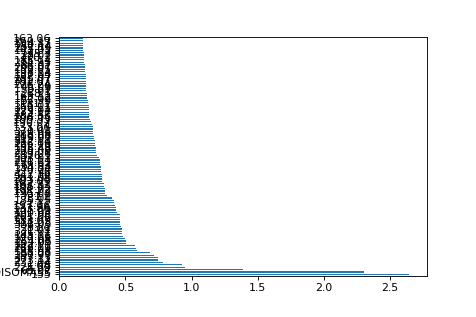

In [92]:
# Visualize most important features
%matplotlib notebook
plt.close()
feat_importances = pd.Series(grid_cb.best_estimator_.feature_importances_, index=df_train[FEATURES].columns)
feat_importances.nlargest(100).plot(kind='barh')
plt.show()

In [22]:
# Compute leverage matrices of most important features
most_imp_feats = feat_importances.nlargest(4220).index

In [23]:
dataset_w_useful_features = df_train[most_imp_feats]

In [24]:
leverage_mat_train = dataset_w_useful_features.T.dot(dataset_w_useful_features)
leverage_mat_train = pd.DataFrame(np.linalg.pinv(leverage_mat_train.values), leverage_mat_train.columns, leverage_mat_train.index)

In [25]:
# Test with one sample from train set
leverages_train = []
for i in range(len(df_train)):
    if i % 1000 == 0:
        print(i)
    leverage = dataset_w_useful_features.iloc[i].values.T @ leverage_mat_train.values @ dataset_w_useful_features.iloc[i].values
    leverages_train.append(leverage)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000


In [26]:
leverages_test_norman = np.diag(df_test_norman[most_imp_feats].values @ leverage_mat_train.values @ df_test_norman[most_imp_feats].values.T)
leverages_test_amide = np.diag(df_test_amide[most_imp_feats].values @ leverage_mat_train.values @ df_test_amide[most_imp_feats].values.T)

<IPython.core.display.Javascript object>


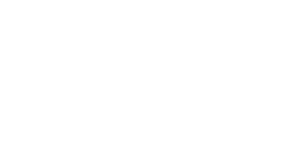

Text(0.5, 0, 'leverage value')

In [27]:
%matplotlib notebook
plt.hist(leverages_train, bins=100)
plt.show()
plt.ylabel('frequency')
plt.xlabel('leverage value')

<IPython.core.display.Javascript object>


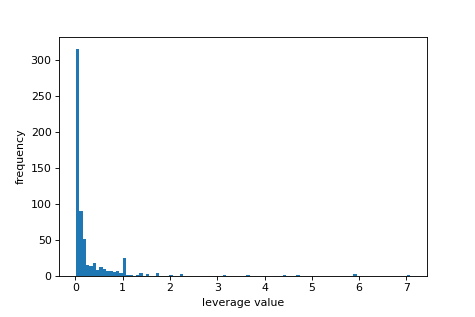

Text(0.5, 0, 'leverage value')

In [28]:
%matplotlib notebook
plt.hist(leverages_test_amide, bins=100)
plt.show()
plt.ylabel('frequency')
plt.xlabel('leverage value')